In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import time
import random
np.random.seed(42)

class DiscretizationWrapper:
    """Discretize continuous state space for tabular methods."""

    def __init__(self, env, n_bins=(20, 20)):
        self.env = env
        self.n_bins = n_bins

        self.obs_low = env.observation_space.low
        self.obs_high = env.observation_space.high

        self.bin_width = (self.obs_high - self.obs_low) / n_bins

    def discretize(self, observation):
        """Convert continuous state to discrete state index."""
        clipped_obs = np.clip(observation, self.obs_low, self.obs_high)
        bin_indices = np.floor((clipped_obs - self.obs_low) / self.bin_width).astype(int)

        bin_indices = np.clip(bin_indices, 0, np.array(self.n_bins) - 1)

        state_index = bin_indices[0] * self.n_bins[1] + bin_indices[1]
        return state_index

class QLearningAgent:
    """Q-learning agent with softmax action selection."""

    def __init__(self, n_states, n_actions, learning_rate=0.1, discount_factor=0.99,
                 initial_temp=1.0, temp_decay=0.99, min_temp=0.01):
        self.n_states = n_states
        self.n_actions = n_actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor

        # Temperature parameter for softmax
        self.temperature = initial_temp
        self.temp_decay = temp_decay
        self.min_temp = min_temp

        # Initialize Q-table
        self.q_table = np.zeros((n_states, n_actions))

    def select_action(self, state):
        """Select action using softmax policy with numerical stability."""
        # Get Q-values for current state
        q_values = self.q_table[state]

        # Apply a trick for numerical stability: subtract max Q-value
        q_values = q_values - np.max(q_values)

        # Calculate exponentials with the stabilized values
        exp_q = np.exp(q_values / max(self.temperature, 1e-10))

        # Check for NaN/Inf and handle it
        if np.any(np.isnan(exp_q)) or np.any(np.isinf(exp_q)):
            # Fall back to argmax if numerical issues occur
            return np.argmax(self.q_table[state])

        # Calculate probabilities
        sum_exp_q = np.sum(exp_q)
        if sum_exp_q == 0:  # Additional safety check
            return np.argmax(self.q_table[state])

        probabilities = exp_q / sum_exp_q

        # Sample action according to probabilities
        try:
            action = np.random.choice(self.n_actions, p=probabilities)
            return action
        except:
            # Final fallback to argmax if something goes wrong with sampling
            return np.argmax(self.q_table[state])

    def update(self, state, action, reward, next_state, done):
        """Update Q-values using Q-learning."""
        # Calculate TD target and error
        if done:
            target = reward
        else:
            target = reward + self.discount_factor * np.max(self.q_table[next_state])

        # Update Q-value
        self.q_table[state, action] += self.learning_rate * (target - self.q_table[state, action])

    def decay_temperature(self):
        """Decay temperature parameter for softmax."""
        self.temperature = max(self.min_temp, self.temperature * self.temp_decay)

class SarsaAgent:
    """SARSA agent with ε-greedy exploration."""

    def __init__(self, n_states, n_actions, learning_rate=0.1, discount_factor=0.99,
                 initial_epsilon=0.3, epsilon_decay=0.995, min_epsilon=0.01):
        self.n_states = n_states
        self.n_actions = n_actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor

        # Epsilon parameter for ε-greedy
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        # Initialize Q-table
        self.q_table = np.zeros((n_states, n_actions))

    def select_action(self, state):
        """Select action using ε-greedy policy."""
        if np.random.random() < self.epsilon:
            # Explore: select random action
            action = np.random.randint(self.n_actions)
        else:
            # Exploit: select best action
            action = np.argmax(self.q_table[state])
        return action

    def update(self, state, action, reward, next_state, next_action, done):
        """Update Q-values using SARSA."""

        if done:
            target = reward
        else:
            target = reward + self.discount_factor * self.q_table[next_state, next_action]


        self.q_table[state, action] += self.learning_rate * (target - self.q_table[state, action])

    def decay_epsilon(self):
        """Decay epsilon parameter for ε-greedy."""
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)


from collections import deque

def train_q_learning(env_name='MountainCar-v0', n_episodes=1000, n_bins=(20, 20),
                     learning_rate=0.1, discount_factor=0.99, initial_temp=1.0,
                     temp_decay=0.99, min_temp=0.01, n_runs=5):
    """Train Q-learning agent on MountainCar environment with optimized memory usage."""

    print("Starting Q-learning")
    env = gym.make(env_name)
    wrapper = DiscretizationWrapper(env, n_bins)

    n_states = np.prod(n_bins)
    n_actions = env.action_space.n

    avg_run_rewards = np.zeros(n_episodes, dtype=np.float32)  # Preallocate memory
    avg_run_lengths = np.zeros(n_episodes, dtype=np.float32)  # Preallocate memory

    for run in range(n_runs):
        agent = QLearningAgent(n_states, n_actions, learning_rate, discount_factor,
                               initial_temp, temp_decay, min_temp)

        episode_rewards = np.zeros(n_episodes, dtype=np.float32)  # Preallocate memory
        episode_lengths = np.zeros(n_episodes, dtype=np.int32)  # Preallocate memory
        avg_rewards = deque(maxlen=100)  # Keep only recent rewards

        for episode in range(n_episodes):
            observation, _ = env.reset()
            state = wrapper.discretize(observation)

            episode_reward = 0
            episode_length = 0
            done = False
            truncated = False

            while not (done or truncated):
                action = agent.select_action(state)
                next_observation, reward, done, truncated, _ = env.step(action)
                next_state = wrapper.discretize(next_observation)

                agent.update(state, action, reward, next_state, done or truncated)
                state = next_state

                episode_reward += reward
                episode_length += 1

            agent.decay_temperature()
            episode_rewards[episode] = episode_reward  # Store in preallocated array
            episode_lengths[episode] = episode_length  # Store in preallocated array
            avg_rewards.append(episode_reward)

            if (episode + 1) % 1000 == 0:
                avg_reward = np.mean(avg_rewards)
                print(f"Run:{run} Episode {episode+1}/{n_episodes}, Avg Reward: {avg_reward:.2f}, Temperature: {agent.temperature:.4f}")
                if avg_reward >= -110:
                    print(f"Environment solved in {episode+1} episodes!")
                    break

        # Aggregate results across runs instead of storing everything
        avg_run_rewards += episode_rewards / n_runs
        avg_run_lengths += episode_lengths / n_runs

    env.close()
    return agent, avg_run_rewards, avg_run_lengths




def train_sarsa(env_name='MountainCar-v0', n_episodes=1000, n_bins=(20, 20),
                learning_rate=0.1, discount_factor=0.99, initial_epsilon=0.3,
                epsilon_decay=0.995, min_epsilon=0.01, n_runs=5):
    """Train SARSA agent on MountainCar environment with reduced memory usage."""

    print("Training SARSA")
    env = gym.make(env_name)
    wrapper = DiscretizationWrapper(env, n_bins)

    n_states = np.prod(n_bins)
    n_actions = env.action_space.n

    avg_run_rewards = np.zeros(n_episodes, dtype=np.float32)  # Preallocate memory
    avg_run_lengths = np.zeros(n_episodes, dtype=np.float32)  # Preallocate memory

    for run in range(n_runs):
        agent = SarsaAgent(n_states, n_actions, learning_rate, discount_factor,
                           initial_epsilon, epsilon_decay, min_epsilon)

        episode_rewards = np.zeros(n_episodes, dtype=np.float32)  # Preallocate memory
        episode_lengths = np.zeros(n_episodes, dtype=np.int32)  # Preallocate memory
        avg_rewards = deque(maxlen=100)  # Keep only recent rewards

        for episode in range(n_episodes):
            observation, _ = env.reset()
            state = wrapper.discretize(observation)
            action = agent.select_action(state)

            episode_reward = 0
            episode_length = 0
            done = False
            truncated = False

            while not (done or truncated):
                next_observation, reward, done, truncated, _ = env.step(action)
                next_state = wrapper.discretize(next_observation)
                next_action = agent.select_action(next_state)

                agent.update(state, action, reward, next_state, next_action, done or truncated)

                state = next_state
                action = next_action
                episode_reward += reward
                episode_length += 1

            agent.decay_epsilon()
            episode_rewards[episode] = episode_reward  # Store in preallocated array
            episode_lengths[episode] = episode_length  # Store in preallocated array
            avg_rewards.append(episode_reward)

            if (episode + 1) % 1000 == 0:
                avg_reward = np.mean(avg_rewards)
                print(f"Run:{run} Episode {episode+1}/{n_episodes}, Avg Reward: {avg_reward:.2f}, Epsilon: {agent.epsilon:.4f}")
                if avg_reward >= -110:
                    print(f"Environment solved in {episode+1} episodes!")
                    break

        # Aggregate results across runs instead of storing everything
        avg_run_rewards += episode_rewards / n_runs
        avg_run_lengths += episode_lengths / n_runs

    env.close()
    return agent, avg_run_rewards, avg_run_lengths


def visualize_policy(agent, env_name='MountainCar-v0', n_bins=(20, 20)):
    """Visualize the learned policy."""
    env = gym.make(env_name, render_mode='rgb_array')
    wrapper = DiscretizationWrapper(env, n_bins)

    observation, _ = env.reset()
    state = wrapper.discretize(observation)

    done = False
    truncated = False
    total_reward = 0

    plt.figure(figsize=(8, 6))
    img = plt.imshow(env.render())
    plt.axis('off')
    display_handle = display.display(plt.gcf(), display_id=True)

    while not (done or truncated):
        if isinstance(agent, QLearningAgent):
            action = np.argmax(agent.q_table[state])
        else:
            action = np.argmax(agent.q_table[state])
        observation, reward, done, truncated, _ = env.step(action)
        state = wrapper.discretize(observation)
        total_reward += reward
        img.set_data(env.render())
        display.update_display(display_handle, display.clear_output(wait=True))
        plt.pause(0.01)

    print(f"Episode finished with reward: {total_reward}")
    env.close()
    plt.close()

def plot_results(q_rewards, sarsa_rewards):
    """Plot training results."""
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(q_rewards, label='Q-Learning')
    plt.plot(sarsa_rewards, label='SARSA')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Episode Rewards')
    plt.legend()
    plt.subplot(1, 2, 2)
    window_size = 100
    q_moving_avg = [np.mean(q_rewards[max(0, i-window_size):i+1]) for i in range(len(q_rewards))]
    sarsa_moving_avg = [np.mean(sarsa_rewards[max(0, i-window_size):i+1]) for i in range(len(sarsa_rewards))]

    plt.plot(q_moving_avg, label='Q-Learning')
    plt.plot(sarsa_moving_avg, label='SARSA')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward (last 100 episodes)')
    plt.title('Moving Average Rewards')
    plt.legend()

    plt.tight_layout()
    plt.show()
def plot_rewards_with_std(mean_rewards, std_rewards, title="SARSA Training Performance"):
    """
    Plots the mean episode reward with standard deviation shading.

    Parameters:
        mean_rewards (array-like): Mean rewards per episode.
        std_rewards (array-like): Standard deviation of rewards per episode.
        title (str): Title of the plot.
    """
    episodes = np.arange(len(mean_rewards))  # X-axis (episode numbers)

    plt.figure(figsize=(8, 5))

    # Plot mean rewards
    plt.plot(episodes, mean_rewards, label="Mean Episode Reward", color="blue")

    # Fill between mean ± standard deviation
    plt.fill_between(episodes,
                     mean_rewards - std_rewards,
                     mean_rewards + std_rewards,
                     color="blue", alpha=0.2, label="±1 Std Dev")

    # Labels, title, and legend
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title(title)
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

In [ ]:
def train_q_learning(env_name='MountainCar-v0', n_episodes=1000, n_bins=(20, 20),
                     learning_rate=0.1, discount_factor=0.99, initial_temp=1.0,
                     temp_decay=0.99, min_temp=0.01, n_runs=5):
    """Train Q-learning agent on MountainCar environment with optimized memory usage."""

    print("Starting Q-learning")
    env = gym.make(env_name)
    wrapper = DiscretizationWrapper(env, n_bins)

    n_states = np.prod(n_bins)
    n_actions = env.action_space.n

    avg_run_rewards = np.zeros(n_episodes, dtype=np.float32)  # Preallocate memory
    avg_run_lengths = np.zeros(n_episodes, dtype=np.float32)  # Preallocate memory

    for run in range(n_runs):
        agent = QLearningAgent(n_states, n_actions, learning_rate, discount_factor,
                               initial_temp, temp_decay, min_temp)

        episode_rewards = np.zeros(n_episodes, dtype=np.float32)  # Preallocate memory
        episode_lengths = np.zeros(n_episodes, dtype=np.int32)  # Preallocate memory
        avg_rewards = deque(maxlen=100)  # Keep only recent rewards

        for episode in range(n_episodes):
            observation, _ = env.reset()
            state = wrapper.discretize(observation)

            episode_reward = 0
            episode_length = 0
            done = False
            truncated = False

            while not (done or truncated):
                action = agent.select_action(state)
                next_observation, reward, done, truncated, _ = env.step(action)
                next_state = wrapper.discretize(next_observation)

                agent.update(state, action, reward, next_state, done or truncated)
                state = next_state

                episode_reward += reward
                episode_length += 1

            agent.decay_temperature()
            episode_rewards[episode] = episode_reward  # Store in preallocated array
            episode_lengths[episode] = episode_length  # Store in preallocated array
            avg_rewards.append(episode_reward)

            if (episode + 1) % 1000 == 0:
                avg_reward = np.mean(avg_rewards)
                print(f"Run:{run} Episode {episode+1}/{n_episodes}, Avg Reward: {avg_reward:.2f}, Temperature: {agent.temperature:.4f}")
                if avg_reward >= -110:
                    print(f"Environment solved in {episode+1} episodes!")
                    break

        # Aggregate results across runs instead of storing everything
        avg_run_rewards += episode_rewards / n_runs
        avg_run_lengths += episode_lengths / n_runs

    env.close()
    return agent, avg_run_rewards, avg_run_lengths



In [ ]:
env_name = 'MountainCar-v0'
n_episodes = 2000
n_bins = (24, 24)  # Position and velocity discretization
learning_rate=0.1
discount_factor=0.99


initial_temp=1.0
temp_decay=0.99
min_temp=0.01
q_agent, q_rewards, q_lengths = train_q_learning(env_name, n_episodes, n_bins,learning_rate,discount_factor,initial_temp,temp_decay,min_temp)


Training Q-learning agent...
Starting Q-learning
Run:0 Episode 1000/2000, Avg Reward: -199.67, Temperature: 0.0100
Run:0 Episode 2000/2000, Avg Reward: -199.56, Temperature: 0.0100
Run:1 Episode 1000/2000, Avg Reward: -199.97, Temperature: 0.0100
Run:1 Episode 2000/2000, Avg Reward: -199.63, Temperature: 0.0100
Run:2 Episode 1000/2000, Avg Reward: -199.20, Temperature: 0.0100
Run:2 Episode 2000/2000, Avg Reward: -199.20, Temperature: 0.0100
Run:3 Episode 1000/2000, Avg Reward: -198.90, Temperature: 0.0100
Run:3 Episode 2000/2000, Avg Reward: -176.11, Temperature: 0.0100
Run:4 Episode 1000/2000, Avg Reward: -199.50, Temperature: 0.0100
Run:4 Episode 2000/2000, Avg Reward: -191.77, Temperature: 0.0100


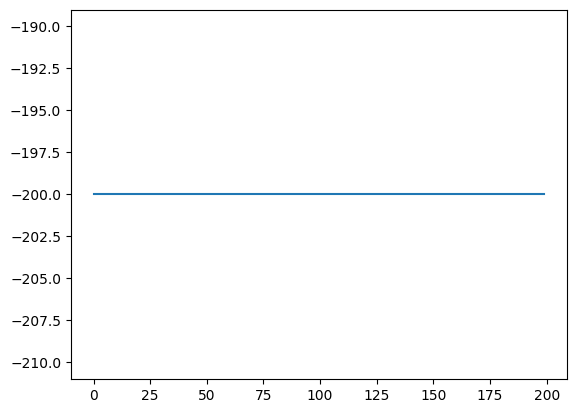

In [ ]:
plt.plot(q_rewards)

In [ ]:
env_name = 'MountainCar-v0'
n_episodes = 2000
n_bins = (10, 10)  # Position and velocity discretization
learning_rate=0.1
discount_factor=0.99
initial_temp=1.0
temp_decay=0.99
min_temp=0.01
q_agent, q_rewards, q_lengths = train_q_learning(env_name, n_episodes, n_bins,learning_rate,discount_factor,initial_temp,temp_decay,min_temp)


Starting Q-learning
Run:0 Episode 1000/2000, Avg Reward: -195.56, Temperature: 0.0100
Run:0 Episode 2000/2000, Avg Reward: -194.56, Temperature: 0.0100
Run:1 Episode 1000/2000, Avg Reward: -173.05, Temperature: 0.0100
Run:1 Episode 2000/2000, Avg Reward: -198.21, Temperature: 0.0100
Run:2 Episode 1000/2000, Avg Reward: -166.63, Temperature: 0.0100
Run:2 Episode 2000/2000, Avg Reward: -157.43, Temperature: 0.0100
Run:3 Episode 1000/2000, Avg Reward: -172.39, Temperature: 0.0100
Run:3 Episode 2000/2000, Avg Reward: -185.07, Temperature: 0.0100
Run:4 Episode 1000/2000, Avg Reward: -161.48, Temperature: 0.0100
Run:4 Episode 2000/2000, Avg Reward: -198.88, Temperature: 0.0100


Starting Q-learning
Run:0 Episode 1000/5000, Avg Reward: -200.00, Temperature: 0.1000
Run:0 Episode 2000/5000, Avg Reward: -199.93, Temperature: 0.1000
Run:0 Episode 3000/5000, Avg Reward: -195.83, Temperature: 0.1000
Run:0 Episode 4000/5000, Avg Reward: -190.72, Temperature: 0.1000
Run:0 Episode 5000/5000, Avg Reward: -194.06, Temperature: 0.1000
Run:1 Episode 1000/5000, Avg Reward: -199.82, Temperature: 0.1000
Run:1 Episode 2000/5000, Avg Reward: -200.00, Temperature: 0.1000
Run:1 Episode 3000/5000, Avg Reward: -199.68, Temperature: 0.1000
Run:1 Episode 4000/5000, Avg Reward: -171.39, Temperature: 0.1000
Run:1 Episode 5000/5000, Avg Reward: -164.60, Temperature: 0.1000
Run:2 Episode 1000/5000, Avg Reward: -199.12, Temperature: 0.1000
Run:2 Episode 2000/5000, Avg Reward: -199.70, Temperature: 0.1000
Run:2 Episode 3000/5000, Avg Reward: -198.83, Temperature: 0.1000
Run:2 Episode 4000/5000, Avg Reward: -174.90, Temperature: 0.1000
Run:2 Episode 5000/5000, Avg Reward: -163.23, Temperatur

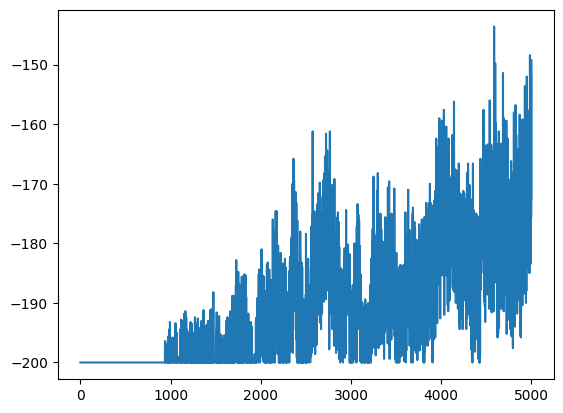

In [ ]:
n_episodes = 5000
n_bins = (20, 20)  # Finer discretization
learning_rate = 0.05  # Smaller LR for smoother updates
discount_factor = 0.99  # High discount for long-term rewards
initial_temp = 1.0
temp_decay = 0.995  # Slower decay to maintain exploration longer
min_temp = 0.1  # Prevent premature exploitation

q_agent, q_rewards, q_lengths = train_q_learning(env_name, n_episodes, n_bins,learning_rate,discount_factor,initial_temp,temp_decay,min_temp)
plt.plot(q_rewards)

Starting Q-learning
Run:0 Episode 1000/5000, Avg Reward: -195.74, Temperature: 0.2000
Run:0 Episode 2000/5000, Avg Reward: -187.35, Temperature: 0.2000
Run:0 Episode 3000/5000, Avg Reward: -199.30, Temperature: 0.2000
Run:0 Episode 4000/5000, Avg Reward: -200.00, Temperature: 0.2000
Run:0 Episode 5000/5000, Avg Reward: -200.00, Temperature: 0.2000
Run:1 Episode 1000/5000, Avg Reward: -198.49, Temperature: 0.2000
Run:1 Episode 2000/5000, Avg Reward: -192.18, Temperature: 0.2000
Run:1 Episode 3000/5000, Avg Reward: -200.00, Temperature: 0.2000
Run:1 Episode 4000/5000, Avg Reward: -200.00, Temperature: 0.2000
Run:1 Episode 5000/5000, Avg Reward: -186.33, Temperature: 0.2000
Run:2 Episode 1000/5000, Avg Reward: -195.51, Temperature: 0.2000
Run:2 Episode 2000/5000, Avg Reward: -193.74, Temperature: 0.2000
Run:2 Episode 3000/5000, Avg Reward: -200.00, Temperature: 0.2000
Run:2 Episode 4000/5000, Avg Reward: -188.01, Temperature: 0.2000
Run:2 Episode 5000/5000, Avg Reward: -200.00, Temperatur

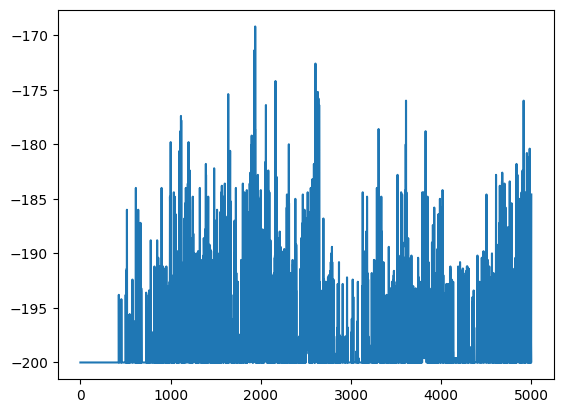

In [ ]:
n_episodes = 5000
n_bins = (20, 20)  # Finer state representation
learning_rate = 0.2  # Faster learning
discount_factor = 0.97  # Less emphasis on long-term rewards

initial_temp = 2.0  # More exploration early on
temp_decay = 0.995  # Slower decay
min_temp = 0.2  # Allow more randomness at the end

q_agent, q_rewards, q_lengths = train_q_learning(env_name, n_episodes, n_bins,learning_rate,discount_factor,initial_temp,temp_decay,min_temp)
plt.plot(q_rewards)

In [ ]:
n_episodes = 5000
n_bins = (30, 30)  # Finer state representation
learning_rate = 0.1  # More stable updates
discount_factor = 0.95  # Slightly reduced emphasis on long-term rewards

initial_temp = 2.0
temp_decay = 0.999  # Slower decay
min_temp = 0.2

q_agent, q_rewards, q_lengths = train_q_learning(env_name, n_episodes, n_bins,learning_rate,discount_factor,initial_temp,temp_decay,min_temp)
plt.plot(q_rewards)

Starting Q-learning
Run:0 Episode 1000/5000, Avg Reward: -200.00, Temperature: 0.7354
Run:0 Episode 2000/5000, Avg Reward: -200.00, Temperature: 0.2704
Run:0 Episode 3000/5000, Avg Reward: -200.00, Temperature: 0.2000
Run:0 Episode 4000/5000, Avg Reward: -200.00, Temperature: 0.2000
Run:0 Episode 5000/5000, Avg Reward: -199.28, Temperature: 0.2000
Run:1 Episode 1000/5000, Avg Reward: -200.00, Temperature: 0.7354
Run:1 Episode 2000/5000, Avg Reward: -200.00, Temperature: 0.2704
Run:1 Episode 3000/5000, Avg Reward: -200.00, Temperature: 0.2000
Run:1 Episode 4000/5000, Avg Reward: -200.00, Temperature: 0.2000
Run:1 Episode 5000/5000, Avg Reward: -200.00, Temperature: 0.2000
Run:2 Episode 1000/5000, Avg Reward: -200.00, Temperature: 0.7354
Run:2 Episode 2000/5000, Avg Reward: -200.00, Temperature: 0.2704
Run:2 Episode 3000/5000, Avg Reward: -200.00, Temperature: 0.2000
Run:2 Episode 4000/5000, Avg Reward: -200.00, Temperature: 0.2000
Run:2 Episode 5000/5000, Avg Reward: -200.00, Temperatur

KeyboardInterrupt: 

Starting Q-learning
Run:0 Episode 1000/5000, Avg Reward: -194.00, Temperature: 0.0100
Run:0 Episode 2000/5000, Avg Reward: -194.27, Temperature: 0.0100
Run:0 Episode 3000/5000, Avg Reward: -177.89, Temperature: 0.0100
Run:0 Episode 4000/5000, Avg Reward: -166.70, Temperature: 0.0100
Run:0 Episode 5000/5000, Avg Reward: -159.80, Temperature: 0.0100
Run:1 Episode 1000/5000, Avg Reward: -198.53, Temperature: 0.0100
Run:1 Episode 2000/5000, Avg Reward: -187.18, Temperature: 0.0100
Run:1 Episode 3000/5000, Avg Reward: -180.35, Temperature: 0.0100
Run:1 Episode 4000/5000, Avg Reward: -167.77, Temperature: 0.0100
Run:1 Episode 5000/5000, Avg Reward: -157.84, Temperature: 0.0100
Run:2 Episode 1000/5000, Avg Reward: -198.00, Temperature: 0.0100
Run:2 Episode 2000/5000, Avg Reward: -196.62, Temperature: 0.0100
Run:2 Episode 3000/5000, Avg Reward: -190.72, Temperature: 0.0100
Run:2 Episode 4000/5000, Avg Reward: -148.88, Temperature: 0.0100
Run:2 Episode 5000/5000, Avg Reward: -148.50, Temperatur

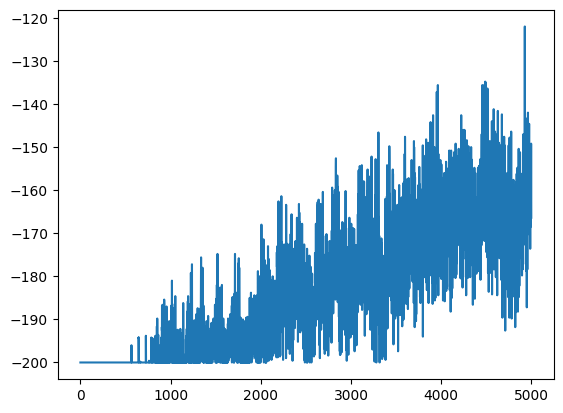

In [ ]:
env_name = 'MountainCar-v0'
n_episodes = 5000
n_bins = (24, 24)  # Position and velocity discretization
learning_rate=0.1
discount_factor=0.99  # Slightly reduced emphasis on long-term rewards

initial_temp=1.0
temp_decay=0.99
min_temp=0.01

q_agent, q_rewards, q_lengths = train_q_learning(env_name, n_episodes, n_bins,learning_rate,discount_factor,initial_temp,temp_decay,min_temp,n_runs=2)
plt.plot(q_rewards)

Starting Q-learning
Run:0 Episode 1000/5000, Avg Reward: -168.80, Temperature: 0.0100
Run:0 Episode 2000/5000, Avg Reward: -164.16, Temperature: 0.0100
Run:0 Episode 3000/5000, Avg Reward: -136.65, Temperature: 0.0100
Run:0 Episode 4000/5000, Avg Reward: -200.00, Temperature: 0.0100
Run:0 Episode 5000/5000, Avg Reward: -200.00, Temperature: 0.0100
Run:1 Episode 1000/5000, Avg Reward: -161.08, Temperature: 0.0100
Run:1 Episode 2000/5000, Avg Reward: -165.48, Temperature: 0.0100
Run:1 Episode 3000/5000, Avg Reward: -188.17, Temperature: 0.0100
Run:1 Episode 4000/5000, Avg Reward: -189.08, Temperature: 0.0100
Run:1 Episode 5000/5000, Avg Reward: -190.90, Temperature: 0.0100
Run:2 Episode 1000/5000, Avg Reward: -167.98, Temperature: 0.0100
Run:2 Episode 2000/5000, Avg Reward: -190.12, Temperature: 0.0100
Run:2 Episode 3000/5000, Avg Reward: -200.00, Temperature: 0.0100
Run:2 Episode 4000/5000, Avg Reward: -200.00, Temperature: 0.0100
Run:2 Episode 5000/5000, Avg Reward: -200.00, Temperatur

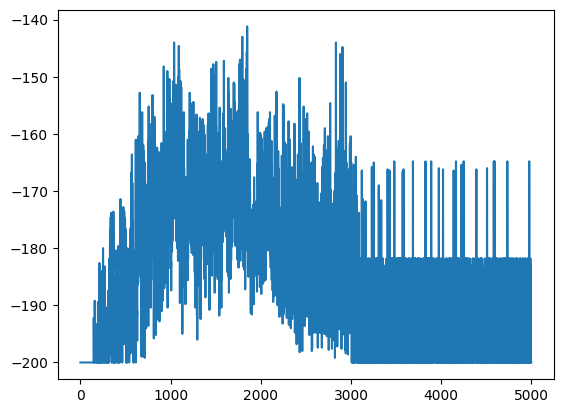

In [ ]:
env_name = 'MountainCar-v0'
n_episodes = 5000
n_bins = (10, 10)  # Position and velocity discretization
learning_rate=0.1
discount_factor=0.99  # Slightly reduced emphasis on long-term rewards

initial_temp=1.0
temp_decay=0.99
min_temp=0.01

q_agent, q_rewards, q_lengths = train_q_learning(env_name, n_episodes, n_bins,learning_rate,discount_factor,initial_temp,temp_decay,min_temp,n_runs=2)
plt.plot(q_rewards)

Starting Q-learning
Run:0 Episode 1000/5000, Avg Reward: -199.44, Temperature: 0.0100
Run:0 Episode 2000/5000, Avg Reward: -185.28, Temperature: 0.0100
Run:0 Episode 3000/5000, Avg Reward: -194.07, Temperature: 0.0100
Run:0 Episode 4000/5000, Avg Reward: -165.54, Temperature: 0.0100
Run:0 Episode 5000/5000, Avg Reward: -145.23, Temperature: 0.0100
Run:1 Episode 1000/5000, Avg Reward: -189.23, Temperature: 0.0100
Run:1 Episode 2000/5000, Avg Reward: -168.42, Temperature: 0.0100
Run:1 Episode 3000/5000, Avg Reward: -166.53, Temperature: 0.0100
Run:1 Episode 4000/5000, Avg Reward: -197.40, Temperature: 0.0100
Run:1 Episode 5000/5000, Avg Reward: -199.06, Temperature: 0.0100
Run:2 Episode 1000/5000, Avg Reward: -186.26, Temperature: 0.0100
Run:2 Episode 2000/5000, Avg Reward: -166.17, Temperature: 0.0100
Run:2 Episode 3000/5000, Avg Reward: -182.97, Temperature: 0.0100
Run:2 Episode 4000/5000, Avg Reward: -198.98, Temperature: 0.0100
Run:2 Episode 5000/5000, Avg Reward: -199.60, Temperatur

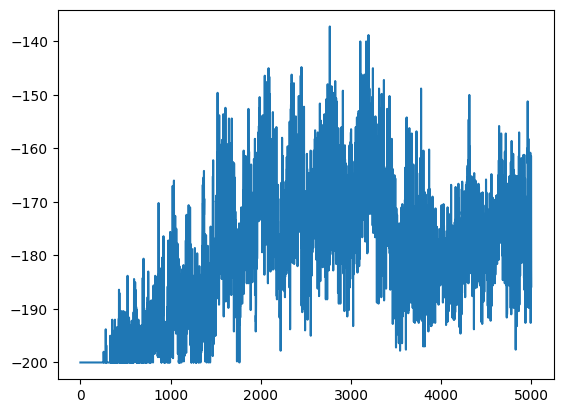

In [ ]:
env_name = 'MountainCar-v0'
n_episodes = 5000
n_bins = (18, 14)  # Position and velocity discretization
learning_rate=0.1
discount_factor=0.99  # Slightly reduced emphasis on long-term rewards

initial_temp=1.0
temp_decay=0.99
min_temp=0.01

q_agent, q_rewards, q_lengths = train_q_learning(env_name, n_episodes, n_bins,learning_rate,discount_factor,initial_temp,temp_decay,min_temp,n_runs=2)
plt.plot(q_rewards)

In [ ]:
env_name = 'MountainCar-v0'
n_episodes = 5000
n_bins = (24, 24)  # Position and velocity discretization
learning_rate=0.1
discount_factor=0.99  # Slightly reduced emphasis on long-term rewards

initial_temp=10.0
temp_decay=0.9995
min_temp=0.01

q_agent, q_rewards, q_lengths = train_q_learning(env_name, n_episodes, n_bins,learning_rate,discount_factor,initial_temp,temp_decay,min_temp,n_runs=2)
plt.plot(q_rewards)

Starting Q-learning
Run:0 Episode 1000/5000, Avg Reward: -200.00, Temperature: 6.0645
Run:0 Episode 2000/5000, Avg Reward: -200.00, Temperature: 3.6779
Run:0 Episode 3000/5000, Avg Reward: -200.00, Temperature: 2.2305
Run:0 Episode 4000/5000, Avg Reward: -200.00, Temperature: 1.3527
Run:0 Episode 5000/5000, Avg Reward: -200.00, Temperature: 0.8203
Run:1 Episode 1000/5000, Avg Reward: -200.00, Temperature: 6.0645
Run:1 Episode 2000/5000, Avg Reward: -200.00, Temperature: 3.6779


KeyboardInterrupt: 

Starting Q-learning
Run:0 Episode 1000/5000, Avg Reward: -198.19, Temperature: 0.7354
Run:0 Episode 2000/5000, Avg Reward: -177.48, Temperature: 0.2704
Run:0 Episode 3000/5000, Avg Reward: -161.89, Temperature: 0.1000
Run:0 Episode 4000/5000, Avg Reward: -200.00, Temperature: 0.1000
Run:0 Episode 5000/5000, Avg Reward: -200.00, Temperature: 0.1000
Run:1 Episode 1000/5000, Avg Reward: -199.05, Temperature: 0.7354
Run:1 Episode 2000/5000, Avg Reward: -171.34, Temperature: 0.2704
Run:1 Episode 3000/5000, Avg Reward: -196.96, Temperature: 0.1000
Run:1 Episode 4000/5000, Avg Reward: -195.95, Temperature: 0.1000
Run:1 Episode 5000/5000, Avg Reward: -195.77, Temperature: 0.1000


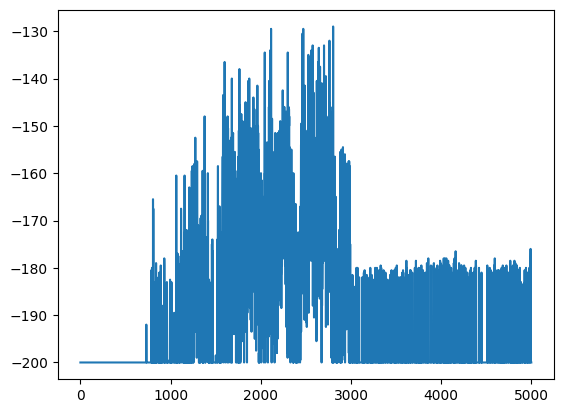

In [ ]:
initial_temp = 2.0  # More exploration initially
temp_decay = 0.999  # Decay slower to avoid premature exploitation
min_temp = 0.1      # Ensure some randomness remains
env_name = 'MountainCar-v0'
n_episodes = 5000
n_bins = (10, 10)  # Position and velocity discretization
learning_rate=0.1
discount_factor=0.99  # Slightly reduced emphasis on long-term rewards


q_agent, q_rewards, q_lengths = train_q_learning(env_name, n_episodes, n_bins,learning_rate,discount_factor,initial_temp,temp_decay,min_temp,n_runs=2)
plt.plot(q_rewards)

Starting Q-learning
Run:0 Episode 1000/15000, Avg Reward: -198.18, Temperature: 0.0100
Run:0 Episode 2000/15000, Avg Reward: -188.71, Temperature: 0.0100
Run:0 Episode 3000/15000, Avg Reward: -184.00, Temperature: 0.0100
Run:0 Episode 4000/15000, Avg Reward: -166.75, Temperature: 0.0100
Run:0 Episode 5000/15000, Avg Reward: -173.08, Temperature: 0.0100
Run:0 Episode 6000/15000, Avg Reward: -167.29, Temperature: 0.0100
Run:0 Episode 7000/15000, Avg Reward: -170.72, Temperature: 0.0100
Run:0 Episode 8000/15000, Avg Reward: -169.78, Temperature: 0.0100
Run:0 Episode 9000/15000, Avg Reward: -138.13, Temperature: 0.0100
Run:0 Episode 10000/15000, Avg Reward: -148.63, Temperature: 0.0100
Run:0 Episode 11000/15000, Avg Reward: -140.16, Temperature: 0.0100
Run:0 Episode 12000/15000, Avg Reward: -136.68, Temperature: 0.0100
Run:0 Episode 13000/15000, Avg Reward: -137.60, Temperature: 0.0100
Run:0 Episode 14000/15000, Avg Reward: -138.98, Temperature: 0.0100
Run:0 Episode 15000/15000, Avg Reward

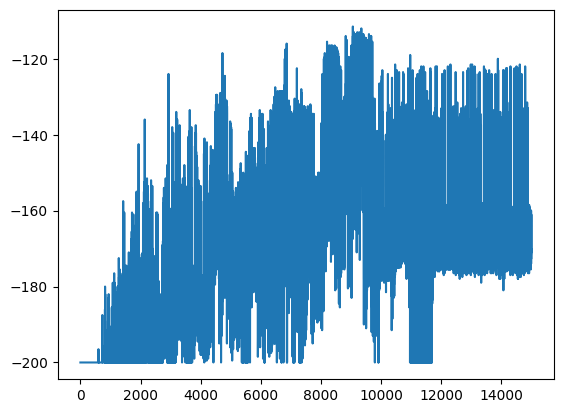

In [ ]:
env_name = 'MountainCar-v0'
n_episodes = 15000
n_bins = (24, 24)  # Position and velocity discretization
learning_rate=0.1
discount_factor=0.99  # Slightly reduced emphasis on long-term rewards

initial_temp=1.0
temp_decay=0.99
min_temp=0.01

q_agent, q_rewards, q_lengths = train_q_learning(env_name, n_episodes, n_bins,learning_rate,discount_factor,initial_temp,temp_decay,min_temp,n_runs=2)
plt.plot(q_rewards)

Starting Q-learning
Run:0 Episode 1000/20000, Avg Reward: -199.81, Temperature: 0.5515
Run:0 Episode 2000/20000, Avg Reward: -191.29, Temperature: 0.2028
Run:0 Episode 3000/20000, Avg Reward: -187.21, Temperature: 0.0746
Run:0 Episode 4000/20000, Avg Reward: -149.53, Temperature: 0.0274
Run:0 Episode 5000/20000, Avg Reward: -149.90, Temperature: 0.0101
Run:0 Episode 6000/20000, Avg Reward: -148.34, Temperature: 0.0100
Run:0 Episode 7000/20000, Avg Reward: -148.93, Temperature: 0.0100
Run:0 Episode 8000/20000, Avg Reward: -148.07, Temperature: 0.0100
Run:0 Episode 9000/20000, Avg Reward: -150.54, Temperature: 0.0100
Run:0 Episode 10000/20000, Avg Reward: -148.53, Temperature: 0.0100
Run:0 Episode 11000/20000, Avg Reward: -148.83, Temperature: 0.0100
Run:0 Episode 12000/20000, Avg Reward: -147.62, Temperature: 0.0100
Run:0 Episode 13000/20000, Avg Reward: -147.71, Temperature: 0.0100
Run:0 Episode 14000/20000, Avg Reward: -146.53, Temperature: 0.0100
Run:0 Episode 15000/20000, Avg Reward

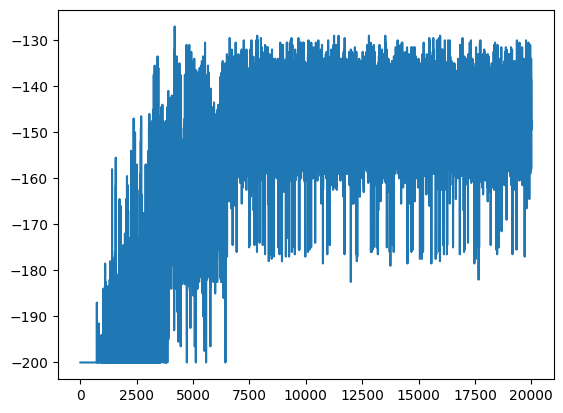

In [ ]:
n_episodes = 20000  # More episodes for better convergence
n_bins = (30, 30)  # Finer discretization of state space improves accuracy
learning_rate = 0.5  # Higher learning rate speeds up learning in sparse-reward environments
discount_factor = 0.99  # Prioritizing long-term rewards
initial_temp = 1.5  # Slightly higher temperature encourages more exploration initially
temp_decay = 0.999  # Slower decay to maintain exploration longer
min_temp = 0.01  # Ensures some exploration throughout training

q_agent, q_rewards, q_lengths = train_q_learning(env_name, n_episodes, n_bins,learning_rate,discount_factor,initial_temp,temp_decay,min_temp,n_runs=2)
plt.plot(q_rewards)

Starting Q-learning
Run:0 Episode 1000/50000, Avg Reward: -200.00, Temperature: 1.2129
Run:0 Episode 2000/50000, Avg Reward: -199.22, Temperature: 0.7356
Run:0 Episode 3000/50000, Avg Reward: -196.62, Temperature: 0.4461
Run:0 Episode 4000/50000, Avg Reward: -188.88, Temperature: 0.2705
Run:0 Episode 5000/50000, Avg Reward: -161.98, Temperature: 0.1641
Run:0 Episode 6000/50000, Avg Reward: -169.60, Temperature: 0.0995
Run:0 Episode 7000/50000, Avg Reward: -160.28, Temperature: 0.0603
Run:0 Episode 8000/50000, Avg Reward: -141.93, Temperature: 0.0366
Run:0 Episode 9000/50000, Avg Reward: -138.54, Temperature: 0.0222
Run:0 Episode 10000/50000, Avg Reward: -141.32, Temperature: 0.0135
Run:0 Episode 11000/50000, Avg Reward: -141.08, Temperature: 0.0100
Run:0 Episode 12000/50000, Avg Reward: -138.35, Temperature: 0.0100
Run:0 Episode 13000/50000, Avg Reward: -140.06, Temperature: 0.0100
Run:0 Episode 14000/50000, Avg Reward: -139.20, Temperature: 0.0100
Run:0 Episode 15000/50000, Avg Reward

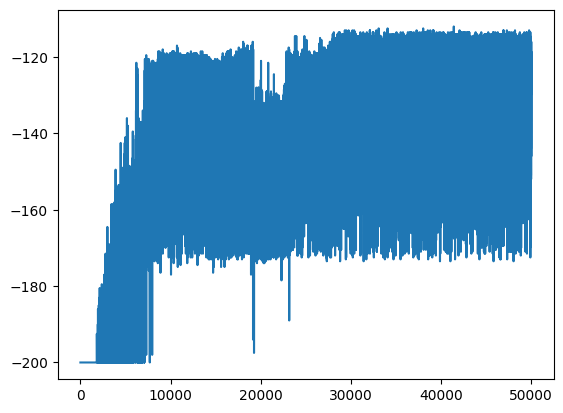

In [ ]:
n_episodes = 50000
n_bins = (40, 40)
learning_rate = 0.5  # With decay
discount_factor = 0.99
initial_temp = 2.0
temp_decay = 0.9995
min_temp = 0.01

q_agent, q_rewards, q_lengths = train_q_learning(env_name, n_episodes, n_bins,learning_rate,discount_factor,initial_temp,temp_decay,min_temp,n_runs=2)
plt.plot(q_rewards)

Starting Q-learning
Run:0 Episode 1000/20000, Avg Reward: -200.00, Temperature: 0.0100
Run:0 Episode 2000/20000, Avg Reward: -194.23, Temperature: 0.0100
Run:0 Episode 3000/20000, Avg Reward: -170.18, Temperature: 0.0100
Run:0 Episode 4000/20000, Avg Reward: -198.59, Temperature: 0.0100
Run:0 Episode 5000/20000, Avg Reward: -173.04, Temperature: 0.0100
Run:0 Episode 6000/20000, Avg Reward: -162.48, Temperature: 0.0100
Run:0 Episode 7000/20000, Avg Reward: -162.21, Temperature: 0.0100
Run:0 Episode 8000/20000, Avg Reward: -161.92, Temperature: 0.0100
Run:0 Episode 9000/20000, Avg Reward: -147.81, Temperature: 0.0100
Run:0 Episode 10000/20000, Avg Reward: -139.66, Temperature: 0.0100
Run:0 Episode 11000/20000, Avg Reward: -170.50, Temperature: 0.0100
Run:0 Episode 12000/20000, Avg Reward: -149.02, Temperature: 0.0100
Run:0 Episode 13000/20000, Avg Reward: -135.75, Temperature: 0.0100
Run:0 Episode 14000/20000, Avg Reward: -133.60, Temperature: 0.0100
Run:0 Episode 15000/20000, Avg Reward

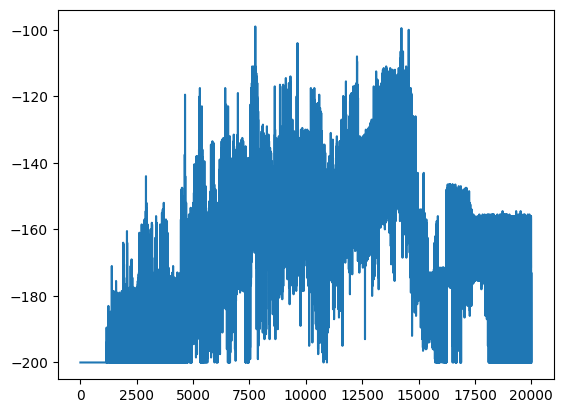

In [ ]:
env_name = 'MountainCar-v0'
n_episodes = 20000
n_bins = (30, 30)  # Position and velocity discretization
learning_rate=0.1
discount_factor=0.99  # Slightly reduced emphasis on long-term rewards

initial_temp=1.0
temp_decay=0.99
min_temp=0.01

q_agent, q_rewards, q_lengths = train_q_learning(env_name, n_episodes, n_bins,learning_rate,discount_factor,initial_temp,temp_decay,min_temp,n_runs=2)
plt.plot(q_rewards)

Starting Q-learning
Run:0 Episode 1000/30000, Avg Reward: -200.00, Temperature: 0.0665
Run:0 Episode 2000/30000, Avg Reward: -199.37, Temperature: 0.0050
Run:0 Episode 3000/30000, Avg Reward: -199.21, Temperature: 0.0050
Run:0 Episode 4000/30000, Avg Reward: -188.25, Temperature: 0.0050
Run:0 Episode 5000/30000, Avg Reward: -194.64, Temperature: 0.0050
Run:0 Episode 6000/30000, Avg Reward: -199.61, Temperature: 0.0050
Run:0 Episode 7000/30000, Avg Reward: -176.73, Temperature: 0.0050
Run:0 Episode 8000/30000, Avg Reward: -195.70, Temperature: 0.0050
Run:0 Episode 9000/30000, Avg Reward: -175.27, Temperature: 0.0050
Run:0 Episode 10000/30000, Avg Reward: -159.15, Temperature: 0.0050
Run:0 Episode 11000/30000, Avg Reward: -163.82, Temperature: 0.0050
Run:0 Episode 12000/30000, Avg Reward: -157.55, Temperature: 0.0050
Run:0 Episode 13000/30000, Avg Reward: -146.23, Temperature: 0.0050
Run:0 Episode 14000/30000, Avg Reward: -142.12, Temperature: 0.0050
Run:0 Episode 15000/30000, Avg Reward

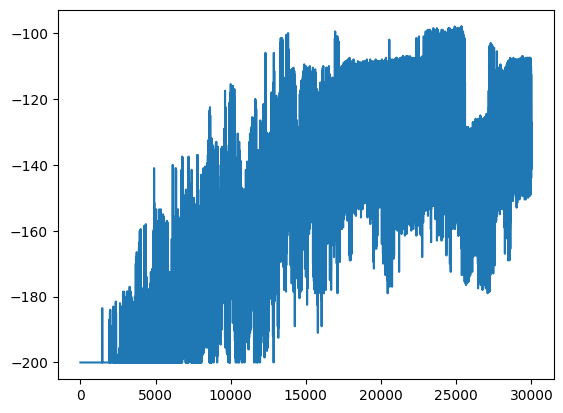

In [ ]:
env_name = 'MountainCar-v0'
n_episodes = 30000
n_bins = (40, 40)  # Position and velocity discretization
learning_rate=0.1
discount_factor=0.99  # Slightly reduced emphasis on long-term rewards

initial_temp=10.0
temp_decay=0.995
min_temp=0.005

q_agent, q_rewards, q_lengths = train_q_learning(env_name, n_episodes, n_bins,learning_rate,discount_factor,initial_temp,temp_decay,min_temp,n_runs=2)
plt.plot(q_rewards)

Starting Q-learning
Run:0 Episode 1000/60000, Avg Reward: -200.00, Temperature: 0.0665
Run:0 Episode 2000/60000, Avg Reward: -200.00, Temperature: 0.0050
Run:0 Episode 3000/60000, Avg Reward: -198.42, Temperature: 0.0050
Run:0 Episode 4000/60000, Avg Reward: -195.86, Temperature: 0.0050
Run:0 Episode 5000/60000, Avg Reward: -181.01, Temperature: 0.0050
Run:0 Episode 6000/60000, Avg Reward: -189.21, Temperature: 0.0050
Run:0 Episode 7000/60000, Avg Reward: -181.53, Temperature: 0.0050
Run:0 Episode 8000/60000, Avg Reward: -177.87, Temperature: 0.0050
Run:0 Episode 9000/60000, Avg Reward: -168.84, Temperature: 0.0050
Run:0 Episode 10000/60000, Avg Reward: -170.28, Temperature: 0.0050
Run:0 Episode 11000/60000, Avg Reward: -162.21, Temperature: 0.0050
Run:0 Episode 12000/60000, Avg Reward: -164.24, Temperature: 0.0050
Run:0 Episode 13000/60000, Avg Reward: -159.69, Temperature: 0.0050
Run:0 Episode 14000/60000, Avg Reward: -157.17, Temperature: 0.0050
Run:0 Episode 15000/60000, Avg Reward

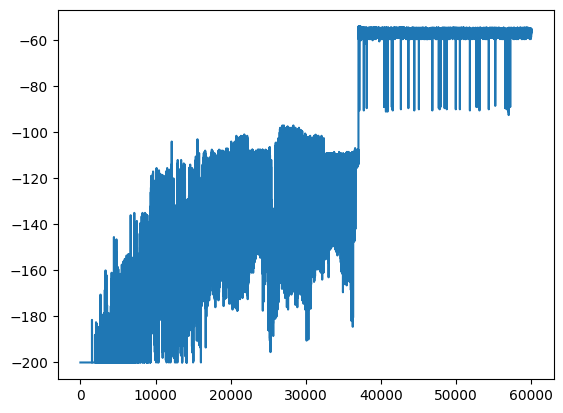

In [ ]:
env_name = 'MountainCar-v0'
n_episodes = 60000
n_bins = (40, 40)  # Position and velocity discretization
learning_rate=0.1
discount_factor=0.99  # Slightly reduced emphasis on long-term rewards

initial_temp=10.0
temp_decay=0.995
min_temp=0.005

q_agent, q_rewards, q_lengths = train_q_learning(env_name, n_episodes, n_bins,learning_rate,discount_factor,initial_temp,temp_decay,min_temp,n_runs=2)
plt.plot(q_rewards)

Starting Q-learning
Run:0 Episode 1000/60000, Avg Reward: -200.00, Temperature: 0.0665
Run:0 Episode 2000/60000, Avg Reward: -200.00, Temperature: 0.0050
Run:0 Episode 3000/60000, Avg Reward: -200.00, Temperature: 0.0050
Run:0 Episode 4000/60000, Avg Reward: -198.84, Temperature: 0.0050
Run:0 Episode 5000/60000, Avg Reward: -197.66, Temperature: 0.0050
Run:0 Episode 6000/60000, Avg Reward: -197.16, Temperature: 0.0050
Run:0 Episode 7000/60000, Avg Reward: -194.93, Temperature: 0.0050
Run:0 Episode 8000/60000, Avg Reward: -196.93, Temperature: 0.0050
Run:0 Episode 9000/60000, Avg Reward: -199.49, Temperature: 0.0050
Run:0 Episode 10000/60000, Avg Reward: -179.05, Temperature: 0.0050
Run:0 Episode 11000/60000, Avg Reward: -184.03, Temperature: 0.0050
Run:0 Episode 12000/60000, Avg Reward: -174.57, Temperature: 0.0050
Run:0 Episode 13000/60000, Avg Reward: -162.44, Temperature: 0.0050
Run:0 Episode 14000/60000, Avg Reward: -145.19, Temperature: 0.0050
Run:0 Episode 15000/60000, Avg Reward

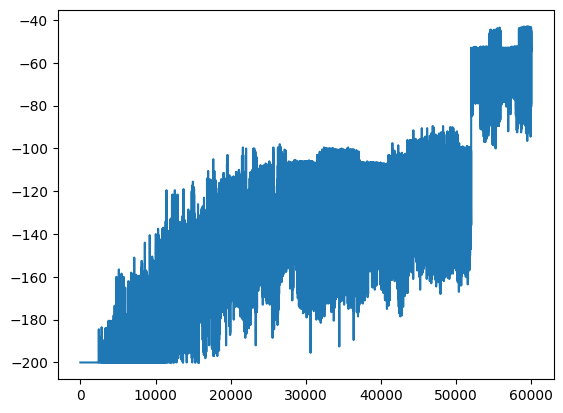

In [ ]:
env_name = 'MountainCar-v0'
n_episodes = 60000
n_bins = (50, 50)  # Position and velocity discretization
learning_rate=0.1
discount_factor=0.99  # Slightly reduced emphasis on long-term rewards

initial_temp=10.0
temp_decay=0.995
min_temp=0.005

q_agent, q_rewards, q_lengths = train_q_learning(env_name, n_episodes, n_bins,learning_rate,discount_factor,initial_temp,temp_decay,min_temp,n_runs=2)
plt.plot(q_rewards)

Starting Q-learning
Run:0 Episode 1000/60000, Avg Reward: -200.00, Temperature: 0.0665
Run:0 Episode 2000/60000, Avg Reward: -199.76, Temperature: 0.0050
Run:0 Episode 3000/60000, Avg Reward: -196.68, Temperature: 0.0050
Run:0 Episode 4000/60000, Avg Reward: -191.02, Temperature: 0.0050
Run:0 Episode 5000/60000, Avg Reward: -191.29, Temperature: 0.0050
Run:0 Episode 6000/60000, Avg Reward: -177.22, Temperature: 0.0050
Run:0 Episode 7000/60000, Avg Reward: -170.55, Temperature: 0.0050
Run:0 Episode 8000/60000, Avg Reward: -173.51, Temperature: 0.0050
Run:0 Episode 9000/60000, Avg Reward: -169.02, Temperature: 0.0050
Run:0 Episode 10000/60000, Avg Reward: -141.69, Temperature: 0.0050
Run:0 Episode 11000/60000, Avg Reward: -150.48, Temperature: 0.0050
Run:0 Episode 12000/60000, Avg Reward: -169.94, Temperature: 0.0050
Run:0 Episode 13000/60000, Avg Reward: -166.39, Temperature: 0.0050
Run:0 Episode 14000/60000, Avg Reward: -146.90, Temperature: 0.0050
Run:0 Episode 15000/60000, Avg Reward

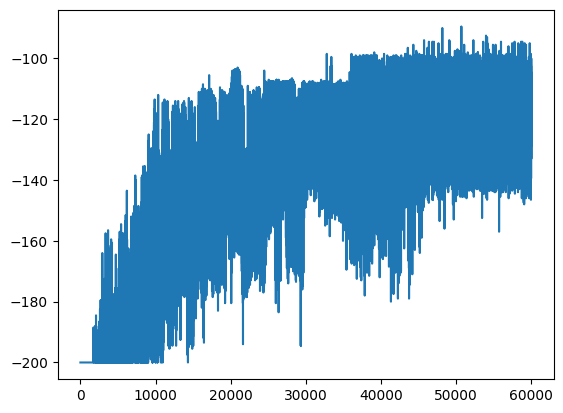

In [ ]:
env_name = 'MountainCar-v0'
n_episodes = 60000
n_bins = (40, 40)  # Position and velocity discretization
learning_rate=0.1
discount_factor=0.998  # Slightly reduced emphasis on long-term rewards

initial_temp=10.0
temp_decay=0.995
min_temp=0.005

q_agent, q_rewards, q_lengths = train_q_learning(env_name, n_episodes, n_bins,learning_rate,discount_factor,initial_temp,temp_decay,min_temp,n_runs=2)
plt.plot(q_rewards)

In [ ]:
import numpy as np
import gymnasium as gym
from collections import deque

def train_q_learning(env_name='MountainCar-v0', n_episodes=1000, n_bins=(20, 20),
                     learning_rate=0.1, discount_factor=0.99, initial_temp=1.0,
                     temp_decay=0.99, min_temp=0.01, n_runs=5):
    """Train Q-learning agent on MountainCar environment with valid run averaging and std deviation tracking."""

    print("Starting Q-learning")
    env = gym.make(env_name)
    wrapper = DiscretizationWrapper(env, n_bins)

    n_states = np.prod(n_bins)
    n_actions = env.action_space.n

    avg_run_rewards = np.zeros(n_episodes, dtype=np.float32)  # Sum of rewards
    avg_run_lengths = np.zeros(n_episodes, dtype=np.float32)  # Sum of lengths
    valid_counts = np.zeros(n_episodes, dtype=np.int32)  # Track valid contributions

    all_rewards = np.full((n_runs, n_episodes), np.nan, dtype=np.float32)  # Store rewards per run

    for run in range(n_runs):
        agent = QLearningAgent(n_states, n_actions, learning_rate, discount_factor,
                               initial_temp, temp_decay, min_temp)

        episode_rewards = np.zeros(n_episodes, dtype=np.float32)  # Store rewards per episode
        episode_lengths = np.zeros(n_episodes, dtype=np.int32)  # Store lengths per episode
        avg_rewards = deque(maxlen=100)  # Store last 100 rewards

        for episode in range(n_episodes):
            observation, _ = env.reset()
            state = wrapper.discretize(observation)

            episode_reward = 0
            episode_length = 0
            done = False
            truncated = False

            while not (done or truncated):
                action = agent.select_action(state)
                next_observation, reward, done, truncated, _ = env.step(action)
                next_state = wrapper.discretize(next_observation)

                agent.update(state, action, reward, next_state, done or truncated)
                state = next_state

                episode_reward += reward
                episode_length += 1

            agent.decay_temperature()

            episode_rewards[episode] = episode_reward
            episode_lengths[episode] = episode_length
            avg_rewards.append(episode_reward)

            if (episode + 1) % 1000 == 0:
                avg_reward = np.mean(avg_rewards)
                print(f"Run:{run} Episode {episode+1}/{n_episodes}, Avg Reward: {avg_reward:.2f}, Temperature: {agent.temperature:.4f}")
                if avg_reward >= -110:
                    print(f"Environment solved in {episode+1} episodes!")
                    break

        # Store valid rewards and count valid entries
        for ep in range(n_episodes):
            if episode_rewards[ep] != 0:  # Avoid counting unvisited episodes
                avg_run_rewards[ep] += episode_rewards[ep]
                avg_run_lengths[ep] += episode_lengths[ep]
                valid_counts[ep] += 1
                all_rewards[run, ep] = episode_rewards[ep]  # Store for std computation

    env.close()

    # Compute average only where at least one run contributed
    avg_rewards_final = np.divide(avg_run_rewards, valid_counts, where=valid_counts > 0)
    avg_lengths_final = np.divide(avg_run_lengths, valid_counts, where=valid_counts > 0)

    # Compute standard deviation (ignoring NaN values)
    std_rewards_final = np.nanstd(all_rewards, axis=0)

    return agent, avg_rewards_final, avg_lengths_final, std_rewards_final


Starting Q-learning
Run:0 Episode 1000/60000, Avg Reward: -200.00, Temperature: 0.0665
Run:0 Episode 2000/60000, Avg Reward: -199.95, Temperature: 0.0050
Run:0 Episode 3000/60000, Avg Reward: -199.21, Temperature: 0.0050
Run:0 Episode 4000/60000, Avg Reward: -199.14, Temperature: 0.0050
Run:0 Episode 5000/60000, Avg Reward: -188.75, Temperature: 0.0050
Run:0 Episode 6000/60000, Avg Reward: -193.96, Temperature: 0.0050
Run:0 Episode 7000/60000, Avg Reward: -177.65, Temperature: 0.0050
Run:0 Episode 8000/60000, Avg Reward: -170.61, Temperature: 0.0050
Run:0 Episode 9000/60000, Avg Reward: -149.80, Temperature: 0.0050
Run:0 Episode 10000/60000, Avg Reward: -161.54, Temperature: 0.0050
Run:0 Episode 11000/60000, Avg Reward: -161.86, Temperature: 0.0050
Run:0 Episode 12000/60000, Avg Reward: -141.38, Temperature: 0.0050
Run:0 Episode 13000/60000, Avg Reward: -143.30, Temperature: 0.0050
Run:0 Episode 14000/60000, Avg Reward: -136.92, Temperature: 0.0050
Run:0 Episode 15000/60000, Avg Reward

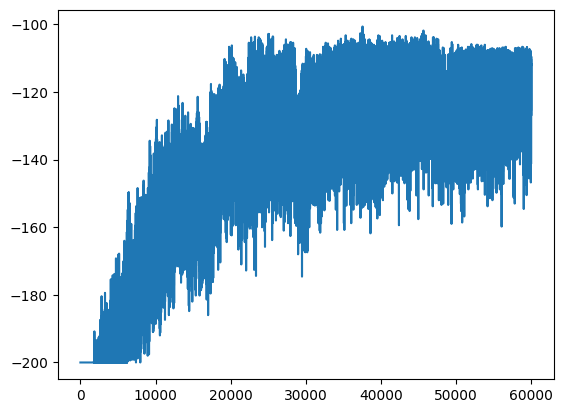

In [ ]:
env_name = 'MountainCar-v0'
n_episodes = 60000
n_bins = (40, 40)  # Position and velocity discretization
learning_rate=0.1
discount_factor=0.99  # Slightly reduced emphasis on long-term rewards

initial_temp=10.0
temp_decay=0.995
min_temp=0.005

q_agent, q_rewards, q_lengths, q_std_rewards = train_q_learning(env_name, n_episodes, n_bins,learning_rate,discount_factor,initial_temp,temp_decay,min_temp,n_runs=5)
plt.plot(q_rewards)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mean_std(avg_rewards, std_rewards, title="Training Performance", ylabel="Reward"):
    """
    Plot the mean rewards with a shaded standard deviation area.

    Parameters:
        avg_rewards (array-like): Mean rewards over episodes.
        std_rewards (array-like): Standard deviation of rewards over episodes.
        title (str): Title of the plot.
        ylabel (str): Label for the y-axis.
    """
    episodes = np.arange(len(avg_rewards))

    plt.figure(figsize=(10, 5))
    plt.plot(episodes, avg_rewards, label="Mean Reward", color="b", linewidth=2)
    plt.fill_between(episodes, avg_rewards - std_rewards, avg_rewards + std_rewards,
                     color="b", alpha=0.2, label="±1 Std Dev")

    plt.xlabel("Episodes")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True,  alpha=0.6)
    plt.show()


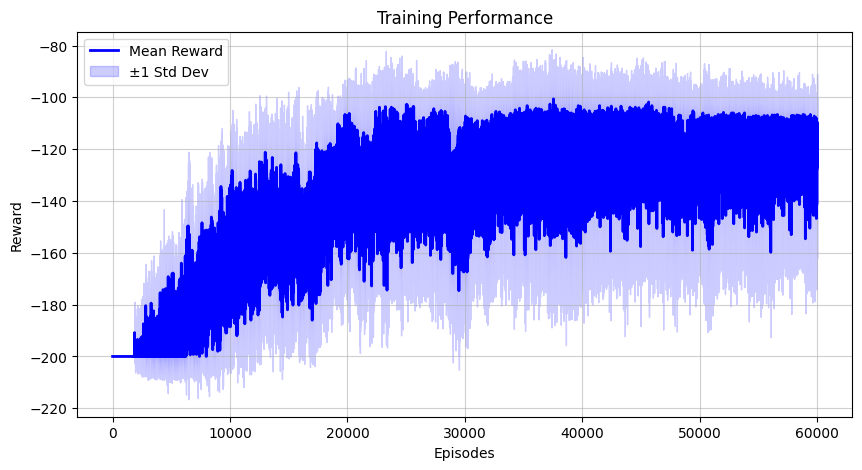

In [ ]:
plot_mean_std(q_rewards, q_std_rewards)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_running_average(rewards, window_size=100, title="Running Average of Rewards", ylabel="Reward"):
    """
    Plot the running average (moving average) of rewards over episodes.

    Parameters:
        rewards (array-like): Rewards over episodes.
        window_size (int): Number of episodes to compute running average.
        title (str): Title of the plot.
        ylabel (str): Label for the y-axis.
    """
    episodes = np.arange(len(rewards))

    # Compute running average using a moving window
    running_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')

    plt.figure(figsize=(10, 5))
    plt.plot(episodes, rewards, label="Original Rewards", color="gray", alpha=0.4)
    plt.plot(episodes[:len(running_avg)], running_avg, label=f"Running Avg ({window_size} episodes)", color="b", linewidth=2)

    plt.xlabel("Episodes")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()


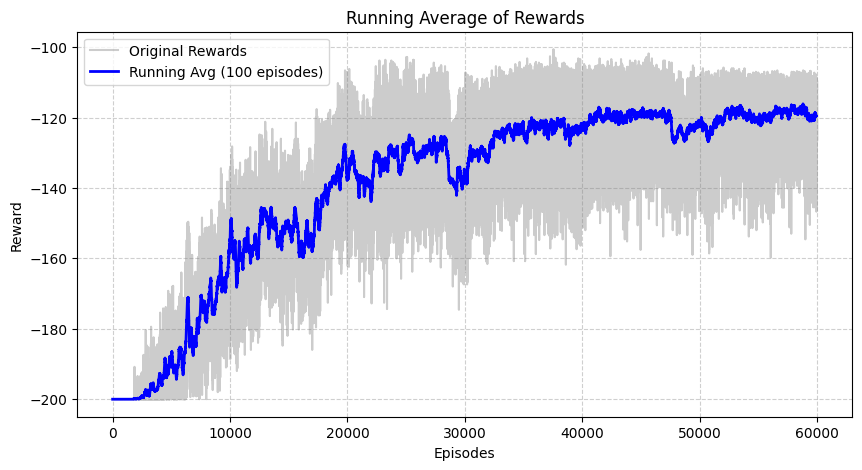

In [ ]:
plot_running_average(q_rewards)

Starting Q-learning
Run:0 Episode 1000/100000, Avg Reward: -200.00, Temperature: 0.0665
Run:0 Episode 2000/100000, Avg Reward: -200.00, Temperature: 0.0050
Run:0 Episode 3000/100000, Avg Reward: -199.02, Temperature: 0.0050
Run:0 Episode 4000/100000, Avg Reward: -194.13, Temperature: 0.0050
Run:0 Episode 5000/100000, Avg Reward: -184.81, Temperature: 0.0050
Run:0 Episode 6000/100000, Avg Reward: -180.02, Temperature: 0.0050
Run:0 Episode 7000/100000, Avg Reward: -175.05, Temperature: 0.0050
Run:0 Episode 8000/100000, Avg Reward: -182.70, Temperature: 0.0050
Run:0 Episode 9000/100000, Avg Reward: -146.59, Temperature: 0.0050
Run:0 Episode 10000/100000, Avg Reward: -152.77, Temperature: 0.0050
Run:0 Episode 11000/100000, Avg Reward: -159.29, Temperature: 0.0050
Run:0 Episode 12000/100000, Avg Reward: -171.07, Temperature: 0.0050
Run:0 Episode 13000/100000, Avg Reward: -147.30, Temperature: 0.0050
Run:0 Episode 14000/100000, Avg Reward: -163.64, Temperature: 0.0050
Run:0 Episode 15000/100

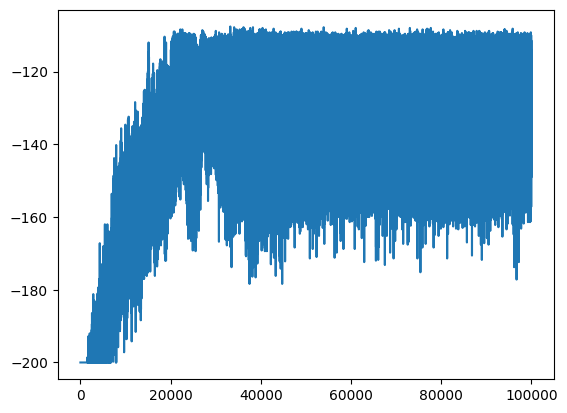

In [ ]:
env_name = 'MountainCar-v0'
n_episodes = 100000
n_bins = (40, 40)  # Position and velocity discretization
learning_rate=0.1
discount_factor=0.99  # Slightly reduced emphasis on long-term rewards

initial_temp=10.0
temp_decay=0.995
min_temp=0.005

q_agent, q_rewards, q_lengths, q_std_rewards = train_q_learning(env_name, n_episodes, n_bins,learning_rate,discount_factor,initial_temp,temp_decay,min_temp,n_runs=5)
plt.plot(q_rewards)

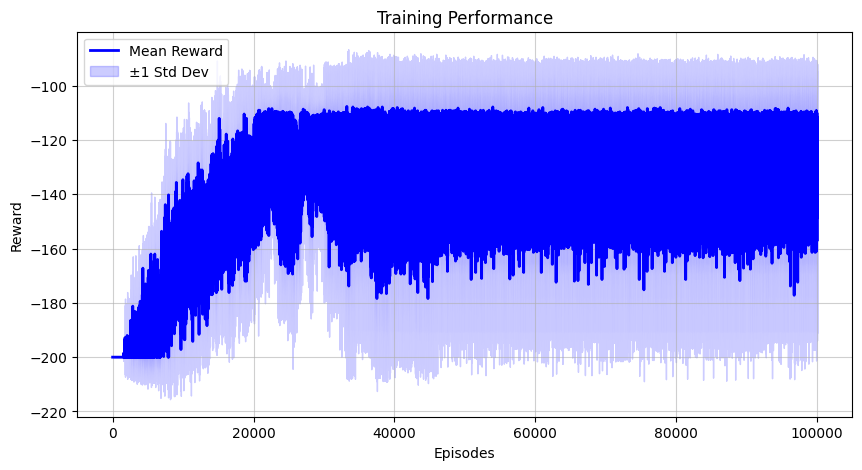

In [ ]:
plot_mean_std(q_rewards, q_std_rewards)

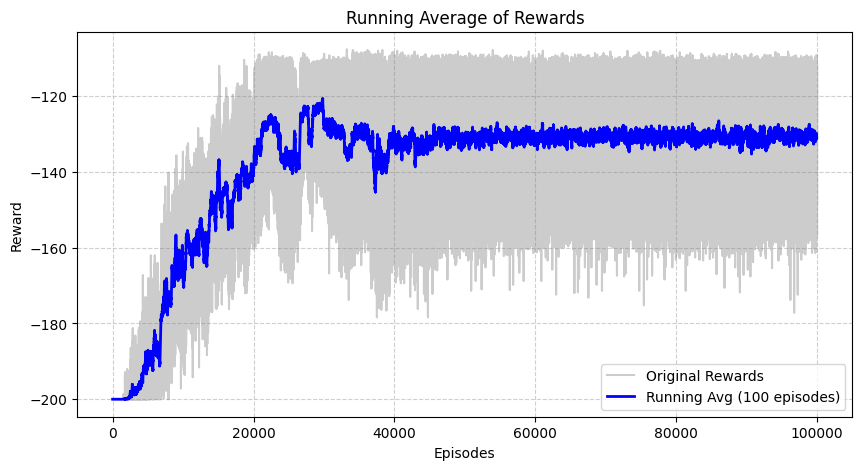

In [ ]:
plot_running_average(q_rewards)

In [ ]:
import numpy as np
import gymnasium as gym
from collections import deque

def train_q_learning(env_name='MountainCar-v0', n_episodes=1000, n_bins=(20, 20),
                     learning_rate=0.1, discount_factor=0.99, initial_temp=1.0,
                     temp_decay=0.99, min_temp=0.01, n_runs=5):
    """Train Q-learning agent on MountainCar environment with valid run averaging and std deviation tracking."""

    print("Starting Q-learning")
    env = gym.make(env_name)
    wrapper = DiscretizationWrapper(env, n_bins)

    n_states = np.prod(n_bins)
    n_actions = env.action_space.n

    avg_run_rewards = np.zeros(n_episodes, dtype=np.float32)  # Sum of rewards
    avg_run_lengths = np.zeros(n_episodes, dtype=np.float32)  # Sum of lengths
    valid_counts = np.zeros(n_episodes, dtype=np.int32)  # Track valid contributions

    all_rewards = np.full((n_runs, n_episodes), np.nan, dtype=np.float32)  # Store rewards per run

    for run in range(n_runs):
        agent = QLearningAgent(n_states, n_actions, learning_rate, discount_factor,
                               initial_temp, temp_decay, min_temp)

        episode_rewards = np.zeros(n_episodes, dtype=np.float32)  # Store rewards per episode
        episode_lengths = np.zeros(n_episodes, dtype=np.int32)  # Store lengths per episode
        avg_rewards = deque(maxlen=100)  # Store last 100 rewards

        for episode in range(n_episodes):
            observation, _ = env.reset()
            state = wrapper.discretize(observation)

            episode_reward = 0
            episode_length = 0
            done = False
            truncated = False

            while not (done or truncated):
                action = agent.select_action(state)
                next_observation, reward, done, truncated, _ = env.step(action)
                next_state = wrapper.discretize(next_observation)

                agent.update(state, action, reward, next_state, done or truncated)
                state = next_state

                episode_reward += reward
                episode_length += 1

            agent.decay_temperature()

            episode_rewards[episode] = episode_reward
            episode_lengths[episode] = episode_length
            avg_rewards.append(episode_reward)

            avg_reward = np.mean(avg_rewards)
            if len(avg_rewards) == 100 and avg_reward >= -110:
                print(f"Run:{run} Episode {episode+1}/{n_episodes}, Avg Reward: {avg_reward:.2f}, Temperature: {agent.temperature:.4f}")
                print(f"Environment solved in {episode+1} episodes!")
                episode_rewards[episode+1:] = -110  # Fill remaining rewards
                break
            if (episode + 1) % 1000 == 0:
                print(f"Run:{run} Episode {episode+1}/{n_episodes}, Avg Reward: {avg_reward:.2f}, Temperature: {agent.temperature:.4f}")

        # Store valid rewards and count valid entries
        for ep in range(n_episodes):
            if episode_rewards[ep] != 0:  # Avoid counting unvisited episodes
                avg_run_rewards[ep] += episode_rewards[ep]
                avg_run_lengths[ep] += episode_lengths[ep]
                valid_counts[ep] += 1
                all_rewards[run, ep] = episode_rewards[ep]  # Store for std computation

    env.close()

    # Compute average only where at least one run contributed
    avg_rewards_final = np.divide(avg_run_rewards, valid_counts, where=valid_counts > 0)
    avg_lengths_final = np.divide(avg_run_lengths, valid_counts, where=valid_counts > 0)

    # Compute standard deviation (ignoring NaN values)
    std_rewards_final = np.nanstd(all_rewards, axis=0)

    return agent, avg_rewards_final, avg_lengths_final, std_rewards_final


#### One good

Starting Q-learning
Run:0 Episode 1000/100000, Avg Reward: -200.00, Temperature: 0.0665
Run:0 Episode 2000/100000, Avg Reward: -200.00, Temperature: 0.0050
Run:0 Episode 3000/100000, Avg Reward: -199.99, Temperature: 0.0050
Run:0 Episode 4000/100000, Avg Reward: -199.65, Temperature: 0.0050
Run:0 Episode 5000/100000, Avg Reward: -196.98, Temperature: 0.0050
Run:0 Episode 6000/100000, Avg Reward: -196.31, Temperature: 0.0050
Run:0 Episode 7000/100000, Avg Reward: -195.66, Temperature: 0.0050
Run:0 Episode 8000/100000, Avg Reward: -191.71, Temperature: 0.0050
Run:0 Episode 9000/100000, Avg Reward: -187.10, Temperature: 0.0050
Run:0 Episode 10000/100000, Avg Reward: -177.59, Temperature: 0.0050
Run:0 Episode 11000/100000, Avg Reward: -176.36, Temperature: 0.0050
Run:0 Episode 12000/100000, Avg Reward: -168.86, Temperature: 0.0050
Run:0 Episode 13000/100000, Avg Reward: -148.76, Temperature: 0.0050
Run:0 Episode 14000/100000, Avg Reward: -162.95, Temperature: 0.0050
Run:0 Episode 15000/100

/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


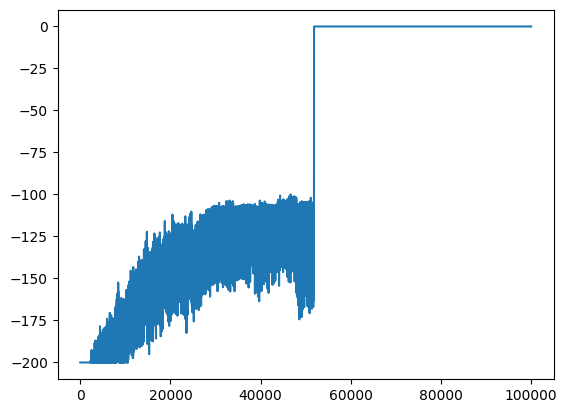

In [ ]:
env_name = 'MountainCar-v0'
n_episodes = 100000
n_bins = (50, 50)  # Position and velocity discretization
learning_rate=0.1
discount_factor=0.99  # Slightly reduced emphasis on long-term rewards

initial_temp=10.0
temp_decay=0.995
min_temp=0.005

q_agent, q_rewards, q_lengths, q_std_rewards = train_q_learning(env_name, n_episodes, n_bins,learning_rate,discount_factor,initial_temp,temp_decay,min_temp,n_runs=5)
plt.plot(q_rewards)

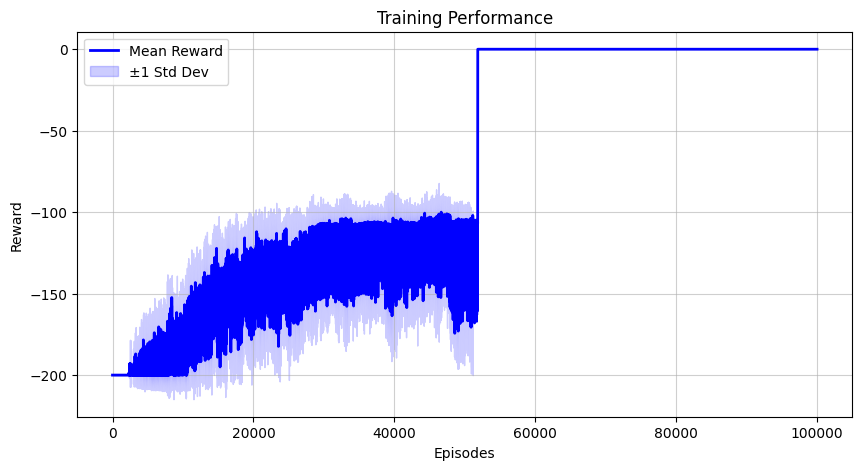

In [ ]:
plot_mean_std(q_rewards, q_std_rewards)

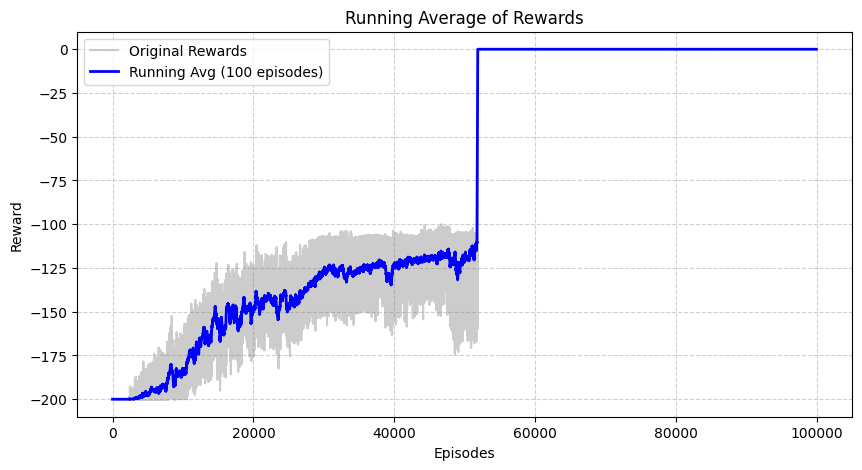

In [ ]:
plot_running_average(q_rewards)

In [ ]:
q_rewards

array([-200., -200., -200., ...,    0.,    0.,    0.])

In [ ]:
import pickle
with open("QLearning_data.pkl", "wb") as f:
    pickle.dump((q_agent, q_rewards, q_lengths, q_std_rewards), f)

In [ ]:
q_lengths

array([200., 200., 200., ...,   0.,   0.,   0.])

In [ ]:
q_rewards_mod = [-110 if x == 0 else x for x in q_rewards]

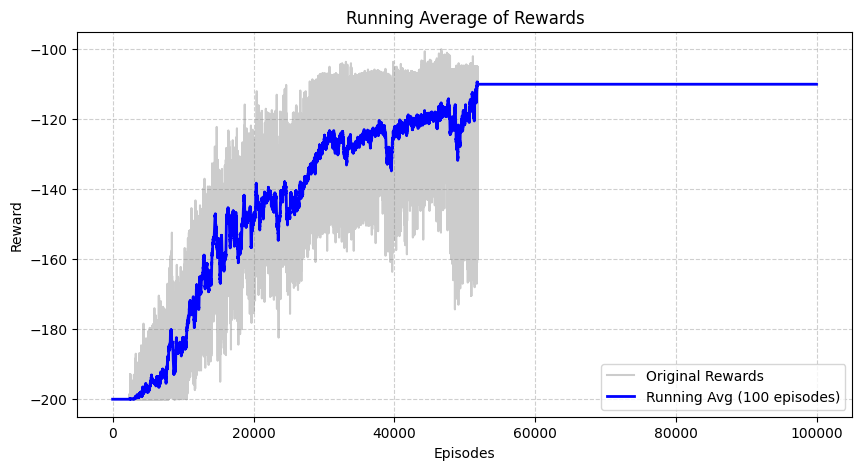

In [ ]:
plot_running_average(lst)

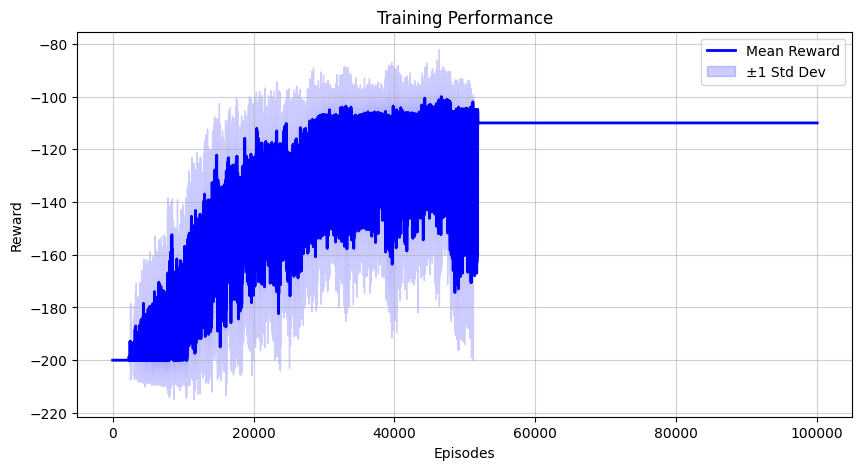

In [ ]:
import wandb
import numpy as np

# Initialize a new run
wandb.init(
    project="Q_learning-mountain_car",
    config={
        "vel_n_bins": 50,
        "pos_n_bins": 50,
        "learning_rate": 0.1,
        "n_episodes": 60000,
        "discount_factor": 0.99,
        "initial_temp": 10,
        "temp_decay": 0.995,
        "min_temp": 0.005,
    }
)

cumulative_regret = 0

# Log custom metrics
for step in range(60000):
    instantanious_regret = -110 - q_rewards_mod[step]
    cumulative_regret += instantanious_regret

    wandb.log({
        "instantanious_regret": instantanious_regret,
        "cumulative_regret": cumulative_regret,
        "reward": q_rewards_mod[step]
    })

# Compute the final running average reward safely
final_avg_reward = np.mean(q_rewards_mod[-min(len(q_rewards_mod), 100):])
wandb.log({"final_avg_reward": final_avg_reward})

wandb.finish()


cumulative_regret,▁▁▁▁▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████
final_avg_reward,▁
instantanious_regret,███████▇▅▄▅▂▄▄▄▃▁▃▂▂▂▃▄▃▂▂▂▂▂▃▂▄▂▃▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▂▂▄▅▅▅▆▆▅▆▆▆▇▇▇▆▇▇▇▇▇▇▇▆▅██▇▇████
cumulative_regret,1945846.43333
final_avg_reward,-110
instantanious_regret,0
reward,-110


In [ ]:
env_name = 'MountainCar-v0'
n_episodes = 100000
n_bins = (27, 27)  # Position and velocity discretization
learning_rate=0.154569646270044
discount_factor=0.9707626615463272  # Slightly reduced emphasis on long-term rewards

initial_temp=7.152451331133418
temp_decay=0.9480371780438288
min_temp=0.005

q_agent, q_rewards, q_lengths, q_std_rewards = train_q_learning(env_name, n_episodes, n_bins,learning_rate,discount_factor,initial_temp,temp_decay,min_temp,n_runs=5)
plt.plot(q_rewards)

Starting Q-learning
Run:0 Episode 1000/100000, Avg Reward: -196.81, Temperature: 0.0050
Run:0 Episode 2000/100000, Avg Reward: -181.18, Temperature: 0.0050
Run:0 Episode 3000/100000, Avg Reward: -172.57, Temperature: 0.0050
Run:0 Episode 4000/100000, Avg Reward: -167.82, Temperature: 0.0050
Run:0 Episode 5000/100000, Avg Reward: -132.85, Temperature: 0.0050
Run:0 Episode 6000/100000, Avg Reward: -161.82, Temperature: 0.0050
Run:0 Episode 7000/100000, Avg Reward: -158.23, Temperature: 0.0050
Run:0 Episode 8000/100000, Avg Reward: -180.58, Temperature: 0.0050
Run:0 Episode 9000/100000, Avg Reward: -152.69, Temperature: 0.0050
Run:0 Episode 10000/100000, Avg Reward: -144.75, Temperature: 0.0050
Run:0 Episode 11000/100000, Avg Reward: -143.60, Temperature: 0.0050
Run:0 Episode 12000/100000, Avg Reward: -141.66, Temperature: 0.0050
Run:0 Episode 13000/100000, Avg Reward: -146.73, Temperature: 0.0050
Run:0 Episode 14000/100000, Avg Reward: -159.47, Temperature: 0.0050
Run:0 Episode 15000/100

KeyboardInterrupt: 

In [ ]:

wandb.log({
            "episode": episode,
            "reward": episode_reward,
            "length": episode_length,
            "temperature": agent.temperature,
            "avg_reward": avg_reward,
            "instantanious_regret": instantanious_regret,
            "cumulative_regret":cumulative_regret
        })



"metric": {"name": "final_avg_reward", "goal": "maximize"},
    "parameters": {
        "n_episodes": {"values": [2000,3000, 5000, 10000]},
        # "n_bins": {"values": [(10, 10), (18, 14), (20, 20), (25, 25), (30, 30), (40, 40), (50, 50), (60, 60), (70, 70)]},
        "vel_n_bins": {"values": list(range(15, 60, 2))},
        "pos_n_bins": {"values": list(range(15, 60, 2))},

        "learning_rate": {"distribution": "log_uniform_values", "min": 1e-4, "max": 0.5},
        "discount_factor": {"distribution": "uniform", "min": 0.9, "max": 1.0},
        "initial_temp": {"distribution": "uniform", "min": 0.05, "max": 10.0},
        "temp_decay": {"distribution": "log_uniform_values", "min": 0.9, "max": 0.999},
        "min_temp": {"distribution": "uniform", "min": 0.0001, "max": 0.1},
    }

In [ ]:
n_episodes = 100000
n_bins = (50, 50)  # Position and velocity discretization
learning_rate=0.1
discount_factor=0.99  # Slightly reduced emphasis on long-term rewards

initial_temp=10.0
temp_decay=0.995
min_temp=0.005

### Train Q function

In [ ]:
import numpy as np
import gymnasium as gym
from collections import deque

def train_q_learning(env_name='MountainCar-v0', n_episodes=1000, n_bins=(20, 20),
                     learning_rate=0.1, discount_factor=0.99, initial_temp=1.0,
                     temp_decay=0.99, min_temp=0.01, n_runs=5):
    """Train Q-learning agent on MountainCar environment with valid run averaging and std deviation tracking."""

    print("Starting Q-learning")
    env = gym.make(env_name)
    wrapper = DiscretizationWrapper(env, n_bins)

    n_states = np.prod(n_bins)
    n_actions = env.action_space.n

    avg_run_rewards = np.zeros(n_episodes, dtype=np.float32)  # Sum of rewards
    avg_run_lengths = np.zeros(n_episodes, dtype=np.float32)  # Sum of lengths

    all_rewards = np.full((n_runs, n_episodes), np.nan, dtype=np.float32)  # Store rewards per run

    for run in range(n_runs):
        agent = QLearningAgent(n_states, n_actions, learning_rate, discount_factor,
                               initial_temp, temp_decay, min_temp)

        episode_rewards = np.zeros(n_episodes, dtype=np.float32)  # Store rewards per episode
        episode_lengths = np.zeros(n_episodes, dtype=np.int32)  # Store lengths per episode
        avg_rewards = deque(maxlen=100)  # Store last 100 rewards

        for episode in range(n_episodes):
            observation, _ = env.reset()
            state = wrapper.discretize(observation)

            episode_reward = 0
            episode_length = 0
            done = False
            truncated = False

            while not (done or truncated):
                action = agent.select_action(state)
                next_observation, reward, done, truncated, _ = env.step(action)
                next_state = wrapper.discretize(next_observation)

                agent.update(state, action, reward, next_state, done or truncated)
                state = next_state

                episode_reward += reward
                episode_length += 1

            agent.decay_temperature()

            episode_rewards[episode] = episode_reward
            episode_lengths[episode] = episode_length
            avg_rewards.append(episode_reward)
            all_rewards[run, episode] = episode_reward  # Store for std computation

            if (episode + 1) % 1000 == 0:
                avg_reward = np.mean(avg_rewards)
                print(f"Run:{run} Episode {episode+1}/{n_episodes}, Avg Reward: {avg_reward:.2f}, Temperature: {agent.temperature:.4f}")

            if len(avg_rewards) == 100 and np.mean(avg_rewards) >= -110:
                print(f"Environment solved in {episode+1} episodes!")
                episode_rewards[episode+1:] = -110  # Fill remaining rewards
                break  # Stop further training

        avg_run_rewards += episode_rewards
        avg_run_lengths += episode_lengths

    env.close()

    # Compute average
    avg_rewards_final = avg_run_rewards / n_runs
    avg_lengths_final = avg_run_lengths / n_runs

    # Compute standard deviation (ignoring NaN values)
    std_rewards_final = np.nanstd(all_rewards, axis=0)

    return agent, avg_rewards_final, avg_lengths_final, std_rewards_final


In [ ]:
env_name = 'MountainCar-v0'
n_episodes = 100000
n_bins = (40, 40)  # Position and velocity discretization
learning_rate=0.1
discount_factor=0.995  # Slightly reduced emphasis on long-term rewards

initial_temp=10.0
temp_decay=0.995
min_temp=0.005

q_agent, q_rewards, q_lengths, q_std_rewards = train_q_learning(env_name, n_episodes, n_bins,learning_rate,discount_factor,initial_temp,temp_decay,min_temp,n_runs=5)
plt.plot(q_rewards)

Starting Q-learning
Run:0 Episode 1000/100000, Avg Reward: -200.00, Temperature: 0.0665
Run:0 Episode 2000/100000, Avg Reward: -200.00, Temperature: 0.0050
Run:0 Episode 3000/100000, Avg Reward: -196.35, Temperature: 0.0050
Run:0 Episode 4000/100000, Avg Reward: -190.57, Temperature: 0.0050
Run:0 Episode 5000/100000, Avg Reward: -192.60, Temperature: 0.0050
Run:0 Episode 6000/100000, Avg Reward: -174.21, Temperature: 0.0050
Run:0 Episode 7000/100000, Avg Reward: -177.65, Temperature: 0.0050
Run:0 Episode 8000/100000, Avg Reward: -164.56, Temperature: 0.0050
Run:0 Episode 9000/100000, Avg Reward: -169.21, Temperature: 0.0050
Run:0 Episode 10000/100000, Avg Reward: -169.26, Temperature: 0.0050
Run:0 Episode 11000/100000, Avg Reward: -161.70, Temperature: 0.0050
Run:0 Episode 12000/100000, Avg Reward: -142.27, Temperature: 0.0050
Run:0 Episode 13000/100000, Avg Reward: -168.45, Temperature: 0.0050
Run:0 Episode 14000/100000, Avg Reward: -162.18, Temperature: 0.0050
Run:0 Episode 15000/100

In [ ]:
env_name = 'MountainCar-v0'
n_episodes = 100000
n_bins = (60, 60)  # Position and velocity discretization
learning_rate=0.1
discount_factor=0.995  # Slightly reduced emphasis on long-term rewards

initial_temp=20.0
temp_decay=0.995
min_temp=0.005

q_agent, q_rewards, q_lengths, q_std_rewards = train_q_learning(env_name, n_episodes, n_bins,learning_rate,discount_factor,initial_temp,temp_decay,min_temp,n_runs=5)
plt.plot(q_rewards)

Starting Q-learning


KeyboardInterrupt: 

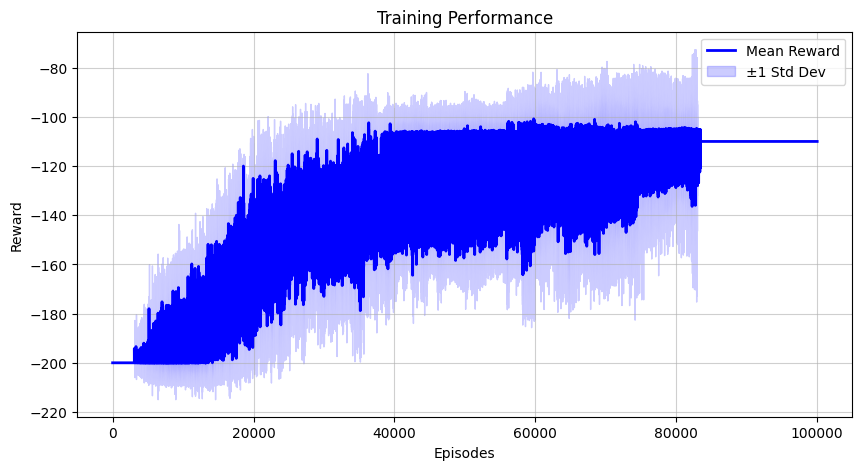

In [ ]:
plot_mean_std(q_rewards, q_std_rewards)

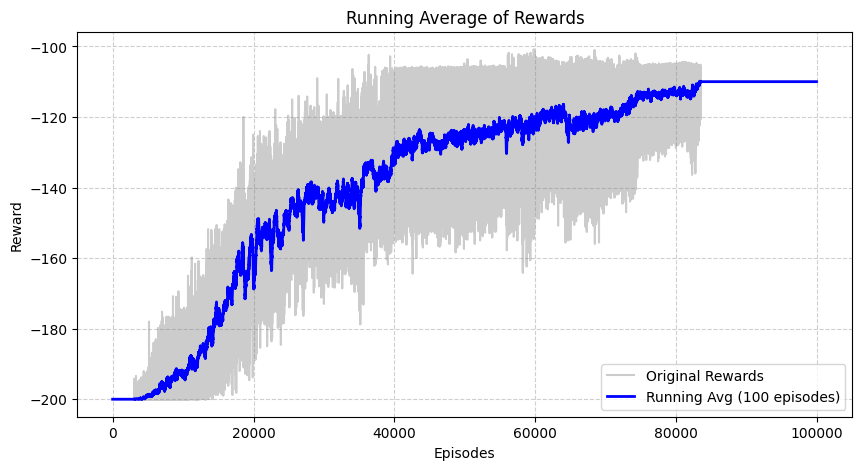

In [ ]:
plot_running_average(q_rewards)

In [ ]:
import pickle
with open("QLearning_data.pkl", "wb") as f:
    pickle.dump((q_agent, q_rewards, q_lengths, q_std_rewards), f)

In [ ]:
env_name = 'MountainCar-v0'
n_episodes = 100000
n_bins = (40, 40)  # Position and velocity discretization
learning_rate=0.1
discount_factor=0.995  # Slightly reduced emphasis on long-term rewards

initial_temp=20.0
temp_decay=0.995
min_temp=0.005

q_agent, q_rewards, q_lengths, q_std_rewards = train_q_learning(env_name, n_episodes, n_bins,learning_rate,discount_factor,initial_temp,temp_decay,min_temp,n_runs=5)
plt.plot(q_rewards)

Starting Q-learning
Run:0 Episode 1000/100000, Avg Reward: -200.00, Temperature: 0.1331
Run:0 Episode 2000/100000, Avg Reward: -200.00, Temperature: 0.0050
Run:0 Episode 3000/100000, Avg Reward: -198.50, Temperature: 0.0050
Run:0 Episode 4000/100000, Avg Reward: -197.66, Temperature: 0.0050
Run:0 Episode 5000/100000, Avg Reward: -184.98, Temperature: 0.0050
Run:0 Episode 6000/100000, Avg Reward: -180.86, Temperature: 0.0050
Run:0 Episode 7000/100000, Avg Reward: -187.08, Temperature: 0.0050
Run:0 Episode 8000/100000, Avg Reward: -176.38, Temperature: 0.0050
Run:0 Episode 9000/100000, Avg Reward: -152.72, Temperature: 0.0050
Run:0 Episode 10000/100000, Avg Reward: -162.24, Temperature: 0.0050
Run:0 Episode 11000/100000, Avg Reward: -152.48, Temperature: 0.0050
Run:0 Episode 12000/100000, Avg Reward: -144.78, Temperature: 0.0050
Run:0 Episode 13000/100000, Avg Reward: -161.60, Temperature: 0.0050
Run:0 Episode 14000/100000, Avg Reward: -135.65, Temperature: 0.0050
Run:0 Episode 15000/100

KeyboardInterrupt: 

In [ ]:
best_hyperparams = {
    'n_bins': (30, 30),          # State discretization (position, velocity)
    'learning_rate': 0.25,       # Aggressive learning rate for faster updates
    'discount_factor': 0.99,     # Strong future reward consideration
    'initial_temp': 2.0,         # High initial exploration
    'temp_decay': 0.9995,        # Slow exponential decay
    'min_temp': 0.01,            # Maintain minimal exploration
    'n_episodes': 5000,          # Sufficient training time
    'n_runs': 5                  # Statistical significance
}

In [ ]:
trained_agent, avg_rewards, avg_lengths, std_rewards = train_q_learning(
    env_name='MountainCar-v0',
    n_bins=best_hyperparams['n_bins'],
    learning_rate=best_hyperparams['learning_rate'],
    discount_factor=best_hyperparams['discount_factor'],
    initial_temp=best_hyperparams['initial_temp'],
    temp_decay=best_hyperparams['temp_decay'],
    min_temp=best_hyperparams['min_temp'],
    n_episodes=best_hyperparams['n_episodes'],
    n_runs=best_hyperparams['n_runs']
)

Starting Q-learning
Run:0 Episode 1000/5000, Avg Reward: -200.00, Temperature: 1.2129
Run:0 Episode 2000/5000, Avg Reward: -200.00, Temperature: 0.7356
Run:0 Episode 3000/5000, Avg Reward: -198.13, Temperature: 0.4461
Run:0 Episode 4000/5000, Avg Reward: -181.16, Temperature: 0.2705
Run:0 Episode 5000/5000, Avg Reward: -150.14, Temperature: 0.1641
Run:1 Episode 1000/5000, Avg Reward: -200.00, Temperature: 1.2129
Run:1 Episode 2000/5000, Avg Reward: -199.72, Temperature: 0.7356
Run:1 Episode 3000/5000, Avg Reward: -192.20, Temperature: 0.4461
Run:1 Episode 4000/5000, Avg Reward: -175.26, Temperature: 0.2705
Run:1 Episode 5000/5000, Avg Reward: -186.01, Temperature: 0.1641
Run:2 Episode 1000/5000, Avg Reward: -200.00, Temperature: 1.2129
Run:2 Episode 2000/5000, Avg Reward: -199.71, Temperature: 0.7356
Run:2 Episode 3000/5000, Avg Reward: -195.98, Temperature: 0.4461
Run:2 Episode 4000/5000, Avg Reward: -187.19, Temperature: 0.2705
Run:2 Episode 5000/5000, Avg Reward: -176.40, Temperatur

ValueError: not enough values to unpack (expected 4, got 3)

In [ ]:
optimized_hyperparams = {
    'n_bins': (40, 40),          # Increased state resolution
    'learning_rate': 0.15,       # Reduced for stability
    'discount_factor': 0.999,    # Stronger future reward focus
    'initial_temp': 1.5,         # Balanced initial exploration
    'temp_decay': 0.9992,        # Faster decay schedule
    'min_temp': 0.005,           # Lower minimum temperature
    'n_episodes': 8000,          # Extended training
    'n_runs': 5
}
trained_agent, avg_rewards, avg_lengths, std_rewards = train_q_learning(
    env_name='MountainCar-v0',
    n_bins=optimized_hyperparams['n_bins'],
    learning_rate=optimized_hyperparams['learning_rate'],
    discount_factor=optimized_hyperparams['discount_factor'],
    initial_temp=optimized_hyperparams['initial_temp'],
    temp_decay=optimized_hyperparams['temp_decay'],
    min_temp=optimized_hyperparams['min_temp'],
    n_episodes=optimized_hyperparams['n_episodes'],
    n_runs=optimized_hyperparams['n_runs']
)

Starting Q-learning
Run:0 Episode 1000/8000, Avg Reward: -200.00, Temperature: 0.6738
Run:0 Episode 2000/8000, Avg Reward: -199.74, Temperature: 0.3027
Run:0 Episode 3000/8000, Avg Reward: -189.09, Temperature: 0.1359
Run:0 Episode 4000/8000, Avg Reward: -183.97, Temperature: 0.0611
Run:0 Episode 5000/8000, Avg Reward: -182.58, Temperature: 0.0274
Run:0 Episode 6000/8000, Avg Reward: -185.64, Temperature: 0.0123
Run:0 Episode 7000/8000, Avg Reward: -163.03, Temperature: 0.0055
Run:0 Episode 8000/8000, Avg Reward: -175.74, Temperature: 0.0050
Run:1 Episode 1000/8000, Avg Reward: -200.00, Temperature: 0.6738
Run:1 Episode 2000/8000, Avg Reward: -199.72, Temperature: 0.3027
Run:1 Episode 3000/8000, Avg Reward: -195.58, Temperature: 0.1359
Run:1 Episode 4000/8000, Avg Reward: -188.72, Temperature: 0.0611
Run:1 Episode 5000/8000, Avg Reward: -189.89, Temperature: 0.0274
Run:1 Episode 6000/8000, Avg Reward: -176.91, Temperature: 0.0123
Run:1 Episode 7000/8000, Avg Reward: -160.33, Temperatur

In [ ]:
trained_agent, avg_rewards, avg_lengths, std_rewards = train_q_learning(
    env_name='MountainCar-v0',
    n_bins=(30, 30),  # User-specified bin configuration
    learning_rate=0.1,
    discount_factor=0.999,
    initial_temp=3.0,
    temp_decay=0.9999,
    min_temp=0.001,
    n_episodes=100000,
    n_runs=5
)

Starting Q-learning
Run:0 Episode 1000/100000, Avg Reward: -200.00, Temperature: 2.7145
Run:0 Episode 2000/100000, Avg Reward: -200.00, Temperature: 2.4562
Run:0 Episode 3000/100000, Avg Reward: -200.00, Temperature: 2.2224
Run:0 Episode 4000/100000, Avg Reward: -200.00, Temperature: 2.0109
Run:0 Episode 5000/100000, Avg Reward: -200.00, Temperature: 1.8195
Run:0 Episode 6000/100000, Avg Reward: -200.00, Temperature: 1.6464
Run:0 Episode 7000/100000, Avg Reward: -200.00, Temperature: 1.4897
Run:0 Episode 8000/100000, Avg Reward: -200.00, Temperature: 1.3479
Run:0 Episode 9000/100000, Avg Reward: -200.00, Temperature: 1.2197
Run:0 Episode 10000/100000, Avg Reward: -198.04, Temperature: 1.1036
Run:0 Episode 11000/100000, Avg Reward: -199.93, Temperature: 0.9986
Run:0 Episode 12000/100000, Avg Reward: -194.08, Temperature: 0.9035
Run:0 Episode 13000/100000, Avg Reward: -198.43, Temperature: 0.8175
Run:0 Episode 14000/100000, Avg Reward: -192.89, Temperature: 0.7397
Run:0 Episode 15000/100

KeyboardInterrupt: 

In [ ]:
optimized_q_params = {
    'n_bins': (30, 30),
    'learning_rate': 0.25,        # Increased from 0.1 (faster value propagation)
    'discount_factor': 0.995,     # Reduced from 0.999 (better medium-term focus)
    'initial_temp': 2.0,          # Reduced from 3.0 (focused exploration)
    'temp_decay': 0.9995,         # Faster decay than 0.9999 (0.9999→0.9995)
    'min_temp': 0.005,            # Increased from 0.001 (maintains exploration)
    'n_episodes': 100000,          # Reduced training duration
    'n_runs': 5
}
trained_agent, avg_rewards, avg_lengths, std_rewards = train_q_learning(
    env_name='MountainCar-v0',
    n_bins=optimized_q_params['n_bins'],
    learning_rate=optimized_q_params['learning_rate'],
    discount_factor=optimized_q_params['discount_factor'],
    initial_temp=optimized_q_params['initial_temp'],
    temp_decay=optimized_q_params['temp_decay'],
    min_temp=optimized_q_params['min_temp'],
    n_episodes=optimized_q_params['n_episodes'],
    n_runs=optimized_q_params['n_runs']
)

Starting Q-learning
Run:0 Episode 1000/100000, Avg Reward: -200.00, Temperature: 1.2129
Run:0 Episode 2000/100000, Avg Reward: -199.62, Temperature: 0.7356
Run:0 Episode 3000/100000, Avg Reward: -193.11, Temperature: 0.4461
Run:0 Episode 4000/100000, Avg Reward: -174.56, Temperature: 0.2705
Run:0 Episode 5000/100000, Avg Reward: -160.10, Temperature: 0.1641
Run:0 Episode 6000/100000, Avg Reward: -167.34, Temperature: 0.0995
Run:0 Episode 7000/100000, Avg Reward: -161.21, Temperature: 0.0603
Run:0 Episode 8000/100000, Avg Reward: -140.24, Temperature: 0.0366
Run:0 Episode 9000/100000, Avg Reward: -140.35, Temperature: 0.0222
Run:0 Episode 10000/100000, Avg Reward: -140.73, Temperature: 0.0135
Run:0 Episode 11000/100000, Avg Reward: -141.59, Temperature: 0.0082
Run:0 Episode 12000/100000, Avg Reward: -136.49, Temperature: 0.0050
Run:0 Episode 13000/100000, Avg Reward: -133.67, Temperature: 0.0050
Run:0 Episode 14000/100000, Avg Reward: -134.99, Temperature: 0.0050
Run:0 Episode 15000/100

KeyboardInterrupt: 

In [ ]:
env_name = 'MountainCar-v0'
n_episodes = 100000
n_bins = (70, 70)  # Position and velocity discretization
learning_rate=0.04
discount_factor=0.995  # Slightly reduced emphasis on long-term rewards

initial_temp=20.0
temp_decay=0.995
min_temp=0.005

q_agent, q_rewards, q_lengths, q_std_rewards = train_q_learning(env_name, n_episodes, n_bins,learning_rate,discount_factor,initial_temp,temp_decay,min_temp,n_runs=5)
plt.plot(q_rewards)

Starting Q-learning
Run:0 Episode 1000/100000, Avg Reward: -200.00, Temperature: 0.1331
Run:0 Episode 2000/100000, Avg Reward: -200.00, Temperature: 0.0050
Run:0 Episode 3000/100000, Avg Reward: -200.00, Temperature: 0.0050
Run:0 Episode 4000/100000, Avg Reward: -200.00, Temperature: 0.0050
Run:0 Episode 5000/100000, Avg Reward: -200.00, Temperature: 0.0050
Run:0 Episode 6000/100000, Avg Reward: -200.00, Temperature: 0.0050
Run:0 Episode 7000/100000, Avg Reward: -200.00, Temperature: 0.0050
Run:0 Episode 8000/100000, Avg Reward: -200.00, Temperature: 0.0050
Run:0 Episode 9000/100000, Avg Reward: -200.00, Temperature: 0.0050
Run:0 Episode 10000/100000, Avg Reward: -200.00, Temperature: 0.0050
Run:0 Episode 11000/100000, Avg Reward: -200.00, Temperature: 0.0050
Run:0 Episode 12000/100000, Avg Reward: -200.00, Temperature: 0.0050
Run:0 Episode 13000/100000, Avg Reward: -200.00, Temperature: 0.0050
Run:0 Episode 14000/100000, Avg Reward: -199.79, Temperature: 0.0050
Run:0 Episode 15000/100

KeyboardInterrupt: 

In [ ]:
plot_mean_std(q_rewards, q_std_rewards)
plot_running_average(q_rewards)

## Wanb

In [ ]:
!pip install wandb
!wandb login

wandb: Currently logged in as: cs24m041 (cs24m041-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
import numpy as np
import gymnasium as gym
import wandb
from collections import deque

def train_q_learning():
    """Train Q-learning agent on MountainCar environment with WandB sweep integration (single run)."""

    wandb.init(project="Q_learning-mountain_car")  # Initialize WandB
    config = wandb.config  # Load hyperparameters from WandB sweep

    env_name = "MountainCar-v0"
    n_episodes = config.n_episodes
    n_bins = config.n_bins
    learning_rate = config.learning_rate
    discount_factor = config.discount_factor
    initial_temp = config.initial_temp
    temp_decay = config.temp_decay
    min_temp = config.min_temp

    print(f"Starting Q-learning with {config}")

    env = gym.make(env_name)
    wrapper = DiscretizationWrapper(env, n_bins)

    n_states = np.prod(n_bins)
    n_actions = env.action_space.n

    agent = QLearningAgent(n_states, n_actions, learning_rate, discount_factor,
                           initial_temp, temp_decay, min_temp)

    episode_rewards = np.zeros(n_episodes, dtype=np.float32)
    episode_lengths = np.zeros(n_episodes, dtype=np.int32)
    avg_rewards = deque(maxlen=100)
    cumulative_regret=0
    for episode in range(n_episodes):
        observation, _ = env.reset()
        state = wrapper.discretize(observation)

        episode_reward = 0
        episode_length = 0
        done = False
        truncated = False

        while not (done or truncated):
            action = agent.select_action(state)
            next_observation, reward, done, truncated, _ = env.step(action)
            next_state = wrapper.discretize(next_observation)

            agent.update(state, action, reward, next_state, done or truncated)
            state = next_state

            episode_reward += reward
            episode_length += 1

        agent.decay_temperature()
        episode_rewards[episode] = episode_reward
        episode_lengths[episode] = episode_length
        avg_rewards.append(episode_reward)

        avg_reward = np.mean(avg_rewards) if avg_rewards else episode_reward
        instantanious_regret = -110 - avg_reward  # Regret: difference from optimal (-110)
        cumulative_regret += instantanious_regret

        # Log per-episode metrics to WandB
        wandb.log({
            "episode": episode,
            "reward": episode_reward,
            "length": episode_length,
            "temperature": agent.temperature,
            "avg_reward": avg_reward,
            "instantanious_regret": instantanious_regret,
            "cumulative_regret":cumulative_regret
        })

        if (episode + 1) % 1000 == 0:
            print(f"Episode {episode+1}/{n_episodes}, Avg Reward: {avg_reward:.2f}, Temperature: {agent.temperature:.4f}")

        if len(avg_rewards) == 100 and avg_reward >= -110:
            print(f"Environment solved in {episode+1} episodes!")
            break

    env.close()

    # Final statistics
    final_avg_reward = np.mean(avg_rewards)
    final_cumulative_regret = -110 - final_avg_reward

    # Log final aggregated results
    wandb.log({
        "final_avg_reward": final_avg_reward,
        "final_cumulative_regret": final_cumulative_regret
    })

    wandb.finish()

    return agent, episode_rewards, episode_lengths


In [ ]:
sweep_config = {
    "method": "bayes",
    "metric": {"name": "final_avg_reward", "goal": "maximize"},
    "parameters": {
        "n_episodes": {"values": [3000, 5000, 10000, 20000,50000]},
        "n_bins": {"values": [(10, 10), (18, 14), (20, 20), (25, 25), (30, 30), (40, 40), (50, 50), (60, 60), (70, 70)]},
        "learning_rate": {"distribution": "log_uniform_values", "min": 1e-4, "max": 0.1},
        "discount_factor": {"distribution": "uniform", "min": 0.9, "max": 1.0},
        "initial_temp": {"distribution": "uniform", "min": 0.05, "max": 5.0},
        "temp_decay": {"distribution": "log_uniform_values", "min": 0.98, "max": 0.999},
        "min_temp": {"distribution": "uniform", "min": 0.001, "max": 0.1},
    }
}

sweep_id = wandb.sweep(sweep_config, project="Q_learning-mountain_car")


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: n9005o7g
Sweep URL: https://wandb.ai/cs24m041-iit-madras/Q_learning-mountain_car/sweeps/n9005o7g


In [ ]:
wandb.agent(sweep_id, train_q_learning, count=10)


wandb: Agent Starting Run: cl8vfos1 with config:
wandb: 	discount_factor: 0.9254148327171045
wandb: 	initial_temp: 4.433698810115368
wandb: 	learning_rate: 0.0003676515225150435
wandb: 	min_temp: 0.09562022087805092
wandb: 	n_bins: [10, 10]
wandb: 	n_episodes: 5000
wandb: 	temp_decay: 0.98912832636682
wandb: Currently logged in as: cs24m041 (cs24m041-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Starting Q-learning with {'discount_factor': 0.9254148327171045, 'initial_temp': 4.433698810115368, 'learning_rate': 0.0003676515225150435, 'min_temp': 0.09562022087805092, 'n_bins': [10, 10], 'n_episodes': 5000, 'temp_decay': 0.98912832636682}
Episode 1000/5000, Avg Reward: -200.00, Temperature: 0.0956
Episode 2000/5000, Avg Reward: -200.00, Temperature: 0.0956
Episode 3000/5000, Avg Reward: -200.00, Temperature: 0.0956
Episode 4000/5000, Avg Reward: -200.00, Temperature: 0.0956
Episode 5000/5000, Avg Reward: -200.00, Temperature: 0.0956


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cumulative_regret,▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇████
episode,▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▇▇▇▇▇▇▇██
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-200
cumulative_regret,450000


wandb: Agent Starting Run: 4lt6nk68 with config:
wandb: 	discount_factor: 0.97886926375979
wandb: 	initial_temp: 4.437026465061971
wandb: 	learning_rate: 0.007328981569575763
wandb: 	min_temp: 0.036151206901626536
wandb: 	n_bins: [18, 14]
wandb: 	n_episodes: 10000
wandb: 	temp_decay: 0.99828465608484


Starting Q-learning with {'discount_factor': 0.97886926375979, 'initial_temp': 4.437026465061971, 'learning_rate': 0.007328981569575763, 'min_temp': 0.036151206901626536, 'n_bins': [18, 14], 'n_episodes': 10000, 'temp_decay': 0.99828465608484}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.7971
Episode 2000/10000, Avg Reward: -200.00, Temperature: 0.1432
Episode 3000/10000, Avg Reward: -199.88, Temperature: 0.0362
Episode 4000/10000, Avg Reward: -200.00, Temperature: 0.0362
Episode 5000/10000, Avg Reward: -199.95, Temperature: 0.0362
Episode 6000/10000, Avg Reward: -192.84, Temperature: 0.0362
Episode 7000/10000, Avg Reward: -199.55, Temperature: 0.0362
Episode 8000/10000, Avg Reward: -187.11, Temperature: 0.0362
Episode 9000/10000, Avg Reward: -195.54, Temperature: 0.0362
Episode 10000/10000, Avg Reward: -199.94, Temperature: 0.0362


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▂▁▁▅▂▁▁▁▁█▆▅▃▄▁▁▁▂▁
cumulative_regret,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇██████
episode,▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇███████
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,████████████████████▇▇█▅▃▇▇█▇▄▃▁▆▆▇███▇█
length,██████████████████████████▁█████████████
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▇▁█▁▁▁▁▂▁▁▁▁▁
temperature,█▆▆▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-199.94
cumulative_regret,881744.2


wandb: Agent Starting Run: wqsu8iya with config:
wandb: 	discount_factor: 0.9961288721551836
wandb: 	initial_temp: 0.8142123426006989
wandb: 	learning_rate: 0.016828611287786004
wandb: 	min_temp: 0.01124200221530509
wandb: 	n_bins: [40, 40]
wandb: 	n_episodes: 3000
wandb: 	temp_decay: 0.980663322139664


Starting Q-learning with {'discount_factor': 0.9961288721551836, 'initial_temp': 0.8142123426006989, 'learning_rate': 0.016828611287786004, 'min_temp': 0.01124200221530509, 'n_bins': [40, 40], 'n_episodes': 3000, 'temp_decay': 0.980663322139664}
Episode 1000/3000, Avg Reward: -200.00, Temperature: 0.0112
Episode 2000/3000, Avg Reward: -200.00, Temperature: 0.0112
Episode 3000/3000, Avg Reward: -200.00, Temperature: 0.0112


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cumulative_regret,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇█████
episode,▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇████
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-200
cumulative_regret,270000


wandb: Agent Starting Run: l3j13t76 with config:
wandb: 	discount_factor: 0.9072151986623368
wandb: 	initial_temp: 4.560869194350514
wandb: 	learning_rate: 0.0001446641544014498
wandb: 	min_temp: 0.020286570125603712
wandb: 	n_bins: [60, 60]
wandb: 	n_episodes: 5000
wandb: 	temp_decay: 0.9950387453555816


Starting Q-learning with {'discount_factor': 0.9072151986623368, 'initial_temp': 4.560869194350514, 'learning_rate': 0.0001446641544014498, 'min_temp': 0.020286570125603712, 'n_bins': [60, 60], 'n_episodes': 5000, 'temp_decay': 0.9950387453555816}
Episode 1000/5000, Avg Reward: -200.00, Temperature: 0.0316
Episode 2000/5000, Avg Reward: -200.00, Temperature: 0.0203
Episode 3000/5000, Avg Reward: -200.00, Temperature: 0.0203
Episode 4000/5000, Avg Reward: -200.00, Temperature: 0.0203
Episode 5000/5000, Avg Reward: -200.00, Temperature: 0.0203


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cumulative_regret,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
episode,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█████
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,██▆▅▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-200
cumulative_regret,450000


wandb: Agent Starting Run: 1mljekcf with config:
wandb: 	discount_factor: 0.9154227723003886
wandb: 	initial_temp: 3.7213839387257126
wandb: 	learning_rate: 0.04479195840258392
wandb: 	min_temp: 0.03160518191853115
wandb: 	n_bins: [60, 60]
wandb: 	n_episodes: 50000
wandb: 	temp_decay: 0.9831609141610412


Starting Q-learning with {'discount_factor': 0.9154227723003886, 'initial_temp': 3.7213839387257126, 'learning_rate': 0.04479195840258392, 'min_temp': 0.03160518191853115, 'n_bins': [60, 60], 'n_episodes': 50000, 'temp_decay': 0.9831609141610412}
Episode 1000/50000, Avg Reward: -200.00, Temperature: 0.0316
Episode 2000/50000, Avg Reward: -200.00, Temperature: 0.0316
Episode 3000/50000, Avg Reward: -200.00, Temperature: 0.0316
Episode 4000/50000, Avg Reward: -200.00, Temperature: 0.0316
Episode 5000/50000, Avg Reward: -200.00, Temperature: 0.0316
Episode 6000/50000, Avg Reward: -200.00, Temperature: 0.0316


wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
wandb.agent(sweep_id, train_q_learning, count=100)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: ERROR Error while calling W&B API: Sweep cs24m041-iit-madras/Q_learning-mountain_car/n9005o7g is not running (<Response [400]>)


UsageError: Sweep cs24m041-iit-madras/Q_learning-mountain_car/n9005o7g is not running

In [ ]:
import wandb
sweep_config = {
    "method": "bayes",
    "metric": {"name": "final_avg_reward", "goal": "maximize"},
    "parameters": {
        "n_episodes": {"values": [2000,3000, 5000, 10000]},
        # "n_bins": {"values": [(10, 10), (18, 14), (20, 20), (25, 25), (30, 30), (40, 40), (50, 50), (60, 60), (70, 70)]},
        "vel_n_bins": {"values": list(range(15, 60, 2))},
        "pos_n_bins": {"values": list(range(15, 60, 2))},

        "learning_rate": {"distribution": "log_uniform_values", "min": 1e-4, "max": 0.5},
        "discount_factor": {"distribution": "uniform", "min": 0.9, "max": 1.0},
        "initial_temp": {"distribution": "uniform", "min": 0.05, "max": 10.0},
        "temp_decay": {"distribution": "log_uniform_values", "min": 0.9, "max": 0.999},
        "min_temp": {"distribution": "uniform", "min": 0.0001, "max": 0.1},
    }
}

sweep_id = wandb.sweep(sweep_config, project="Q_learning-mountain_car")


Create sweep with ID: btj19hqi
Sweep URL: https://wandb.ai/cs24m041-iit-madras/Q_learning-mountain_car/sweeps/btj19hqi


In [ ]:
import numpy as np
import gymnasium as gym
import wandb
from collections import deque

def train_q_learning():
    """Train Q-learning agent on MountainCar environment with WandB sweep integration (single run)."""

    wandb.init(project="Q_learning-mountain_car")  # Initialize WandB
    config = wandb.config  # Load hyperparameters from WandB sweep

    env_name = "MountainCar-v0"
    n_episodes = config.n_episodes
    n_bins = (config.pos_n_bins,config.vel_n_bins)
    learning_rate = config.learning_rate
    discount_factor = config.discount_factor
    initial_temp = config.initial_temp
    temp_decay = config.temp_decay
    min_temp = config.min_temp

    print(f"Starting Q-learning with {config}")

    env = gym.make(env_name)
    wrapper = DiscretizationWrapper(env, n_bins)

    n_states = np.prod(n_bins)
    n_actions = env.action_space.n

    agent = QLearningAgent(n_states, n_actions, learning_rate, discount_factor,
                           initial_temp, temp_decay, min_temp)

    episode_rewards = np.zeros(n_episodes, dtype=np.float32)
    episode_lengths = np.zeros(n_episodes, dtype=np.int32)
    avg_rewards = deque(maxlen=100)
    cumulative_regret=0
    for episode in range(n_episodes):
        observation, _ = env.reset()
        state = wrapper.discretize(observation)

        episode_reward = 0
        episode_length = 0
        done = False
        truncated = False

        while not (done or truncated):
            action = agent.select_action(state)
            next_observation, reward, done, truncated, _ = env.step(action)
            next_state = wrapper.discretize(next_observation)

            agent.update(state, action, reward, next_state, done or truncated)
            state = next_state

            episode_reward += reward
            episode_length += 1

        agent.decay_temperature()
        episode_rewards[episode] = episode_reward
        episode_lengths[episode] = episode_length
        avg_rewards.append(episode_reward)

        avg_reward = np.mean(avg_rewards) if avg_rewards else episode_reward
        instantanious_regret = -110 - avg_reward  # Regret: difference from optimal (-110)
        cumulative_regret += instantanious_regret

        # Log per-episode metrics to WandB
        wandb.log({
            # "episode": episode,
            "reward": episode_reward,
            # "length": episode_length,
            # "temperature": agent.temperature,
            # "avg_reward": avg_reward,
            "instantanious_regret": instantanious_regret,
            # "cumulative_regret":cumulative_regret
        })

        if (episode + 1) % 1000 == 0:
            print(f"Episode {episode+1}/{n_episodes}, Avg Reward: {avg_reward:.2f}, Temperature: {agent.temperature:.4f}")

        if len(avg_rewards) == 100 and avg_reward >= -110:
            print(f"Environment solved in {episode+1} episodes!")
            break

    env.close()

    # Final statistics
    final_avg_reward = np.mean(avg_rewards)
    final_cumulative_regret = -110 - final_avg_reward

    # Log final aggregated results
    wandb.log({
        "final_avg_reward": final_avg_reward,
        "final_cumulative_regret": final_cumulative_regret
    })

    wandb.finish()

    return agent, episode_rewards, episode_lengths


In [ ]:
wandb.agent(sweep_id, train_q_learning, count=10)


wandb: Agent Starting Run: kq5falvd with config:
wandb: 	discount_factor: 0.9138908994005364
wandb: 	initial_temp: 0.3502545716184026
wandb: 	learning_rate: 0.030826142064496697
wandb: 	min_temp: 0.05524742033217791
wandb: 	n_episodes: 5000
wandb: 	pos_n_bins: 31
wandb: 	temp_decay: 0.9870834020271356
wandb: 	vel_n_bins: 35
wandb: Currently logged in as: cs24m041 (cs24m041-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Starting Q-learning with {'discount_factor': 0.9138908994005364, 'initial_temp': 0.3502545716184026, 'learning_rate': 0.030826142064496697, 'min_temp': 0.05524742033217791, 'n_episodes': 5000, 'pos_n_bins': 31, 'temp_decay': 0.9870834020271356, 'vel_n_bins': 35}
Episode 1000/5000, Avg Reward: -200.00, Temperature: 0.0552
Episode 2000/5000, Avg Reward: -200.00, Temperature: 0.0552
Episode 3000/5000, Avg Reward: -200.00, Temperature: 0.0552
Episode 4000/5000, Avg Reward: -200.00, Temperature: 0.0552
Episode 5000/5000, Avg Reward: -200.00, Temperature: 0.0552


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁▁██▁▁▁▁▁
cumulative_regret,▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
episode,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,█████████████████████████████████████▁██
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-200
cumulative_regret,449948.0


wandb: Agent Starting Run: z90zrtm4 with config:
wandb: 	discount_factor: 0.926526120927065
wandb: 	initial_temp: 3.5258095225225454
wandb: 	learning_rate: 0.0007949340850251739
wandb: 	min_temp: 0.06415204494411547
wandb: 	n_episodes: 5000
wandb: 	pos_n_bins: 55
wandb: 	temp_decay: 0.988083667433579
wandb: 	vel_n_bins: 45


Starting Q-learning with {'discount_factor': 0.926526120927065, 'initial_temp': 3.5258095225225454, 'learning_rate': 0.0007949340850251739, 'min_temp': 0.06415204494411547, 'n_episodes': 5000, 'pos_n_bins': 55, 'temp_decay': 0.988083667433579, 'vel_n_bins': 45}
Episode 1000/5000, Avg Reward: -200.00, Temperature: 0.0642
Episode 2000/5000, Avg Reward: -200.00, Temperature: 0.0642
Episode 3000/5000, Avg Reward: -200.00, Temperature: 0.0642
Episode 4000/5000, Avg Reward: -200.00, Temperature: 0.0642
Episode 5000/5000, Avg Reward: -200.00, Temperature: 0.0642


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cumulative_regret,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-200
cumulative_regret,450000


wandb: Agent Starting Run: 2zev3czc with config:
wandb: 	discount_factor: 0.9435731896714182
wandb: 	initial_temp: 2.556078369569444
wandb: 	learning_rate: 0.05794737917175702
wandb: 	min_temp: 0.006442792018105041
wandb: 	n_episodes: 5000
wandb: 	pos_n_bins: 39
wandb: 	temp_decay: 0.9880106445425
wandb: 	vel_n_bins: 27


Starting Q-learning with {'discount_factor': 0.9435731896714182, 'initial_temp': 2.556078369569444, 'learning_rate': 0.05794737917175702, 'min_temp': 0.006442792018105041, 'n_episodes': 5000, 'pos_n_bins': 39, 'temp_decay': 0.9880106445425, 'vel_n_bins': 27}
Episode 1000/5000, Avg Reward: -200.00, Temperature: 0.0064
Episode 2000/5000, Avg Reward: -200.00, Temperature: 0.0064
Episode 3000/5000, Avg Reward: -199.63, Temperature: 0.0064
Episode 4000/5000, Avg Reward: -199.54, Temperature: 0.0064
Episode 5000/5000, Avg Reward: -196.33, Temperature: 0.0064


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▁▂▃▄▄▃▂▂▂▂▂▃█▂▁
cumulative_regret,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇████
episode,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,████████████████████████▇▇▇▆▆▇█▇▄▇▇▇▁▇██
length,█████████████████████████▂█████▄█▁██▄███
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▇▆▁▁▄▁▁▁▂██▇▆▁▁▁▁▃
temperature,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-196.33
cumulative_regret,440942.73


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: seful1gf with config:
wandb: 	discount_factor: 0.94338128228414
wandb: 	initial_temp: 3.2933782631469906
wandb: 	learning_rate: 0.0001241851496280327
wandb: 	min_temp: 0.08958347007252185
wandb: 	n_episodes: 2000
wandb: 	pos_n_bins: 33
wandb: 	temp_decay: 0.981621460802784
wandb: 	vel_n_bins: 29


Starting Q-learning with {'discount_factor': 0.94338128228414, 'initial_temp': 3.2933782631469906, 'learning_rate': 0.0001241851496280327, 'min_temp': 0.08958347007252185, 'n_episodes': 2000, 'pos_n_bins': 33, 'temp_decay': 0.981621460802784, 'vel_n_bins': 29}
Episode 1000/2000, Avg Reward: -200.00, Temperature: 0.0896
Episode 2000/2000, Avg Reward: -200.00, Temperature: 0.0896


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cumulative_regret,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
episode,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,█▇▆▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-200
cumulative_regret,180000


wandb: Agent Starting Run: rrmfhzmf with config:
wandb: 	discount_factor: 0.9453071810503166
wandb: 	initial_temp: 1.2843580841036584
wandb: 	learning_rate: 0.06724903317337842
wandb: 	min_temp: 0.016228086736553755
wandb: 	n_episodes: 5000
wandb: 	pos_n_bins: 31
wandb: 	temp_decay: 0.9834094238572764
wandb: 	vel_n_bins: 27


Starting Q-learning with {'discount_factor': 0.9453071810503166, 'initial_temp': 1.2843580841036584, 'learning_rate': 0.06724903317337842, 'min_temp': 0.016228086736553755, 'n_episodes': 5000, 'pos_n_bins': 31, 'temp_decay': 0.9834094238572764, 'vel_n_bins': 27}
Episode 1000/5000, Avg Reward: -200.00, Temperature: 0.0162
Episode 2000/5000, Avg Reward: -197.43, Temperature: 0.0162
Episode 3000/5000, Avg Reward: -200.00, Temperature: 0.0162
Episode 4000/5000, Avg Reward: -187.61, Temperature: 0.0162
Episode 5000/5000, Avg Reward: -179.94, Temperature: 0.0162


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁▁▃▄▂▃▁▁▃▁▁▁▅▇▄▂▁▂▂▃█▆
cumulative_regret,▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇█████
episode,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,████████████████▇▆▆████▅▂▅▆███▃▁▇██▁█▅▃▁
length,████████████████▂███▇████▃█████▇███▆▁▆▆▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▂▅▁▁▁█▁█▁▁█
temperature,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-179.94
cumulative_regret,431151.75


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u5dsae4m with config:
wandb: 	discount_factor: 0.9579494119883328
wandb: 	initial_temp: 4.4916553597453355
wandb: 	learning_rate: 0.005258776558868263
wandb: 	min_temp: 0.009487561178154144
wandb: 	n_episodes: 5000
wandb: 	pos_n_bins: 49
wandb: 	temp_decay: 0.9823986933467296
wandb: 	vel_n_bins: 19


Starting Q-learning with {'discount_factor': 0.9579494119883328, 'initial_temp': 4.4916553597453355, 'learning_rate': 0.005258776558868263, 'min_temp': 0.009487561178154144, 'n_episodes': 5000, 'pos_n_bins': 49, 'temp_decay': 0.9823986933467296, 'vel_n_bins': 19}
Episode 1000/5000, Avg Reward: -200.00, Temperature: 0.0095
Episode 2000/5000, Avg Reward: -200.00, Temperature: 0.0095
Episode 3000/5000, Avg Reward: -200.00, Temperature: 0.0095
Episode 4000/5000, Avg Reward: -200.00, Temperature: 0.0095
Episode 5000/5000, Avg Reward: -200.00, Temperature: 0.0095


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cumulative_regret,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██████
episode,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█████
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,█▇▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-200
cumulative_regret,450000


wandb: Agent Starting Run: fi0yf0ax with config:
wandb: 	discount_factor: 0.977405586096836
wandb: 	initial_temp: 4.6972126271050305
wandb: 	learning_rate: 0.0015208376315181305
wandb: 	min_temp: 0.03088526586597032
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 45
wandb: 	temp_decay: 0.9890966669732256
wandb: 	vel_n_bins: 37


Starting Q-learning with {'discount_factor': 0.977405586096836, 'initial_temp': 4.6972126271050305, 'learning_rate': 0.0015208376315181305, 'min_temp': 0.03088526586597032, 'n_episodes': 10000, 'pos_n_bins': 45, 'temp_decay': 0.9890966669732256, 'vel_n_bins': 37}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0309
Episode 2000/10000, Avg Reward: -200.00, Temperature: 0.0309
Episode 3000/10000, Avg Reward: -200.00, Temperature: 0.0309
Episode 4000/10000, Avg Reward: -200.00, Temperature: 0.0309
Episode 5000/10000, Avg Reward: -200.00, Temperature: 0.0309
Episode 6000/10000, Avg Reward: -200.00, Temperature: 0.0309
Episode 7000/10000, Avg Reward: -200.00, Temperature: 0.0309
Episode 8000/10000, Avg Reward: -200.00, Temperature: 0.0309
Episode 9000/10000, Avg Reward: -200.00, Temperature: 0.0309
Episode 10000/10000, Avg Reward: -200.00, Temperature: 0.0309


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cumulative_regret,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▆▆▆▆▆▇▇▇▇▇▇▇████
episode,▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇████████
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-200
cumulative_regret,900000


wandb: Agent Starting Run: thyek2j5 with config:
wandb: 	discount_factor: 0.9291624670713562
wandb: 	initial_temp: 1.8179266637014224
wandb: 	learning_rate: 0.06260674824472004
wandb: 	min_temp: 0.01661561563158002
wandb: 	n_episodes: 5000
wandb: 	pos_n_bins: 29
wandb: 	temp_decay: 0.9815824343655808
wandb: 	vel_n_bins: 35


Starting Q-learning with {'discount_factor': 0.9291624670713562, 'initial_temp': 1.8179266637014224, 'learning_rate': 0.06260674824472004, 'min_temp': 0.01661561563158002, 'n_episodes': 5000, 'pos_n_bins': 29, 'temp_decay': 0.9815824343655808, 'vel_n_bins': 35}
Episode 1000/5000, Avg Reward: -200.00, Temperature: 0.0166
Episode 2000/5000, Avg Reward: -200.00, Temperature: 0.0166
Episode 3000/5000, Avg Reward: -198.17, Temperature: 0.0166
Episode 4000/5000, Avg Reward: -183.51, Temperature: 0.0166
Episode 5000/5000, Avg Reward: -197.21, Temperature: 0.0166


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁▁▂▂▂▂▁█▆▁▄▄▄▂
cumulative_regret,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
episode,▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,██████████████████████▇▇▇█▆▇█▄▁▂█▆▆▆▅▅▄█
length,█████████████████████████████▃██▁██▆▁▂▁█
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃██▁▁▁▃▁▂▁▁▁▁
temperature,█▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-197.21
cumulative_regret,439423.1


wandb: Agent Starting Run: n7j4k941 with config:
wandb: 	discount_factor: 0.9390577725844208
wandb: 	initial_temp: 0.6522066108581303
wandb: 	learning_rate: 0.003090639473923209
wandb: 	min_temp: 0.03660001392691743
wandb: 	n_episodes: 2000
wandb: 	pos_n_bins: 51
wandb: 	temp_decay: 0.985111875412282
wandb: 	vel_n_bins: 45


Starting Q-learning with {'discount_factor': 0.9390577725844208, 'initial_temp': 0.6522066108581303, 'learning_rate': 0.003090639473923209, 'min_temp': 0.03660001392691743, 'n_episodes': 2000, 'pos_n_bins': 51, 'temp_decay': 0.985111875412282, 'vel_n_bins': 45}
Episode 1000/2000, Avg Reward: -200.00, Temperature: 0.0366
Episode 2000/2000, Avg Reward: -200.00, Temperature: 0.0366


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cumulative_regret,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,█▆▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-200
cumulative_regret,180000


wandb: Agent Starting Run: j5gt3sl8 with config:
wandb: 	discount_factor: 0.9075282777428678
wandb: 	initial_temp: 0.29296003584859354
wandb: 	learning_rate: 0.0009741543672201332
wandb: 	min_temp: 0.06637359501442093
wandb: 	n_episodes: 3000
wandb: 	pos_n_bins: 55
wandb: 	temp_decay: 0.9886278619463014
wandb: 	vel_n_bins: 25


Starting Q-learning with {'discount_factor': 0.9075282777428678, 'initial_temp': 0.29296003584859354, 'learning_rate': 0.0009741543672201332, 'min_temp': 0.06637359501442093, 'n_episodes': 3000, 'pos_n_bins': 55, 'temp_decay': 0.9886278619463014, 'vel_n_bins': 25}
Episode 1000/3000, Avg Reward: -200.00, Temperature: 0.0664
Episode 2000/3000, Avg Reward: -200.00, Temperature: 0.0664
Episode 3000/3000, Avg Reward: -200.00, Temperature: 0.0664


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cumulative_regret,▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇████
episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-200
cumulative_regret,270000


In [ ]:
wandb.agent(sweep_id, train_q_learning, count=100)


wandb: Agent Starting Run: ewq08pyr with config:
wandb: 	discount_factor: 0.946975316085344
wandb: 	initial_temp: 1.7972569187394252
wandb: 	learning_rate: 0.05269972418722369
wandb: 	min_temp: 0.012264939309055936
wandb: 	n_episodes: 5000
wandb: 	pos_n_bins: 19
wandb: 	temp_decay: 0.9822789913363216
wandb: 	vel_n_bins: 29


Starting Q-learning with {'discount_factor': 0.946975316085344, 'initial_temp': 1.7972569187394252, 'learning_rate': 0.05269972418722369, 'min_temp': 0.012264939309055936, 'n_episodes': 5000, 'pos_n_bins': 19, 'temp_decay': 0.9822789913363216, 'vel_n_bins': 29}
Episode 1000/5000, Avg Reward: -199.55, Temperature: 0.0123
Episode 2000/5000, Avg Reward: -195.70, Temperature: 0.0123
Episode 3000/5000, Avg Reward: -196.20, Temperature: 0.0123
Episode 4000/5000, Avg Reward: -178.25, Temperature: 0.0123
Episode 5000/5000, Avg Reward: -183.23, Temperature: 0.0123


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▂▁▂▁▁▁▅▅▂▃▅▅▅▇██▅▄▂▅
cumulative_regret,▁▁▁▁▁▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
episode,▁▁▁▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,█████████████████████▆█▇▇█████▆▆▇▇▇▄▄▁▃▃
length,█████████████████████▃████▂██████▂▁▇████
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁▁▁▁▆▁▁▂▁▁▇▇▁▁▁▂▁▁▇▇█
temperature,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-183.23
cumulative_regret,408583.84


wandb: Agent Starting Run: cn1helj9 with config:
wandb: 	discount_factor: 0.919930362607828
wandb: 	initial_temp: 0.5177088978130193
wandb: 	learning_rate: 0.04202670185290411
wandb: 	min_temp: 0.025623683507144886
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 19
wandb: 	temp_decay: 0.9856787990570278
wandb: 	vel_n_bins: 27


Starting Q-learning with {'discount_factor': 0.919930362607828, 'initial_temp': 0.5177088978130193, 'learning_rate': 0.04202670185290411, 'min_temp': 0.025623683507144886, 'n_episodes': 10000, 'pos_n_bins': 19, 'temp_decay': 0.9856787990570278, 'vel_n_bins': 27}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0256
Episode 2000/10000, Avg Reward: -199.03, Temperature: 0.0256
Episode 3000/10000, Avg Reward: -195.84, Temperature: 0.0256
Episode 4000/10000, Avg Reward: -197.91, Temperature: 0.0256
Episode 5000/10000, Avg Reward: -200.00, Temperature: 0.0256
Episode 6000/10000, Avg Reward: -200.00, Temperature: 0.0256
Episode 7000/10000, Avg Reward: -200.00, Temperature: 0.0256
Episode 8000/10000, Avg Reward: -200.00, Temperature: 0.0256
Episode 9000/10000, Avg Reward: -200.00, Temperature: 0.0256
Episode 10000/10000, Avg Reward: -200.00, Temperature: 0.0256


avg_reward,▁▁▁▁▁▁▁▁▂▂▁▂▅▁▁▁▁▂▅▁█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cumulative_regret,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
episode,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,████▇█▆▂▆▁██████████████████████████████
length,███████████▅▁█▁█████████████████████████
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-200
cumulative_regret,892459.0


wandb: Agent Starting Run: fcmyfeff with config:
wandb: 	discount_factor: 0.9644484751853132
wandb: 	initial_temp: 0.7268777901379454
wandb: 	learning_rate: 0.014230525515014327
wandb: 	min_temp: 0.022184170698486622
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 23
wandb: 	temp_decay: 0.9832095010936006
wandb: 	vel_n_bins: 35


Starting Q-learning with {'discount_factor': 0.9644484751853132, 'initial_temp': 0.7268777901379454, 'learning_rate': 0.014230525515014327, 'min_temp': 0.022184170698486622, 'n_episodes': 10000, 'pos_n_bins': 23, 'temp_decay': 0.9832095010936006, 'vel_n_bins': 35}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0222
Episode 2000/10000, Avg Reward: -200.00, Temperature: 0.0222
Episode 3000/10000, Avg Reward: -200.00, Temperature: 0.0222
Episode 4000/10000, Avg Reward: -200.00, Temperature: 0.0222
Episode 5000/10000, Avg Reward: -199.89, Temperature: 0.0222
Episode 6000/10000, Avg Reward: -199.68, Temperature: 0.0222
Episode 7000/10000, Avg Reward: -199.37, Temperature: 0.0222
Episode 8000/10000, Avg Reward: -200.00, Temperature: 0.0222
Episode 9000/10000, Avg Reward: -199.61, Temperature: 0.0222
Episode 10000/10000, Avg Reward: -186.15, Temperature: 0.0222


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▂▁▁█
cumulative_regret,▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
episode,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,████████████████████▇██▇███▇▇▄█▇████▆▃▂▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁▁▁█
temperature,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-186.15
cumulative_regret,892903.96


wandb: Agent Starting Run: o0td5v3i with config:
wandb: 	discount_factor: 0.9869450654844192
wandb: 	initial_temp: 1.3472060268493062
wandb: 	learning_rate: 0.042315828861788536
wandb: 	min_temp: 0.032793132514187646
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 23
wandb: 	temp_decay: 0.9836546575070356
wandb: 	vel_n_bins: 31


Starting Q-learning with {'discount_factor': 0.9869450654844192, 'initial_temp': 1.3472060268493062, 'learning_rate': 0.042315828861788536, 'min_temp': 0.032793132514187646, 'n_episodes': 10000, 'pos_n_bins': 23, 'temp_decay': 0.9836546575070356, 'vel_n_bins': 31}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0328
Episode 2000/10000, Avg Reward: -199.47, Temperature: 0.0328
Episode 3000/10000, Avg Reward: -184.14, Temperature: 0.0328
Episode 4000/10000, Avg Reward: -194.97, Temperature: 0.0328
Episode 5000/10000, Avg Reward: -198.75, Temperature: 0.0328
Episode 6000/10000, Avg Reward: -181.23, Temperature: 0.0328
Episode 7000/10000, Avg Reward: -191.05, Temperature: 0.0328
Episode 8000/10000, Avg Reward: -167.97, Temperature: 0.0328
Episode 9000/10000, Avg Reward: -171.78, Temperature: 0.0328
Episode 10000/10000, Avg Reward: -137.88, Temperature: 0.0328


avg_reward,▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▂▂▂▁▁▆▂▁▁▃▃▃▂▃▂▂▃▇▃▅▄▅▅▆█
cumulative_regret,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇████
episode,▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇████
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,████████████▇▅███▆▆▇▇██▇▅▇▄▅▅▄▅▅▄▃▄▃▃▁▁▁
length,█████████████████████████▇▆▅██▄▇▃▅▁▅▅██▃
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▄▁▁▅▃▂▂▄▁▁▁▅▁▅▅▇▄█
temperature,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-137.88
cumulative_regret,771073.57


wandb: Agent Starting Run: 20fconxb with config:
wandb: 	discount_factor: 0.9626579800172776
wandb: 	initial_temp: 1.891370926535422
wandb: 	learning_rate: 0.013594098926647893
wandb: 	min_temp: 0.0395321186058633
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 17
wandb: 	temp_decay: 0.9819948312991476
wandb: 	vel_n_bins: 27


Starting Q-learning with {'discount_factor': 0.9626579800172776, 'initial_temp': 1.891370926535422, 'learning_rate': 0.013594098926647893, 'min_temp': 0.0395321186058633, 'n_episodes': 10000, 'pos_n_bins': 17, 'temp_decay': 0.9819948312991476, 'vel_n_bins': 27}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0395
Episode 2000/10000, Avg Reward: -200.00, Temperature: 0.0395
Episode 3000/10000, Avg Reward: -200.00, Temperature: 0.0395
Episode 4000/10000, Avg Reward: -199.98, Temperature: 0.0395
Episode 5000/10000, Avg Reward: -200.00, Temperature: 0.0395
Episode 6000/10000, Avg Reward: -196.96, Temperature: 0.0395
Episode 7000/10000, Avg Reward: -189.17, Temperature: 0.0395
Episode 8000/10000, Avg Reward: -200.00, Temperature: 0.0395
Episode 9000/10000, Avg Reward: -186.58, Temperature: 0.0395
Episode 10000/10000, Avg Reward: -193.62, Temperature: 0.0395


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▁▂▂▂▃▂▂▁▁▅▃▃▁▁█▅▂▁▁
cumulative_regret,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
episode,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,██████████▇▇▇▇████▇█▇▇▇▇▇█▇▇▅▆██████▇▁█▆
length,██████████████████████████▄██▅██████▁███
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁█▁▁█▁▁▁▄
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-193.62
cumulative_regret,885019.1


wandb: Agent Starting Run: t8ivpl0e with config:
wandb: 	discount_factor: 0.9731420241811513
wandb: 	initial_temp: 1.4841834802258111
wandb: 	learning_rate: 0.024227959773830233
wandb: 	min_temp: 0.012837885305248709
wandb: 	n_episodes: 5000
wandb: 	pos_n_bins: 27
wandb: 	temp_decay: 0.9872522781931996
wandb: 	vel_n_bins: 27


Starting Q-learning with {'discount_factor': 0.9731420241811513, 'initial_temp': 1.4841834802258111, 'learning_rate': 0.024227959773830233, 'min_temp': 0.012837885305248709, 'n_episodes': 5000, 'pos_n_bins': 27, 'temp_decay': 0.9872522781931996, 'vel_n_bins': 27}
Episode 1000/5000, Avg Reward: -200.00, Temperature: 0.0128
Episode 2000/5000, Avg Reward: -200.00, Temperature: 0.0128
Episode 3000/5000, Avg Reward: -200.00, Temperature: 0.0128
Episode 4000/5000, Avg Reward: -200.00, Temperature: 0.0128
Episode 5000/5000, Avg Reward: -197.11, Temperature: 0.0128


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▇█▆
cumulative_regret,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██
episode,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,█████████████████████████▆▇████████▆▆▅▁▃
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁█▁
temperature,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-197.11
cumulative_regret,446939.86


wandb: Agent Starting Run: 9n9mar8c with config:
wandb: 	discount_factor: 0.9275601988091634
wandb: 	initial_temp: 2.5452085641529303
wandb: 	learning_rate: 0.006297987151472099
wandb: 	min_temp: 0.0035085112116401574
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 19
wandb: 	temp_decay: 0.9800693995133088
wandb: 	vel_n_bins: 45


Starting Q-learning with {'discount_factor': 0.9275601988091634, 'initial_temp': 2.5452085641529303, 'learning_rate': 0.006297987151472099, 'min_temp': 0.0035085112116401574, 'n_episodes': 10000, 'pos_n_bins': 19, 'temp_decay': 0.9800693995133088, 'vel_n_bins': 45}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0035
Episode 2000/10000, Avg Reward: -200.00, Temperature: 0.0035
Episode 3000/10000, Avg Reward: -200.00, Temperature: 0.0035
Episode 4000/10000, Avg Reward: -200.00, Temperature: 0.0035
Episode 5000/10000, Avg Reward: -200.00, Temperature: 0.0035
Episode 6000/10000, Avg Reward: -200.00, Temperature: 0.0035
Episode 7000/10000, Avg Reward: -200.00, Temperature: 0.0035
Episode 8000/10000, Avg Reward: -200.00, Temperature: 0.0035
Episode 9000/10000, Avg Reward: -200.00, Temperature: 0.0035
Episode 10000/10000, Avg Reward: -199.70, Temperature: 0.0035


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cumulative_regret,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
episode,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,███████████████████████████████████████▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-199.7
cumulative_regret,899982.3


wandb: Agent Starting Run: kcw2vk1g with config:
wandb: 	discount_factor: 0.9747084783022198
wandb: 	initial_temp: 2.1122686637189796
wandb: 	learning_rate: 0.00012511907343249897
wandb: 	min_temp: 0.02283897632979154
wandb: 	n_episodes: 3000
wandb: 	pos_n_bins: 57
wandb: 	temp_decay: 0.9853449900423268
wandb: 	vel_n_bins: 19


Starting Q-learning with {'discount_factor': 0.9747084783022198, 'initial_temp': 2.1122686637189796, 'learning_rate': 0.00012511907343249897, 'min_temp': 0.02283897632979154, 'n_episodes': 3000, 'pos_n_bins': 57, 'temp_decay': 0.9853449900423268, 'vel_n_bins': 19}
Episode 1000/3000, Avg Reward: -200.00, Temperature: 0.0228
Episode 2000/3000, Avg Reward: -200.00, Temperature: 0.0228
Episode 3000/3000, Avg Reward: -200.00, Temperature: 0.0228


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cumulative_regret,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
episode,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,█▇▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-200
cumulative_regret,270000


wandb: Agent Starting Run: 3tkxg347 with config:
wandb: 	discount_factor: 0.993169378262044
wandb: 	initial_temp: 3.245688930524857
wandb: 	learning_rate: 0.001908951566160031
wandb: 	min_temp: 0.06518881514438907
wandb: 	n_episodes: 3000
wandb: 	pos_n_bins: 19
wandb: 	temp_decay: 0.9829509921136634
wandb: 	vel_n_bins: 49


Starting Q-learning with {'discount_factor': 0.993169378262044, 'initial_temp': 3.245688930524857, 'learning_rate': 0.001908951566160031, 'min_temp': 0.06518881514438907, 'n_episodes': 3000, 'pos_n_bins': 19, 'temp_decay': 0.9829509921136634, 'vel_n_bins': 49}
Episode 1000/3000, Avg Reward: -200.00, Temperature: 0.0652
Episode 2000/3000, Avg Reward: -200.00, Temperature: 0.0652
Episode 3000/3000, Avg Reward: -200.00, Temperature: 0.0652


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cumulative_regret,▁▁▁▁▂▂▂▂▂▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███
episode,▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇████████
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,█▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-200
cumulative_regret,270000


wandb: Agent Starting Run: h502ssqy with config:
wandb: 	discount_factor: 0.9088150003987198
wandb: 	initial_temp: 4.917242184265257
wandb: 	learning_rate: 0.0016362801537147375
wandb: 	min_temp: 0.08966666672556481
wandb: 	n_episodes: 2000
wandb: 	pos_n_bins: 21
wandb: 	temp_decay: 0.9924012723208312
wandb: 	vel_n_bins: 25


Starting Q-learning with {'discount_factor': 0.9088150003987198, 'initial_temp': 4.917242184265257, 'learning_rate': 0.0016362801537147375, 'min_temp': 0.08966666672556481, 'n_episodes': 2000, 'pos_n_bins': 21, 'temp_decay': 0.9924012723208312, 'vel_n_bins': 25}
Episode 1000/2000, Avg Reward: -200.00, Temperature: 0.0897
Episode 2000/2000, Avg Reward: -200.00, Temperature: 0.0897


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cumulative_regret,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██
episode,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇████
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,█▇▇▆▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-200
cumulative_regret,180000


wandb: Agent Starting Run: kgi4uzeo with config:
wandb: 	discount_factor: 0.9862690799500816
wandb: 	initial_temp: 0.13829869089669433
wandb: 	learning_rate: 0.0012113810275477782
wandb: 	min_temp: 0.09567340292692396
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 49
wandb: 	temp_decay: 0.99757146044751
wandb: 	vel_n_bins: 57


Starting Q-learning with {'discount_factor': 0.9862690799500816, 'initial_temp': 0.13829869089669433, 'learning_rate': 0.0012113810275477782, 'min_temp': 0.09567340292692396, 'n_episodes': 10000, 'pos_n_bins': 49, 'temp_decay': 0.99757146044751, 'vel_n_bins': 57}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0957
Episode 2000/10000, Avg Reward: -200.00, Temperature: 0.0957
Episode 3000/10000, Avg Reward: -200.00, Temperature: 0.0957
Episode 4000/10000, Avg Reward: -200.00, Temperature: 0.0957
Episode 5000/10000, Avg Reward: -200.00, Temperature: 0.0957
Episode 6000/10000, Avg Reward: -200.00, Temperature: 0.0957
Episode 7000/10000, Avg Reward: -200.00, Temperature: 0.0957
Episode 8000/10000, Avg Reward: -200.00, Temperature: 0.0957
Episode 9000/10000, Avg Reward: -200.00, Temperature: 0.0957
Episode 10000/10000, Avg Reward: -200.00, Temperature: 0.0957


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cumulative_regret,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
episode,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-200
cumulative_regret,900000


wandb: Agent Starting Run: 6e9bxf0a with config:
wandb: 	discount_factor: 0.9873474309218578
wandb: 	initial_temp: 2.8009128135680386
wandb: 	learning_rate: 0.00039003893679526896
wandb: 	min_temp: 0.05465694536091487
wandb: 	n_episodes: 5000
wandb: 	pos_n_bins: 59
wandb: 	temp_decay: 0.9961762170651406
wandb: 	vel_n_bins: 45


Starting Q-learning with {'discount_factor': 0.9873474309218578, 'initial_temp': 2.8009128135680386, 'learning_rate': 0.00039003893679526896, 'min_temp': 0.05465694536091487, 'n_episodes': 5000, 'pos_n_bins': 59, 'temp_decay': 0.9961762170651406, 'vel_n_bins': 45}
Episode 1000/5000, Avg Reward: -200.00, Temperature: 0.0607
Episode 2000/5000, Avg Reward: -200.00, Temperature: 0.0547
Episode 3000/5000, Avg Reward: -200.00, Temperature: 0.0547
Episode 4000/5000, Avg Reward: -200.00, Temperature: 0.0547
Episode 5000/5000, Avg Reward: -200.00, Temperature: 0.0547


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cumulative_regret,▁▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇████
episode,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇███
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,█▇▆▅▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-200
cumulative_regret,450000


wandb: Agent Starting Run: 66ngangh with config:
wandb: 	discount_factor: 0.9808297510207616
wandb: 	initial_temp: 2.168208989930403
wandb: 	learning_rate: 0.005386346568980141
wandb: 	min_temp: 0.07411858474398123
wandb: 	n_episodes: 5000
wandb: 	pos_n_bins: 29
wandb: 	temp_decay: 0.980094130552563
wandb: 	vel_n_bins: 39


Starting Q-learning with {'discount_factor': 0.9808297510207616, 'initial_temp': 2.168208989930403, 'learning_rate': 0.005386346568980141, 'min_temp': 0.07411858474398123, 'n_episodes': 5000, 'pos_n_bins': 29, 'temp_decay': 0.980094130552563, 'vel_n_bins': 39}
Episode 1000/5000, Avg Reward: -200.00, Temperature: 0.0741
Episode 2000/5000, Avg Reward: -200.00, Temperature: 0.0741
Episode 3000/5000, Avg Reward: -200.00, Temperature: 0.0741
Episode 4000/5000, Avg Reward: -200.00, Temperature: 0.0741
Episode 5000/5000, Avg Reward: -200.00, Temperature: 0.0741


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cumulative_regret,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
episode,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-200
cumulative_regret,450000


wandb: Agent Starting Run: uvxtzj33 with config:
wandb: 	discount_factor: 0.9882480579564692
wandb: 	initial_temp: 4.873475904514138
wandb: 	learning_rate: 0.0005299622443623194
wandb: 	min_temp: 0.013167295773299729
wandb: 	n_episodes: 2000
wandb: 	pos_n_bins: 35
wandb: 	temp_decay: 0.9888598030996056
wandb: 	vel_n_bins: 25


Starting Q-learning with {'discount_factor': 0.9882480579564692, 'initial_temp': 4.873475904514138, 'learning_rate': 0.0005299622443623194, 'min_temp': 0.013167295773299729, 'n_episodes': 2000, 'pos_n_bins': 35, 'temp_decay': 0.9888598030996056, 'vel_n_bins': 25}
Episode 1000/2000, Avg Reward: -200.00, Temperature: 0.0132
Episode 2000/2000, Avg Reward: -200.00, Temperature: 0.0132


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cumulative_regret,▁▁▁▁▂▂▂▂▂▂▂▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
episode,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇█
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,█▅▅▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-200
cumulative_regret,180000


wandb: Agent Starting Run: fzj3k6ze with config:
wandb: 	discount_factor: 0.992964958212798
wandb: 	initial_temp: 4.16258350310924
wandb: 	learning_rate: 0.0026629505900947433
wandb: 	min_temp: 0.08445273749208324
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 53
wandb: 	temp_decay: 0.9897703431184488
wandb: 	vel_n_bins: 39


Starting Q-learning with {'discount_factor': 0.992964958212798, 'initial_temp': 4.16258350310924, 'learning_rate': 0.0026629505900947433, 'min_temp': 0.08445273749208324, 'n_episodes': 10000, 'pos_n_bins': 53, 'temp_decay': 0.9897703431184488, 'vel_n_bins': 39}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0845
Episode 2000/10000, Avg Reward: -200.00, Temperature: 0.0845
Episode 3000/10000, Avg Reward: -200.00, Temperature: 0.0845
Episode 4000/10000, Avg Reward: -200.00, Temperature: 0.0845
Episode 5000/10000, Avg Reward: -200.00, Temperature: 0.0845
Episode 6000/10000, Avg Reward: -200.00, Temperature: 0.0845
Episode 7000/10000, Avg Reward: -200.00, Temperature: 0.0845
Episode 8000/10000, Avg Reward: -200.00, Temperature: 0.0845
Episode 9000/10000, Avg Reward: -200.00, Temperature: 0.0845
Episode 10000/10000, Avg Reward: -200.00, Temperature: 0.0845


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cumulative_regret,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
episode,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇█████
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,█▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-200
cumulative_regret,900000


wandb: Agent Starting Run: ksmuazck with config:
wandb: 	discount_factor: 0.963297157551012
wandb: 	initial_temp: 0.07903151694392546
wandb: 	learning_rate: 0.02068534296778476
wandb: 	min_temp: 0.03493911038154746
wandb: 	n_episodes: 2000
wandb: 	pos_n_bins: 19
wandb: 	temp_decay: 0.9917145678127134
wandb: 	vel_n_bins: 31


Starting Q-learning with {'discount_factor': 0.963297157551012, 'initial_temp': 0.07903151694392546, 'learning_rate': 0.02068534296778476, 'min_temp': 0.03493911038154746, 'n_episodes': 2000, 'pos_n_bins': 19, 'temp_decay': 0.9917145678127134, 'vel_n_bins': 31}
Episode 1000/2000, Avg Reward: -200.00, Temperature: 0.0349
Episode 2000/2000, Avg Reward: -200.00, Temperature: 0.0349


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cumulative_regret,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇▇█████
episode,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█████
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-200
cumulative_regret,180000


wandb: Agent Starting Run: 0dm3se3l with config:
wandb: 	discount_factor: 0.9341153662692762
wandb: 	initial_temp: 4.446495378062676
wandb: 	learning_rate: 0.0003378024476127629
wandb: 	min_temp: 0.08373606294202826
wandb: 	n_episodes: 2000
wandb: 	pos_n_bins: 15
wandb: 	temp_decay: 0.98640338818688
wandb: 	vel_n_bins: 27


Starting Q-learning with {'discount_factor': 0.9341153662692762, 'initial_temp': 4.446495378062676, 'learning_rate': 0.0003378024476127629, 'min_temp': 0.08373606294202826, 'n_episodes': 2000, 'pos_n_bins': 15, 'temp_decay': 0.98640338818688, 'vel_n_bins': 27}
Episode 1000/2000, Avg Reward: -200.00, Temperature: 0.0837
Episode 2000/2000, Avg Reward: -200.00, Temperature: 0.0837


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cumulative_regret,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇██
episode,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇███████
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,█▆▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-200
cumulative_regret,180000


wandb: Agent Starting Run: halrh191 with config:
wandb: 	discount_factor: 0.979698031500082
wandb: 	initial_temp: 3.7273179840285833
wandb: 	learning_rate: 0.00022234462991744267
wandb: 	min_temp: 0.07635069192331163
wandb: 	n_episodes: 5000
wandb: 	pos_n_bins: 59
wandb: 	temp_decay: 0.9938298643452936
wandb: 	vel_n_bins: 51


Starting Q-learning with {'discount_factor': 0.979698031500082, 'initial_temp': 3.7273179840285833, 'learning_rate': 0.00022234462991744267, 'min_temp': 0.07635069192331163, 'n_episodes': 5000, 'pos_n_bins': 59, 'temp_decay': 0.9938298643452936, 'vel_n_bins': 51}
Episode 1000/5000, Avg Reward: -200.00, Temperature: 0.0764
Episode 2000/5000, Avg Reward: -200.00, Temperature: 0.0764
Episode 3000/5000, Avg Reward: -200.00, Temperature: 0.0764
Episode 4000/5000, Avg Reward: -200.00, Temperature: 0.0764
Episode 5000/5000, Avg Reward: -200.00, Temperature: 0.0764


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cumulative_regret,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇█
episode,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇██
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,█▇▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-200
cumulative_regret,450000


wandb: Agent Starting Run: g0sgf75c with config:
wandb: 	discount_factor: 0.9524894254736822
wandb: 	initial_temp: 2.591892957112888
wandb: 	learning_rate: 0.00022119480676696568
wandb: 	min_temp: 0.06769262133022727
wandb: 	n_episodes: 2000
wandb: 	pos_n_bins: 59
wandb: 	temp_decay: 0.9929967988142314
wandb: 	vel_n_bins: 37


Starting Q-learning with {'discount_factor': 0.9524894254736822, 'initial_temp': 2.591892957112888, 'learning_rate': 0.00022119480676696568, 'min_temp': 0.06769262133022727, 'n_episodes': 2000, 'pos_n_bins': 59, 'temp_decay': 0.9929967988142314, 'vel_n_bins': 37}
Episode 1000/2000, Avg Reward: -200.00, Temperature: 0.0677
Episode 2000/2000, Avg Reward: -200.00, Temperature: 0.0677


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cumulative_regret,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
episode,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,█▆▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-200
cumulative_regret,180000


wandb: Agent Starting Run: 031wdkt7 with config:
wandb: 	discount_factor: 0.99630138895429
wandb: 	initial_temp: 4.007709761750767
wandb: 	learning_rate: 0.007723459455351626
wandb: 	min_temp: 0.06709990873441089
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 25
wandb: 	temp_decay: 0.986189134094058
wandb: 	vel_n_bins: 57


Starting Q-learning with {'discount_factor': 0.99630138895429, 'initial_temp': 4.007709761750767, 'learning_rate': 0.007723459455351626, 'min_temp': 0.06709990873441089, 'n_episodes': 10000, 'pos_n_bins': 25, 'temp_decay': 0.986189134094058, 'vel_n_bins': 57}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0671
Episode 2000/10000, Avg Reward: -200.00, Temperature: 0.0671
Episode 3000/10000, Avg Reward: -200.00, Temperature: 0.0671
Episode 4000/10000, Avg Reward: -200.00, Temperature: 0.0671
Episode 5000/10000, Avg Reward: -200.00, Temperature: 0.0671
Episode 6000/10000, Avg Reward: -200.00, Temperature: 0.0671
Episode 7000/10000, Avg Reward: -200.00, Temperature: 0.0671
Episode 8000/10000, Avg Reward: -200.00, Temperature: 0.0671
Episode 9000/10000, Avg Reward: -200.00, Temperature: 0.0671
Episode 10000/10000, Avg Reward: -200.00, Temperature: 0.0671


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cumulative_regret,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇█
episode,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-200
cumulative_regret,900000


wandb: Agent Starting Run: yavo7lnp with config:
wandb: 	discount_factor: 0.995023016265716
wandb: 	initial_temp: 4.803083236405379
wandb: 	learning_rate: 0.00023761357271540948
wandb: 	min_temp: 0.033226034421316344
wandb: 	n_episodes: 3000
wandb: 	pos_n_bins: 21
wandb: 	temp_decay: 0.9837626365715384
wandb: 	vel_n_bins: 23


Starting Q-learning with {'discount_factor': 0.995023016265716, 'initial_temp': 4.803083236405379, 'learning_rate': 0.00023761357271540948, 'min_temp': 0.033226034421316344, 'n_episodes': 3000, 'pos_n_bins': 21, 'temp_decay': 0.9837626365715384, 'vel_n_bins': 23}
Episode 1000/3000, Avg Reward: -200.00, Temperature: 0.0332
Episode 2000/3000, Avg Reward: -200.00, Temperature: 0.0332
Episode 3000/3000, Avg Reward: -200.00, Temperature: 0.0332


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cumulative_regret,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
episode,▁▁▁▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-200
cumulative_regret,270000


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sk23sks6 with config:
wandb: 	discount_factor: 0.9778613055926276
wandb: 	initial_temp: 1.5183759035179465
wandb: 	learning_rate: 0.02090801401334934
wandb: 	min_temp: 0.03020413413418341
wandb: 	n_episodes: 5000
wandb: 	pos_n_bins: 17
wandb: 	temp_decay: 0.9812590810152396
wandb: 	vel_n_bins: 43


Starting Q-learning with {'discount_factor': 0.9778613055926276, 'initial_temp': 1.5183759035179465, 'learning_rate': 0.02090801401334934, 'min_temp': 0.03020413413418341, 'n_episodes': 5000, 'pos_n_bins': 17, 'temp_decay': 0.9812590810152396, 'vel_n_bins': 43}
Episode 1000/5000, Avg Reward: -200.00, Temperature: 0.0302
Episode 2000/5000, Avg Reward: -200.00, Temperature: 0.0302
Episode 3000/5000, Avg Reward: -199.69, Temperature: 0.0302
Episode 4000/5000, Avg Reward: -198.99, Temperature: 0.0302
Episode 5000/5000, Avg Reward: -198.33, Temperature: 0.0302


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▁▃▃▆▁▃█▄▃▂▃▆
cumulative_regret,▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
episode,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,████████████████████████▅████▄▆▃▆██▁▅▅▁▂
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-198.33
cumulative_regret,449221.95


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sjv90vj8 with config:
wandb: 	discount_factor: 0.9777167248428914
wandb: 	initial_temp: 3.7981179357170913
wandb: 	learning_rate: 0.00044909015578621414
wandb: 	min_temp: 0.04371595781572659
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 39
wandb: 	temp_decay: 0.985048955262639
wandb: 	vel_n_bins: 17


Starting Q-learning with {'discount_factor': 0.9777167248428914, 'initial_temp': 3.7981179357170913, 'learning_rate': 0.00044909015578621414, 'min_temp': 0.04371595781572659, 'n_episodes': 10000, 'pos_n_bins': 39, 'temp_decay': 0.985048955262639, 'vel_n_bins': 17}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0437
Episode 2000/10000, Avg Reward: -200.00, Temperature: 0.0437
Episode 3000/10000, Avg Reward: -200.00, Temperature: 0.0437
Episode 4000/10000, Avg Reward: -200.00, Temperature: 0.0437
Episode 5000/10000, Avg Reward: -200.00, Temperature: 0.0437
Episode 6000/10000, Avg Reward: -200.00, Temperature: 0.0437
Episode 7000/10000, Avg Reward: -200.00, Temperature: 0.0437
Episode 8000/10000, Avg Reward: -200.00, Temperature: 0.0437
Episode 9000/10000, Avg Reward: -200.00, Temperature: 0.0437
Episode 10000/10000, Avg Reward: -200.00, Temperature: 0.0437


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cumulative_regret,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▇▇▇▇▇▇▇▇██
episode,▁▁▁▁▁▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇████
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-200
cumulative_regret,900000


wandb: Agent Starting Run: dl4jc4v4 with config:
wandb: 	discount_factor: 0.940244320130436
wandb: 	initial_temp: 0.46918548653105874
wandb: 	learning_rate: 0.0005390911727074521
wandb: 	min_temp: 0.09597120693838147
wandb: 	n_episodes: 5000
wandb: 	pos_n_bins: 25
wandb: 	temp_decay: 0.9911802594856208
wandb: 	vel_n_bins: 43


Starting Q-learning with {'discount_factor': 0.940244320130436, 'initial_temp': 0.46918548653105874, 'learning_rate': 0.0005390911727074521, 'min_temp': 0.09597120693838147, 'n_episodes': 5000, 'pos_n_bins': 25, 'temp_decay': 0.9911802594856208, 'vel_n_bins': 43}
Episode 1000/5000, Avg Reward: -200.00, Temperature: 0.0960
Episode 2000/5000, Avg Reward: -200.00, Temperature: 0.0960
Episode 3000/5000, Avg Reward: -200.00, Temperature: 0.0960
Episode 4000/5000, Avg Reward: -200.00, Temperature: 0.0960
Episode 5000/5000, Avg Reward: -200.00, Temperature: 0.0960


avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cumulative_regret,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
episode,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█████
final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,██▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_reward,-200
cumulative_regret,450000


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [ ]:
wandb.agent(sweep_id, train_q_learning, count=100)


wandb: Agent Starting Run: 4d19b1c1 with config:
wandb: 	discount_factor: 0.9533492265089324
wandb: 	initial_temp: 4.236196217556917
wandb: 	learning_rate: 0.029954132479920913
wandb: 	min_temp: 0.06508972718721431
wandb: 	n_episodes: 2000
wandb: 	pos_n_bins: 49
wandb: 	temp_decay: 0.9452158854416128
wandb: 	vel_n_bins: 57


Starting Q-learning with {'discount_factor': 0.9533492265089324, 'initial_temp': 4.236196217556917, 'learning_rate': 0.029954132479920913, 'min_temp': 0.06508972718721431, 'n_episodes': 2000, 'pos_n_bins': 49, 'temp_decay': 0.9452158854416128, 'vel_n_bins': 57}
Episode 1000/2000, Avg Reward: -200.00, Temperature: 0.0651
Episode 2000/2000, Avg Reward: -200.00, Temperature: 0.0651


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
length,200
reward,-200


wandb: Agent Starting Run: y2ogucft with config:
wandb: 	discount_factor: 0.987728187743414
wandb: 	initial_temp: 1.9494635764394337
wandb: 	learning_rate: 0.004720462379340813
wandb: 	min_temp: 0.05818960512502094
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 49
wandb: 	temp_decay: 0.9013984600632996
wandb: 	vel_n_bins: 47


Starting Q-learning with {'discount_factor': 0.987728187743414, 'initial_temp': 1.9494635764394337, 'learning_rate': 0.004720462379340813, 'min_temp': 0.05818960512502094, 'n_episodes': 10000, 'pos_n_bins': 49, 'temp_decay': 0.9013984600632996, 'vel_n_bins': 47}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0582
Episode 2000/10000, Avg Reward: -200.00, Temperature: 0.0582
Episode 3000/10000, Avg Reward: -200.00, Temperature: 0.0582
Episode 4000/10000, Avg Reward: -200.00, Temperature: 0.0582
Episode 5000/10000, Avg Reward: -200.00, Temperature: 0.0582
Episode 6000/10000, Avg Reward: -200.00, Temperature: 0.0582
Episode 7000/10000, Avg Reward: -200.00, Temperature: 0.0582
Episode 8000/10000, Avg Reward: -200.00, Temperature: 0.0582
Episode 9000/10000, Avg Reward: -200.00, Temperature: 0.0582
Episode 10000/10000, Avg Reward: -200.00, Temperature: 0.0582


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
length,200
reward,-200


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h8s1c76u with config:
wandb: 	discount_factor: 0.9992440727638112
wandb: 	initial_temp: 0.9230039103498404
wandb: 	learning_rate: 0.0001590980567353903
wandb: 	min_temp: 0.09447594685231342
wandb: 	n_episodes: 3000
wandb: 	pos_n_bins: 19
wandb: 	temp_decay: 0.9820486310064735
wandb: 	vel_n_bins: 29


Starting Q-learning with {'discount_factor': 0.9992440727638112, 'initial_temp': 0.9230039103498404, 'learning_rate': 0.0001590980567353903, 'min_temp': 0.09447594685231342, 'n_episodes': 3000, 'pos_n_bins': 19, 'temp_decay': 0.9820486310064735, 'vel_n_bins': 29}
Episode 1000/3000, Avg Reward: -200.00, Temperature: 0.0945
Episode 2000/3000, Avg Reward: -200.00, Temperature: 0.0945
Episode 3000/3000, Avg Reward: -200.00, Temperature: 0.0945


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
length,200
reward,-200


wandb: Agent Starting Run: m5629ojb with config:
wandb: 	discount_factor: 0.9875021172961972
wandb: 	initial_temp: 2.0741447425154496
wandb: 	learning_rate: 0.00027223330232200346
wandb: 	min_temp: 0.08688103345291295
wandb: 	n_episodes: 3000
wandb: 	pos_n_bins: 45
wandb: 	temp_decay: 0.9229351853603524
wandb: 	vel_n_bins: 57


Starting Q-learning with {'discount_factor': 0.9875021172961972, 'initial_temp': 2.0741447425154496, 'learning_rate': 0.00027223330232200346, 'min_temp': 0.08688103345291295, 'n_episodes': 3000, 'pos_n_bins': 45, 'temp_decay': 0.9229351853603524, 'vel_n_bins': 57}
Episode 1000/3000, Avg Reward: -200.00, Temperature: 0.0869
Episode 2000/3000, Avg Reward: -200.00, Temperature: 0.0869
Episode 3000/3000, Avg Reward: -200.00, Temperature: 0.0869


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
length,200
reward,-200


wandb: Agent Starting Run: sq9ey2wa with config:
wandb: 	discount_factor: 0.9254804484050506
wandb: 	initial_temp: 7.430211134448619
wandb: 	learning_rate: 0.00016539050509249608
wandb: 	min_temp: 0.008362428467710572
wandb: 	n_episodes: 3000
wandb: 	pos_n_bins: 19
wandb: 	temp_decay: 0.9100625328438235
wandb: 	vel_n_bins: 41


Starting Q-learning with {'discount_factor': 0.9254804484050506, 'initial_temp': 7.430211134448619, 'learning_rate': 0.00016539050509249608, 'min_temp': 0.008362428467710572, 'n_episodes': 3000, 'pos_n_bins': 19, 'temp_decay': 0.9100625328438235, 'vel_n_bins': 41}
Episode 1000/3000, Avg Reward: -200.00, Temperature: 0.0084
Episode 2000/3000, Avg Reward: -200.00, Temperature: 0.0084
Episode 3000/3000, Avg Reward: -200.00, Temperature: 0.0084


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
length,200
reward,-200


wandb: Agent Starting Run: 19592ak2 with config:
wandb: 	discount_factor: 0.9885275532976676
wandb: 	initial_temp: 7.564191060057752
wandb: 	learning_rate: 0.013787049900108345
wandb: 	min_temp: 0.040908562352789994
wandb: 	n_episodes: 2000
wandb: 	pos_n_bins: 17
wandb: 	temp_decay: 0.9084050503593354
wandb: 	vel_n_bins: 45


Starting Q-learning with {'discount_factor': 0.9885275532976676, 'initial_temp': 7.564191060057752, 'learning_rate': 0.013787049900108345, 'min_temp': 0.040908562352789994, 'n_episodes': 2000, 'pos_n_bins': 17, 'temp_decay': 0.9084050503593354, 'vel_n_bins': 45}
Episode 1000/2000, Avg Reward: -200.00, Temperature: 0.0409
Episode 2000/2000, Avg Reward: -200.00, Temperature: 0.0409


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
length,200
reward,-200


wandb: Agent Starting Run: l72m2i9p with config:
wandb: 	discount_factor: 0.9170985431573204
wandb: 	initial_temp: 4.744496711392836
wandb: 	learning_rate: 0.00027487744091088655
wandb: 	min_temp: 0.0330152101837736
wandb: 	n_episodes: 2000
wandb: 	pos_n_bins: 39
wandb: 	temp_decay: 0.9028683074593906
wandb: 	vel_n_bins: 29


Starting Q-learning with {'discount_factor': 0.9170985431573204, 'initial_temp': 4.744496711392836, 'learning_rate': 0.00027487744091088655, 'min_temp': 0.0330152101837736, 'n_episodes': 2000, 'pos_n_bins': 39, 'temp_decay': 0.9028683074593906, 'vel_n_bins': 29}
Episode 1000/2000, Avg Reward: -200.00, Temperature: 0.0330
Episode 2000/2000, Avg Reward: -200.00, Temperature: 0.0330


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
length,200
reward,-200


wandb: Agent Starting Run: r857o32l with config:
wandb: 	discount_factor: 0.9723988735737716
wandb: 	initial_temp: 1.0008407079615635
wandb: 	learning_rate: 0.0069781143421458565
wandb: 	min_temp: 0.04305765301785887
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 47
wandb: 	temp_decay: 0.9965403599221564
wandb: 	vel_n_bins: 53


Starting Q-learning with {'discount_factor': 0.9723988735737716, 'initial_temp': 1.0008407079615635, 'learning_rate': 0.0069781143421458565, 'min_temp': 0.04305765301785887, 'n_episodes': 10000, 'pos_n_bins': 47, 'temp_decay': 0.9965403599221564, 'vel_n_bins': 53}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0431
Episode 2000/10000, Avg Reward: -200.00, Temperature: 0.0431
Episode 3000/10000, Avg Reward: -200.00, Temperature: 0.0431
Episode 4000/10000, Avg Reward: -200.00, Temperature: 0.0431
Episode 5000/10000, Avg Reward: -200.00, Temperature: 0.0431
Episode 6000/10000, Avg Reward: -200.00, Temperature: 0.0431
Episode 7000/10000, Avg Reward: -200.00, Temperature: 0.0431
Episode 8000/10000, Avg Reward: -200.00, Temperature: 0.0431
Episode 9000/10000, Avg Reward: -200.00, Temperature: 0.0431
Episode 10000/10000, Avg Reward: -200.00, Temperature: 0.0431


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
length,200
reward,-200


wandb: Agent Starting Run: ppu9278e with config:
wandb: 	discount_factor: 0.9631556890277606
wandb: 	initial_temp: 0.7287433175928926
wandb: 	learning_rate: 0.01659041113505122
wandb: 	min_temp: 0.09056652424568366
wandb: 	n_episodes: 5000
wandb: 	pos_n_bins: 39
wandb: 	temp_decay: 0.9874266962339088
wandb: 	vel_n_bins: 55


Starting Q-learning with {'discount_factor': 0.9631556890277606, 'initial_temp': 0.7287433175928926, 'learning_rate': 0.01659041113505122, 'min_temp': 0.09056652424568366, 'n_episodes': 5000, 'pos_n_bins': 39, 'temp_decay': 0.9874266962339088, 'vel_n_bins': 55}
Episode 1000/5000, Avg Reward: -200.00, Temperature: 0.0906
Episode 2000/5000, Avg Reward: -200.00, Temperature: 0.0906
Episode 3000/5000, Avg Reward: -200.00, Temperature: 0.0906
Episode 4000/5000, Avg Reward: -200.00, Temperature: 0.0906
Episode 5000/5000, Avg Reward: -200.00, Temperature: 0.0906


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
length,200
reward,-200


wandb: Agent Starting Run: v56qlp0f with config:
wandb: 	discount_factor: 0.9080886278709844
wandb: 	initial_temp: 0.4329046976238541
wandb: 	learning_rate: 0.006310974345651555
wandb: 	min_temp: 0.07447862920034815
wandb: 	n_episodes: 2000
wandb: 	pos_n_bins: 47
wandb: 	temp_decay: 0.916523290227428
wandb: 	vel_n_bins: 55


Starting Q-learning with {'discount_factor': 0.9080886278709844, 'initial_temp': 0.4329046976238541, 'learning_rate': 0.006310974345651555, 'min_temp': 0.07447862920034815, 'n_episodes': 2000, 'pos_n_bins': 47, 'temp_decay': 0.916523290227428, 'vel_n_bins': 55}
Episode 1000/2000, Avg Reward: -200.00, Temperature: 0.0745
Episode 2000/2000, Avg Reward: -200.00, Temperature: 0.0745


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
length,200
reward,-200


wandb: Agent Starting Run: g1rwlkvg with config:
wandb: 	discount_factor: 0.9678774723975756
wandb: 	initial_temp: 0.9573328975990602
wandb: 	learning_rate: 0.0016084181963377515
wandb: 	min_temp: 0.051432527866424445
wandb: 	n_episodes: 5000
wandb: 	pos_n_bins: 37
wandb: 	temp_decay: 0.9588116131512228
wandb: 	vel_n_bins: 57


Starting Q-learning with {'discount_factor': 0.9678774723975756, 'initial_temp': 0.9573328975990602, 'learning_rate': 0.0016084181963377515, 'min_temp': 0.051432527866424445, 'n_episodes': 5000, 'pos_n_bins': 37, 'temp_decay': 0.9588116131512228, 'vel_n_bins': 57}
Episode 1000/5000, Avg Reward: -200.00, Temperature: 0.0514
Episode 2000/5000, Avg Reward: -200.00, Temperature: 0.0514
Episode 3000/5000, Avg Reward: -200.00, Temperature: 0.0514
Episode 4000/5000, Avg Reward: -200.00, Temperature: 0.0514
Episode 5000/5000, Avg Reward: -200.00, Temperature: 0.0514


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
length,200
reward,-200


wandb: Agent Starting Run: 5et06ucb with config:
wandb: 	discount_factor: 0.9769940085018384
wandb: 	initial_temp: 9.46346563878613
wandb: 	learning_rate: 0.01625872038500735
wandb: 	min_temp: 0.04438880754881962
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 17
wandb: 	temp_decay: 0.9507603730268184
wandb: 	vel_n_bins: 33


Starting Q-learning with {'discount_factor': 0.9769940085018384, 'initial_temp': 9.46346563878613, 'learning_rate': 0.01625872038500735, 'min_temp': 0.04438880754881962, 'n_episodes': 10000, 'pos_n_bins': 17, 'temp_decay': 0.9507603730268184, 'vel_n_bins': 33}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0444
Episode 2000/10000, Avg Reward: -200.00, Temperature: 0.0444
Episode 3000/10000, Avg Reward: -200.00, Temperature: 0.0444
Episode 4000/10000, Avg Reward: -199.48, Temperature: 0.0444
Episode 5000/10000, Avg Reward: -198.45, Temperature: 0.0444
Episode 6000/10000, Avg Reward: -198.66, Temperature: 0.0444
Episode 7000/10000, Avg Reward: -199.29, Temperature: 0.0444
Episode 8000/10000, Avg Reward: -199.31, Temperature: 0.0444
Episode 9000/10000, Avg Reward: -175.13, Temperature: 0.0444
Episode 10000/10000, Avg Reward: -199.47, Temperature: 0.0444


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,███████████████▇▇▇▇▆█▇▆▇▆███▇█▇█▇▇▇▁▁▄▆█
length,███████████████████▅████████████▇██▃▁███
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▁▁▆▂▂▅▁▁▃▃▁▁▁▁▇▁▁▂
final_avg_reward,-199.47
final_cumulative_regret,89.47
instantanious_regret,89.47
length,200
reward,-200


wandb: Agent Starting Run: pkoto6uy with config:
wandb: 	discount_factor: 0.9841656893668436
wandb: 	initial_temp: 9.78623169246541
wandb: 	learning_rate: 0.09316972616431891
wandb: 	min_temp: 0.05609920624633705
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 27
wandb: 	temp_decay: 0.9401852766284728
wandb: 	vel_n_bins: 33


Starting Q-learning with {'discount_factor': 0.9841656893668436, 'initial_temp': 9.78623169246541, 'learning_rate': 0.09316972616431891, 'min_temp': 0.05609920624633705, 'n_episodes': 10000, 'pos_n_bins': 27, 'temp_decay': 0.9401852766284728, 'vel_n_bins': 33}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0561
Episode 2000/10000, Avg Reward: -197.48, Temperature: 0.0561
Episode 3000/10000, Avg Reward: -194.99, Temperature: 0.0561
Episode 4000/10000, Avg Reward: -183.83, Temperature: 0.0561
Episode 5000/10000, Avg Reward: -173.24, Temperature: 0.0561
Episode 6000/10000, Avg Reward: -170.04, Temperature: 0.0561
Episode 7000/10000, Avg Reward: -148.06, Temperature: 0.0561
Episode 8000/10000, Avg Reward: -173.87, Temperature: 0.0561
Episode 9000/10000, Avg Reward: -147.81, Temperature: 0.0561
Episode 10000/10000, Avg Reward: -167.51, Temperature: 0.0561


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,███████▇█▇▇█▇██▆▇▆██▆▆▆▅▄▆▅▆▁▂▅▄▂█▇▄▁▁▁▄
length,██████████▅████▅▄██▄▅▇▅▅█▄▁▄▄▇██▅▄▅▄▄▄▄▃
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▃▁▄▄▂▂▄▄▁▃▅▁▅▇▄▂▅▅▅▂█▃▃▂▂
final_avg_reward,-167.51
final_cumulative_regret,57.51
instantanious_regret,57.51
length,163
reward,-163


wandb: Agent Starting Run: 3mzntuin with config:
wandb: 	discount_factor: 0.9328254806613904
wandb: 	initial_temp: 3.590730589533586
wandb: 	learning_rate: 0.005972782949053906
wandb: 	min_temp: 0.08137780891444231
wandb: 	n_episodes: 5000
wandb: 	pos_n_bins: 49
wandb: 	temp_decay: 0.9026338530278194
wandb: 	vel_n_bins: 53


Starting Q-learning with {'discount_factor': 0.9328254806613904, 'initial_temp': 3.590730589533586, 'learning_rate': 0.005972782949053906, 'min_temp': 0.08137780891444231, 'n_episodes': 5000, 'pos_n_bins': 49, 'temp_decay': 0.9026338530278194, 'vel_n_bins': 53}
Episode 1000/5000, Avg Reward: -200.00, Temperature: 0.0814
Episode 2000/5000, Avg Reward: -200.00, Temperature: 0.0814
Episode 3000/5000, Avg Reward: -200.00, Temperature: 0.0814
Episode 4000/5000, Avg Reward: -200.00, Temperature: 0.0814
Episode 5000/5000, Avg Reward: -200.00, Temperature: 0.0814


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
length,200
reward,-200


wandb: Agent Starting Run: n5qwn0yo with config:
wandb: 	discount_factor: 0.9673538324916996
wandb: 	initial_temp: 2.2156586238719123
wandb: 	learning_rate: 0.012639645242738124
wandb: 	min_temp: 0.07672309061605767
wandb: 	n_episodes: 5000
wandb: 	pos_n_bins: 39
wandb: 	temp_decay: 0.9862628793651426
wandb: 	vel_n_bins: 59


Starting Q-learning with {'discount_factor': 0.9673538324916996, 'initial_temp': 2.2156586238719123, 'learning_rate': 0.012639645242738124, 'min_temp': 0.07672309061605767, 'n_episodes': 5000, 'pos_n_bins': 39, 'temp_decay': 0.9862628793651426, 'vel_n_bins': 59}
Episode 1000/5000, Avg Reward: -200.00, Temperature: 0.0767
Episode 2000/5000, Avg Reward: -200.00, Temperature: 0.0767
Episode 3000/5000, Avg Reward: -200.00, Temperature: 0.0767
Episode 4000/5000, Avg Reward: -200.00, Temperature: 0.0767
Episode 5000/5000, Avg Reward: -200.00, Temperature: 0.0767


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
length,200
reward,-200


wandb: Agent Starting Run: eit76i6h with config:
wandb: 	discount_factor: 0.9667709159558466
wandb: 	initial_temp: 7.614153365096707
wandb: 	learning_rate: 0.04087435378262601
wandb: 	min_temp: 0.03019024703621284
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 29
wandb: 	temp_decay: 0.9369639083234804
wandb: 	vel_n_bins: 27


Starting Q-learning with {'discount_factor': 0.9667709159558466, 'initial_temp': 7.614153365096707, 'learning_rate': 0.04087435378262601, 'min_temp': 0.03019024703621284, 'n_episodes': 10000, 'pos_n_bins': 29, 'temp_decay': 0.9369639083234804, 'vel_n_bins': 27}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0302
Episode 2000/10000, Avg Reward: -200.00, Temperature: 0.0302
Episode 3000/10000, Avg Reward: -198.37, Temperature: 0.0302
Episode 4000/10000, Avg Reward: -199.71, Temperature: 0.0302
Episode 5000/10000, Avg Reward: -200.00, Temperature: 0.0302
Episode 6000/10000, Avg Reward: -199.84, Temperature: 0.0302
Episode 7000/10000, Avg Reward: -195.75, Temperature: 0.0302
Episode 8000/10000, Avg Reward: -177.82, Temperature: 0.0302
Episode 9000/10000, Avg Reward: -165.06, Temperature: 0.0302
Episode 10000/10000, Avg Reward: -167.42, Temperature: 0.0302


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,██████████████▆▇▇▇█████▅█▄▄▃▄██▇▃▁▁▁▆█▇▅
length,███████████████████▄██▁▇██████▇█▂▁██▅█▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▅▁▁▁▁▁▂▁▇▁▁▆▁▆█▅█▂▁▁▁▃
final_avg_reward,-167.42
final_cumulative_regret,57.42
instantanious_regret,57.42
length,155
reward,-155


wandb: Agent Starting Run: rk1bayv9 with config:
wandb: 	discount_factor: 0.9750467989390976
wandb: 	initial_temp: 9.444186173594534
wandb: 	learning_rate: 0.09950775566289036
wandb: 	min_temp: 0.04287098412075931
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 35
wandb: 	temp_decay: 0.92600885157399
wandb: 	vel_n_bins: 19


Starting Q-learning with {'discount_factor': 0.9750467989390976, 'initial_temp': 9.444186173594534, 'learning_rate': 0.09950775566289036, 'min_temp': 0.04287098412075931, 'n_episodes': 10000, 'pos_n_bins': 35, 'temp_decay': 0.92600885157399, 'vel_n_bins': 19}
Episode 1000/10000, Avg Reward: -199.76, Temperature: 0.0429
Episode 2000/10000, Avg Reward: -200.00, Temperature: 0.0429
Episode 3000/10000, Avg Reward: -182.98, Temperature: 0.0429
Episode 4000/10000, Avg Reward: -179.19, Temperature: 0.0429
Episode 5000/10000, Avg Reward: -164.66, Temperature: 0.0429
Episode 6000/10000, Avg Reward: -171.87, Temperature: 0.0429
Episode 7000/10000, Avg Reward: -162.41, Temperature: 0.0429
Episode 8000/10000, Avg Reward: -165.79, Temperature: 0.0429
Episode 9000/10000, Avg Reward: -167.78, Temperature: 0.0429
Episode 10000/10000, Avg Reward: -165.82, Temperature: 0.0429


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,██████▇███▇▅▇██▄▄▇▇▄▃▅▆▅▅▄▃▃▄▃▃▁▁▂▂▃▂▁▄▃
length,██████▄▇▅██▄██▅▄▃▁█▇▄▄█▁█▇▅▇▃▅█▄█▃█▄▃▁▂▅
reward,▁▁▁▁▁▁▁▁▁▂▁▁▄▅▅▂▁▁▅▂▅▄█▁▁▆▆▃▅▂▅▂▅▅▄▄█▃▆▅
final_avg_reward,-165.82
final_cumulative_regret,55.82
instantanious_regret,55.82
length,177
reward,-177


wandb: Agent Starting Run: bio9ydo7 with config:
wandb: 	discount_factor: 0.9997497294775776
wandb: 	initial_temp: 9.852670341701415
wandb: 	learning_rate: 0.07669760584583102
wandb: 	min_temp: 0.0782617129312052
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 33
wandb: 	temp_decay: 0.9372247753748396
wandb: 	vel_n_bins: 35


Starting Q-learning with {'discount_factor': 0.9997497294775776, 'initial_temp': 9.852670341701415, 'learning_rate': 0.07669760584583102, 'min_temp': 0.0782617129312052, 'n_episodes': 10000, 'pos_n_bins': 33, 'temp_decay': 0.9372247753748396, 'vel_n_bins': 35}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0783
Episode 2000/10000, Avg Reward: -199.91, Temperature: 0.0783
Episode 3000/10000, Avg Reward: -198.67, Temperature: 0.0783
Episode 4000/10000, Avg Reward: -198.08, Temperature: 0.0783
Episode 5000/10000, Avg Reward: -189.24, Temperature: 0.0783
Episode 6000/10000, Avg Reward: -170.96, Temperature: 0.0783
Episode 7000/10000, Avg Reward: -166.59, Temperature: 0.0783
Episode 8000/10000, Avg Reward: -172.68, Temperature: 0.0783
Episode 9000/10000, Avg Reward: -148.80, Temperature: 0.0783
Episode 10000/10000, Avg Reward: -152.27, Temperature: 0.0783


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,█████████████████▇▇▆███▇▅▆██▇▅▅▄▅▄▇▄▅▅▄▁
length,████████████▄█▂▃█████▇▁▇▃▆█▁▂█▃▂▂▂▂▃▂▁▂▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▂▄▅▁▄█▁▁▁▁▅▆▂▂▅▆▆▂▁▅▁
final_avg_reward,-152.27
final_cumulative_regret,42.27
instantanious_regret,42.27
length,148
reward,-148


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [ ]:
wandb.agent(sweep_id, train_q_learning)


wandb: Agent Starting Run: akqiqssy with config:
wandb: 	discount_factor: 0.9070189388493082
wandb: 	initial_temp: 2.52941533471598
wandb: 	learning_rate: 0.131997169167031
wandb: 	min_temp: 0.03007482328750791
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 19
wandb: 	temp_decay: 0.9929171347282352
wandb: 	vel_n_bins: 37


Starting Q-learning with {'discount_factor': 0.9070189388493082, 'initial_temp': 2.52941533471598, 'learning_rate': 0.131997169167031, 'min_temp': 0.03007482328750791, 'n_episodes': 10000, 'pos_n_bins': 19, 'temp_decay': 0.9929171347282352, 'vel_n_bins': 37}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0301
Episode 2000/10000, Avg Reward: -200.00, Temperature: 0.0301
Episode 3000/10000, Avg Reward: -200.00, Temperature: 0.0301
Episode 4000/10000, Avg Reward: -196.37, Temperature: 0.0301
Episode 5000/10000, Avg Reward: -200.00, Temperature: 0.0301
Episode 6000/10000, Avg Reward: -199.95, Temperature: 0.0301
Episode 7000/10000, Avg Reward: -199.79, Temperature: 0.0301
Episode 8000/10000, Avg Reward: -200.00, Temperature: 0.0301
Episode 9000/10000, Avg Reward: -199.55, Temperature: 0.0301
Episode 10000/10000, Avg Reward: -198.69, Temperature: 0.0301


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,███▇███████▂▁█████████████▇▇███████▄▃▃██
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-198.69
final_cumulative_regret,88.69
instantanious_regret,88.69
length,200
reward,-200


wandb: Agent Starting Run: fn0td7kn with config:
wandb: 	discount_factor: 0.9370092963807436
wandb: 	initial_temp: 9.916238108201163
wandb: 	learning_rate: 0.002710223254499522
wandb: 	min_temp: 0.07959663064857722
wandb: 	n_episodes: 5000
wandb: 	pos_n_bins: 47
wandb: 	temp_decay: 0.9448306166577826
wandb: 	vel_n_bins: 33


Starting Q-learning with {'discount_factor': 0.9370092963807436, 'initial_temp': 9.916238108201163, 'learning_rate': 0.002710223254499522, 'min_temp': 0.07959663064857722, 'n_episodes': 5000, 'pos_n_bins': 47, 'temp_decay': 0.9448306166577826, 'vel_n_bins': 33}
Episode 1000/5000, Avg Reward: -200.00, Temperature: 0.0796
Episode 2000/5000, Avg Reward: -200.00, Temperature: 0.0796
Episode 3000/5000, Avg Reward: -200.00, Temperature: 0.0796
Episode 4000/5000, Avg Reward: -200.00, Temperature: 0.0796
Episode 5000/5000, Avg Reward: -200.00, Temperature: 0.0796


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
length,200
reward,-200


wandb: Agent Starting Run: n5ihjsnq with config:
wandb: 	discount_factor: 0.968440851177886
wandb: 	initial_temp: 1.654345478231401
wandb: 	learning_rate: 0.008994432407649243
wandb: 	min_temp: 0.09413540165244091
wandb: 	n_episodes: 2000
wandb: 	pos_n_bins: 35
wandb: 	temp_decay: 0.9378554568796804
wandb: 	vel_n_bins: 55


Starting Q-learning with {'discount_factor': 0.968440851177886, 'initial_temp': 1.654345478231401, 'learning_rate': 0.008994432407649243, 'min_temp': 0.09413540165244091, 'n_episodes': 2000, 'pos_n_bins': 35, 'temp_decay': 0.9378554568796804, 'vel_n_bins': 55}
Episode 1000/2000, Avg Reward: -200.00, Temperature: 0.0941
Episode 2000/2000, Avg Reward: -200.00, Temperature: 0.0941


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
length,200
reward,-200


wandb: Agent Starting Run: xs7cou4t with config:
wandb: 	discount_factor: 0.911865725392346
wandb: 	initial_temp: 2.7860337649172022
wandb: 	learning_rate: 0.3953834387469271
wandb: 	min_temp: 0.0040554113856589
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 17
wandb: 	temp_decay: 0.9648201677173144
wandb: 	vel_n_bins: 35


Starting Q-learning with {'discount_factor': 0.911865725392346, 'initial_temp': 2.7860337649172022, 'learning_rate': 0.3953834387469271, 'min_temp': 0.0040554113856589, 'n_episodes': 10000, 'pos_n_bins': 17, 'temp_decay': 0.9648201677173144, 'vel_n_bins': 35}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0041
Episode 2000/10000, Avg Reward: -200.00, Temperature: 0.0041
Episode 3000/10000, Avg Reward: -200.00, Temperature: 0.0041
Episode 4000/10000, Avg Reward: -200.00, Temperature: 0.0041
Episode 5000/10000, Avg Reward: -200.00, Temperature: 0.0041
Episode 6000/10000, Avg Reward: -200.00, Temperature: 0.0041
Episode 7000/10000, Avg Reward: -200.00, Temperature: 0.0041
Episode 8000/10000, Avg Reward: -200.00, Temperature: 0.0041
Episode 9000/10000, Avg Reward: -200.00, Temperature: 0.0041
Episode 10000/10000, Avg Reward: -200.00, Temperature: 0.0041


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,██▁▄████████████████████████████████████
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
length,200
reward,-200


wandb: Agent Starting Run: chmih3rw with config:
wandb: 	discount_factor: 0.95400058963205
wandb: 	initial_temp: 9.152203202074586
wandb: 	learning_rate: 0.024997378511685344
wandb: 	min_temp: 0.04631012781156307
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 59
wandb: 	temp_decay: 0.9819161254807214
wandb: 	vel_n_bins: 49


Starting Q-learning with {'discount_factor': 0.95400058963205, 'initial_temp': 9.152203202074586, 'learning_rate': 0.024997378511685344, 'min_temp': 0.04631012781156307, 'n_episodes': 10000, 'pos_n_bins': 59, 'temp_decay': 0.9819161254807214, 'vel_n_bins': 49}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0463
Episode 2000/10000, Avg Reward: -200.00, Temperature: 0.0463
Episode 3000/10000, Avg Reward: -200.00, Temperature: 0.0463
Episode 4000/10000, Avg Reward: -200.00, Temperature: 0.0463
Episode 5000/10000, Avg Reward: -200.00, Temperature: 0.0463
Episode 6000/10000, Avg Reward: -200.00, Temperature: 0.0463
Episode 7000/10000, Avg Reward: -200.00, Temperature: 0.0463
Episode 8000/10000, Avg Reward: -200.00, Temperature: 0.0463
Episode 9000/10000, Avg Reward: -200.00, Temperature: 0.0463
Episode 10000/10000, Avg Reward: -200.00, Temperature: 0.0463


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
length,200
reward,-200


wandb: Agent Starting Run: ivr7odw3 with config:
wandb: 	discount_factor: 0.9997615924146837
wandb: 	initial_temp: 7.734545151532876
wandb: 	learning_rate: 0.012919053929068764
wandb: 	min_temp: 0.032795675375798465
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 27
wandb: 	temp_decay: 0.9135952248061852
wandb: 	vel_n_bins: 23


Starting Q-learning with {'discount_factor': 0.9997615924146837, 'initial_temp': 7.734545151532876, 'learning_rate': 0.012919053929068764, 'min_temp': 0.032795675375798465, 'n_episodes': 10000, 'pos_n_bins': 27, 'temp_decay': 0.9135952248061852, 'vel_n_bins': 23}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0328
Episode 2000/10000, Avg Reward: -200.00, Temperature: 0.0328
Episode 3000/10000, Avg Reward: -200.00, Temperature: 0.0328
Episode 4000/10000, Avg Reward: -200.00, Temperature: 0.0328
Episode 5000/10000, Avg Reward: -200.00, Temperature: 0.0328
Episode 6000/10000, Avg Reward: -199.69, Temperature: 0.0328
Episode 7000/10000, Avg Reward: -197.37, Temperature: 0.0328
Episode 8000/10000, Avg Reward: -199.68, Temperature: 0.0328
Episode 9000/10000, Avg Reward: -184.68, Temperature: 0.0328
Episode 10000/10000, Avg Reward: -191.35, Temperature: 0.0328


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,███████████████████████████▇██▇▇█▇▄▂▁█▄▆
length,█████████████████████████████▁██▂████▆▅█
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁█
final_avg_reward,-191.35
final_cumulative_regret,81.35
instantanious_regret,81.35
length,200
reward,-200


wandb: Agent Starting Run: jgpjs7vu with config:
wandb: 	discount_factor: 0.999425041235496
wandb: 	initial_temp: 6.4560532724867175
wandb: 	learning_rate: 0.036114876437962816
wandb: 	min_temp: 0.034863120336896924
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 25
wandb: 	temp_decay: 0.9026391650551404
wandb: 	vel_n_bins: 27


Starting Q-learning with {'discount_factor': 0.999425041235496, 'initial_temp': 6.4560532724867175, 'learning_rate': 0.036114876437962816, 'min_temp': 0.034863120336896924, 'n_episodes': 10000, 'pos_n_bins': 25, 'temp_decay': 0.9026391650551404, 'vel_n_bins': 27}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0349
Episode 2000/10000, Avg Reward: -200.00, Temperature: 0.0349
Episode 3000/10000, Avg Reward: -198.66, Temperature: 0.0349
Episode 4000/10000, Avg Reward: -196.73, Temperature: 0.0349
Episode 5000/10000, Avg Reward: -192.61, Temperature: 0.0349
Episode 6000/10000, Avg Reward: -180.37, Temperature: 0.0349
Episode 7000/10000, Avg Reward: -193.99, Temperature: 0.0349
Episode 8000/10000, Avg Reward: -172.41, Temperature: 0.0349
Episode 9000/10000, Avg Reward: -179.55, Temperature: 0.0349
Episode 10000/10000, Avg Reward: -177.60, Temperature: 0.0349


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,████████████████▆▆▆█▇▇██▆▇▇▄▄▅▅▁▂▃▆▅▄▄▄▁
length,██████████████▅██▅▅▇████▇██▇▇▅▆▁▅█▄██▄▂▂
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▁▄▁▁▁▂▁▁▁▂▂▄▅▅▅▅▃▅▁▁█
final_avg_reward,-177.6
final_cumulative_regret,67.6
instantanious_regret,67.6
length,117
reward,-117


wandb: Agent Starting Run: knvj9ygg with config:
wandb: 	discount_factor: 0.9845473361984504
wandb: 	initial_temp: 8.01481395646393
wandb: 	learning_rate: 0.033173061845086095
wandb: 	min_temp: 0.05468873232186077
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 39
wandb: 	temp_decay: 0.922546218821552
wandb: 	vel_n_bins: 23


Starting Q-learning with {'discount_factor': 0.9845473361984504, 'initial_temp': 8.01481395646393, 'learning_rate': 0.033173061845086095, 'min_temp': 0.05468873232186077, 'n_episodes': 10000, 'pos_n_bins': 39, 'temp_decay': 0.922546218821552, 'vel_n_bins': 23}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0547
Episode 2000/10000, Avg Reward: -200.00, Temperature: 0.0547
Episode 3000/10000, Avg Reward: -200.00, Temperature: 0.0547
Episode 4000/10000, Avg Reward: -197.64, Temperature: 0.0547
Episode 5000/10000, Avg Reward: -199.31, Temperature: 0.0547
Episode 6000/10000, Avg Reward: -191.58, Temperature: 0.0547
Episode 7000/10000, Avg Reward: -189.53, Temperature: 0.0547
Episode 8000/10000, Avg Reward: -181.79, Temperature: 0.0547
Episode 9000/10000, Avg Reward: -180.93, Temperature: 0.0547
Episode 10000/10000, Avg Reward: -176.52, Temperature: 0.0547


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,██████████████████▇█▇▆▄▂▃▇██▆▆▂▁▃▃▅▅▁▄▅▃
length,███████████████████▂█████▁█▅▂███▇█▂█▃██▇
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▂▆▁▁▄▁▂
final_avg_reward,-176.52
final_cumulative_regret,66.52
instantanious_regret,66.52
length,195
reward,-195


wandb: Agent Starting Run: wwgp6alg with config:
wandb: 	discount_factor: 0.9954801293588152
wandb: 	initial_temp: 5.46418677045827
wandb: 	learning_rate: 0.015453559302875576
wandb: 	min_temp: 0.053941345274149184
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 39
wandb: 	temp_decay: 0.9019474457758444
wandb: 	vel_n_bins: 33


Starting Q-learning with {'discount_factor': 0.9954801293588152, 'initial_temp': 5.46418677045827, 'learning_rate': 0.015453559302875576, 'min_temp': 0.053941345274149184, 'n_episodes': 10000, 'pos_n_bins': 39, 'temp_decay': 0.9019474457758444, 'vel_n_bins': 33}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0539
Episode 2000/10000, Avg Reward: -200.00, Temperature: 0.0539
Episode 3000/10000, Avg Reward: -200.00, Temperature: 0.0539
Episode 4000/10000, Avg Reward: -200.00, Temperature: 0.0539
Episode 5000/10000, Avg Reward: -200.00, Temperature: 0.0539
Episode 6000/10000, Avg Reward: -200.00, Temperature: 0.0539
Episode 7000/10000, Avg Reward: -200.00, Temperature: 0.0539
Episode 8000/10000, Avg Reward: -199.83, Temperature: 0.0539
Episode 9000/10000, Avg Reward: -200.00, Temperature: 0.0539
Episode 10000/10000, Avg Reward: -199.83, Temperature: 0.0539


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,███████████████████████████▂▂██▅▅██▁█▁█▂
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-199.83
final_cumulative_regret,89.83
instantanious_regret,89.83
length,200
reward,-200


wandb: Agent Starting Run: xm4f5gng with config:
wandb: 	discount_factor: 0.9934029950182516
wandb: 	initial_temp: 8.39931113519868
wandb: 	learning_rate: 0.01625055644381619
wandb: 	min_temp: 0.061309296767701
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 29
wandb: 	temp_decay: 0.945585590533159
wandb: 	vel_n_bins: 25


Starting Q-learning with {'discount_factor': 0.9934029950182516, 'initial_temp': 8.39931113519868, 'learning_rate': 0.01625055644381619, 'min_temp': 0.061309296767701, 'n_episodes': 10000, 'pos_n_bins': 29, 'temp_decay': 0.945585590533159, 'vel_n_bins': 25}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0613
Episode 2000/10000, Avg Reward: -200.00, Temperature: 0.0613
Episode 3000/10000, Avg Reward: -200.00, Temperature: 0.0613
Episode 4000/10000, Avg Reward: -200.00, Temperature: 0.0613
Episode 5000/10000, Avg Reward: -200.00, Temperature: 0.0613
Episode 6000/10000, Avg Reward: -200.00, Temperature: 0.0613
Episode 7000/10000, Avg Reward: -199.63, Temperature: 0.0613
Episode 8000/10000, Avg Reward: -196.92, Temperature: 0.0613
Episode 9000/10000, Avg Reward: -177.26, Temperature: 0.0613
Episode 10000/10000, Avg Reward: -191.51, Temperature: 0.0613


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,█████████████████▇████▅█▂▇█▅▆▅▇▅▄▇▁██▇▇▆
length,█████████████████████████████████████▃▁█
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▃▄▂▃▁▁▁▁▁▁
final_avg_reward,-191.51
final_cumulative_regret,81.51
instantanious_regret,81.51
length,157
reward,-157


wandb: Agent Starting Run: qspavd63 with config:
wandb: 	discount_factor: 0.9998270366675572
wandb: 	initial_temp: 7.954952103669512
wandb: 	learning_rate: 0.0043174964037642335
wandb: 	min_temp: 0.02706018453224963
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 21
wandb: 	temp_decay: 0.9022788289173876
wandb: 	vel_n_bins: 27


Starting Q-learning with {'discount_factor': 0.9998270366675572, 'initial_temp': 7.954952103669512, 'learning_rate': 0.0043174964037642335, 'min_temp': 0.02706018453224963, 'n_episodes': 10000, 'pos_n_bins': 21, 'temp_decay': 0.9022788289173876, 'vel_n_bins': 27}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0271
Episode 2000/10000, Avg Reward: -200.00, Temperature: 0.0271
Episode 3000/10000, Avg Reward: -200.00, Temperature: 0.0271
Episode 4000/10000, Avg Reward: -200.00, Temperature: 0.0271
Episode 5000/10000, Avg Reward: -200.00, Temperature: 0.0271
Episode 6000/10000, Avg Reward: -200.00, Temperature: 0.0271
Episode 7000/10000, Avg Reward: -200.00, Temperature: 0.0271
Episode 8000/10000, Avg Reward: -200.00, Temperature: 0.0271
Episode 9000/10000, Avg Reward: -200.00, Temperature: 0.0271
Episode 10000/10000, Avg Reward: -200.00, Temperature: 0.0271


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
length,200
reward,-200


wandb: Agent Starting Run: o81ja09x with config:
wandb: 	discount_factor: 0.9707626615463272
wandb: 	initial_temp: 7.152451331133418
wandb: 	learning_rate: 0.154569646270044
wandb: 	min_temp: 0.04614441452131592
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 27
wandb: 	temp_decay: 0.9480371780438288
wandb: 	vel_n_bins: 27


Starting Q-learning with {'discount_factor': 0.9707626615463272, 'initial_temp': 7.152451331133418, 'learning_rate': 0.154569646270044, 'min_temp': 0.04614441452131592, 'n_episodes': 10000, 'pos_n_bins': 27, 'temp_decay': 0.9480371780438288, 'vel_n_bins': 27}
Episode 1000/10000, Avg Reward: -199.52, Temperature: 0.0461
Episode 2000/10000, Avg Reward: -174.01, Temperature: 0.0461
Episode 3000/10000, Avg Reward: -189.56, Temperature: 0.0461
Episode 4000/10000, Avg Reward: -161.15, Temperature: 0.0461
Episode 5000/10000, Avg Reward: -159.57, Temperature: 0.0461
Episode 6000/10000, Avg Reward: -156.67, Temperature: 0.0461
Episode 7000/10000, Avg Reward: -144.45, Temperature: 0.0461
Episode 8000/10000, Avg Reward: -128.74, Temperature: 0.0461
Episode 9000/10000, Avg Reward: -141.70, Temperature: 0.0461
Episode 10000/10000, Avg Reward: -131.00, Temperature: 0.0461


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,███████▇▇▅▆▅▇█▅▄▆▅▅▄▂▄▃▃▄▃▂▂▂▂▁▁▂▂▂▂▁▁▁▃
length,█████▅█▇█████▅▇█▅▅▅▅██▁▄▅▁▃▄▄▂▂▂█▁▁▅▄█▄▅
reward,▁▁▁▁▁▁▁▁▅▄▄▁▁▅▁▂▁▇▅▅▅▇▁▄▅▄▅▅██▅▅█▄▅▇█▇▆▁
final_avg_reward,-131
final_cumulative_regret,21
instantanious_regret,21
length,148
reward,-148


wandb: Agent Starting Run: ivtiwuew with config:
wandb: 	discount_factor: 0.9699711792744228
wandb: 	initial_temp: 6.616435647133125
wandb: 	learning_rate: 0.2898921571247318
wandb: 	min_temp: 0.03422535428284481
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 29
wandb: 	temp_decay: 0.9679051198307024
wandb: 	vel_n_bins: 37


Starting Q-learning with {'discount_factor': 0.9699711792744228, 'initial_temp': 6.616435647133125, 'learning_rate': 0.2898921571247318, 'min_temp': 0.03422535428284481, 'n_episodes': 10000, 'pos_n_bins': 29, 'temp_decay': 0.9679051198307024, 'vel_n_bins': 37}
Episode 1000/10000, Avg Reward: -198.65, Temperature: 0.0342
Episode 2000/10000, Avg Reward: -187.47, Temperature: 0.0342
Episode 3000/10000, Avg Reward: -169.51, Temperature: 0.0342
Episode 4000/10000, Avg Reward: -198.33, Temperature: 0.0342
Episode 5000/10000, Avg Reward: -199.24, Temperature: 0.0342
Episode 6000/10000, Avg Reward: -199.87, Temperature: 0.0342
Episode 7000/10000, Avg Reward: -199.61, Temperature: 0.0342
Episode 8000/10000, Avg Reward: -200.00, Temperature: 0.0342
Episode 9000/10000, Avg Reward: -199.74, Temperature: 0.0342
Episode 10000/10000, Avg Reward: -199.47, Temperature: 0.0342


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,█████▇██▇▆▆▆▆▄▁▅████████████████████████
length,██████████▂▇▂▁█▃▇▁▂▇▂▅▃█████████████████
reward,▁▁▁▁▁▁▁▃▁▁█▁▂▇▁▅▆▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-199.47
final_cumulative_regret,89.47
instantanious_regret,89.47
length,200
reward,-200


wandb: Agent Starting Run: gw3k23r1 with config:
wandb: 	discount_factor: 0.9180291692455946
wandb: 	initial_temp: 9.553200382166704
wandb: 	learning_rate: 0.0003074103307477256
wandb: 	min_temp: 0.07039402719821884
wandb: 	n_episodes: 2000
wandb: 	pos_n_bins: 57
wandb: 	temp_decay: 0.9819673471588716
wandb: 	vel_n_bins: 45


Starting Q-learning with {'discount_factor': 0.9180291692455946, 'initial_temp': 9.553200382166704, 'learning_rate': 0.0003074103307477256, 'min_temp': 0.07039402719821884, 'n_episodes': 2000, 'pos_n_bins': 57, 'temp_decay': 0.9819673471588716, 'vel_n_bins': 45}
Episode 1000/2000, Avg Reward: -200.00, Temperature: 0.0704
Episode 2000/2000, Avg Reward: -200.00, Temperature: 0.0704


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
length,200
reward,-200


wandb: Agent Starting Run: 1j6uc87y with config:
wandb: 	discount_factor: 0.9382828865770614
wandb: 	initial_temp: 6.731153490762448
wandb: 	learning_rate: 0.006090063304883236
wandb: 	min_temp: 0.04844735770120414
wandb: 	n_episodes: 2000
wandb: 	pos_n_bins: 27
wandb: 	temp_decay: 0.9571926086463052
wandb: 	vel_n_bins: 23


Starting Q-learning with {'discount_factor': 0.9382828865770614, 'initial_temp': 6.731153490762448, 'learning_rate': 0.006090063304883236, 'min_temp': 0.04844735770120414, 'n_episodes': 2000, 'pos_n_bins': 27, 'temp_decay': 0.9571926086463052, 'vel_n_bins': 23}
Episode 1000/2000, Avg Reward: -200.00, Temperature: 0.0484
Episode 2000/2000, Avg Reward: -200.00, Temperature: 0.0484


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
length,200
reward,-200


wandb: Agent Starting Run: th2z20u8 with config:
wandb: 	discount_factor: 0.9496840550479704
wandb: 	initial_temp: 7.470858452230804
wandb: 	learning_rate: 0.016256063269193564
wandb: 	min_temp: 0.016123202026115904
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 57
wandb: 	temp_decay: 0.969814382841478
wandb: 	vel_n_bins: 31


Starting Q-learning with {'discount_factor': 0.9496840550479704, 'initial_temp': 7.470858452230804, 'learning_rate': 0.016256063269193564, 'min_temp': 0.016123202026115904, 'n_episodes': 10000, 'pos_n_bins': 57, 'temp_decay': 0.969814382841478, 'vel_n_bins': 31}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0161
Episode 2000/10000, Avg Reward: -200.00, Temperature: 0.0161
Episode 3000/10000, Avg Reward: -200.00, Temperature: 0.0161
Episode 4000/10000, Avg Reward: -200.00, Temperature: 0.0161
Episode 5000/10000, Avg Reward: -200.00, Temperature: 0.0161
Episode 6000/10000, Avg Reward: -200.00, Temperature: 0.0161
Episode 7000/10000, Avg Reward: -200.00, Temperature: 0.0161
Episode 8000/10000, Avg Reward: -200.00, Temperature: 0.0161
Episode 9000/10000, Avg Reward: -200.00, Temperature: 0.0161
Episode 10000/10000, Avg Reward: -200.00, Temperature: 0.0161


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,███████████████████████████████▃▃▃█████▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
length,200
reward,-200


wandb: Agent Starting Run: d5sn4033 with config:
wandb: 	discount_factor: 0.9798002387512552
wandb: 	initial_temp: 2.957470052070843
wandb: 	learning_rate: 0.08738573708676518
wandb: 	min_temp: 0.07841943469006456
wandb: 	n_episodes: 5000
wandb: 	pos_n_bins: 39
wandb: 	temp_decay: 0.9174931590840556
wandb: 	vel_n_bins: 31


Starting Q-learning with {'discount_factor': 0.9798002387512552, 'initial_temp': 2.957470052070843, 'learning_rate': 0.08738573708676518, 'min_temp': 0.07841943469006456, 'n_episodes': 5000, 'pos_n_bins': 39, 'temp_decay': 0.9174931590840556, 'vel_n_bins': 31}
Episode 1000/5000, Avg Reward: -200.00, Temperature: 0.0784
Episode 2000/5000, Avg Reward: -199.71, Temperature: 0.0784
Episode 3000/5000, Avg Reward: -200.00, Temperature: 0.0784
Episode 4000/5000, Avg Reward: -198.04, Temperature: 0.0784
Episode 5000/5000, Avg Reward: -187.64, Temperature: 0.0784


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,█████████████████▇█████▇███▇▄▆▆▃▃▁▁▇▅▆▇▆
length,████████████████████▇▄██████▄▁███▇▁██▃██
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▂▁▁▁▁▁▁▁▁▁▇█
final_avg_reward,-187.64
final_cumulative_regret,77.64
instantanious_regret,77.64
length,200
reward,-200


wandb: Agent Starting Run: sdev4h7b with config:
wandb: 	discount_factor: 0.9184735271638562
wandb: 	initial_temp: 4.583829277248552
wandb: 	learning_rate: 0.10607644841087416
wandb: 	min_temp: 0.06180546519625404
wandb: 	n_episodes: 3000
wandb: 	pos_n_bins: 57
wandb: 	temp_decay: 0.9357022507711296
wandb: 	vel_n_bins: 45


Starting Q-learning with {'discount_factor': 0.9184735271638562, 'initial_temp': 4.583829277248552, 'learning_rate': 0.10607644841087416, 'min_temp': 0.06180546519625404, 'n_episodes': 3000, 'pos_n_bins': 57, 'temp_decay': 0.9357022507711296, 'vel_n_bins': 45}
Episode 1000/3000, Avg Reward: -200.00, Temperature: 0.0618
Episode 2000/3000, Avg Reward: -200.00, Temperature: 0.0618
Episode 3000/3000, Avg Reward: -200.00, Temperature: 0.0618


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
length,200
reward,-200


wandb: Agent Starting Run: zxtw3awe with config:
wandb: 	discount_factor: 0.9276152199980848
wandb: 	initial_temp: 0.5100158679499479
wandb: 	learning_rate: 0.35874053648709864
wandb: 	min_temp: 0.05243046881991669
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 19
wandb: 	temp_decay: 0.9866361605637418
wandb: 	vel_n_bins: 59


Starting Q-learning with {'discount_factor': 0.9276152199980848, 'initial_temp': 0.5100158679499479, 'learning_rate': 0.35874053648709864, 'min_temp': 0.05243046881991669, 'n_episodes': 10000, 'pos_n_bins': 19, 'temp_decay': 0.9866361605637418, 'vel_n_bins': 59}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0524
Episode 2000/10000, Avg Reward: -200.00, Temperature: 0.0524
Episode 3000/10000, Avg Reward: -199.86, Temperature: 0.0524
Episode 4000/10000, Avg Reward: -200.00, Temperature: 0.0524
Episode 5000/10000, Avg Reward: -200.00, Temperature: 0.0524
Episode 6000/10000, Avg Reward: -200.00, Temperature: 0.0524
Episode 7000/10000, Avg Reward: -200.00, Temperature: 0.0524
Episode 8000/10000, Avg Reward: -200.00, Temperature: 0.0524


In [ ]:

wandb.agent("cs24m041-iit-madras/Q_learning-mountain_car/btj19hqi", train_q_learning)


wandb: Agent Starting Run: oh6vkh9g with config:
wandb: 	discount_factor: 0.9302721943422724
wandb: 	initial_temp: 4.4078974152764365
wandb: 	learning_rate: 0.00017579775723614184
wandb: 	min_temp: 0.08925050918383526
wandb: 	n_episodes: 3000
wandb: 	pos_n_bins: 37
wandb: 	temp_decay: 0.9012447884104828
wandb: 	vel_n_bins: 23
wandb: Currently logged in as: cs24m041 (cs24m041-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Starting Q-learning with {'discount_factor': 0.9302721943422724, 'initial_temp': 4.4078974152764365, 'learning_rate': 0.00017579775723614184, 'min_temp': 0.08925050918383526, 'n_episodes': 3000, 'pos_n_bins': 37, 'temp_decay': 0.9012447884104828, 'vel_n_bins': 23}
Episode 1000/3000, Avg Reward: -200.00, Temperature: 0.0893
Episode 2000/3000, Avg Reward: -200.00, Temperature: 0.0893
Episode 3000/3000, Avg Reward: -200.00, Temperature: 0.0893


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Agent Starting Run: 5jy7cors with config:
wandb: 	discount_factor: 0.9397159175610283
wandb: 	initial_temp: 1.3231108983742947
wandb: 	learning_rate: 0.0003040668310798502
wandb: 	min_temp: 0.06973789627574388
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 27
wandb: 	temp_decay: 0.9439434814451344
wandb: 	vel_n_bins: 23


Starting Q-learning with {'discount_factor': 0.9397159175610283, 'initial_temp': 1.3231108983742947, 'learning_rate': 0.0003040668310798502, 'min_temp': 0.06973789627574388, 'n_episodes': 10000, 'pos_n_bins': 27, 'temp_decay': 0.9439434814451344, 'vel_n_bins': 23}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0697
Episode 2000/10000, Avg Reward: -200.00, Temperature: 0.0697
Episode 3000/10000, Avg Reward: -200.00, Temperature: 0.0697
Episode 4000/10000, Avg Reward: -200.00, Temperature: 0.0697
Episode 5000/10000, Avg Reward: -200.00, Temperature: 0.0697
Episode 6000/10000, Avg Reward: -200.00, Temperature: 0.0697
Episode 7000/10000, Avg Reward: -200.00, Temperature: 0.0697
Episode 8000/10000, Avg Reward: -200.00, Temperature: 0.0697
Episode 9000/10000, Avg Reward: -200.00, Temperature: 0.0697
Episode 10000/10000, Avg Reward: -200.00, Temperature: 0.0697


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pyws8j03 with config:
wandb: 	discount_factor: 0.9876618331556838
wandb: 	initial_temp: 9.366626524356072
wandb: 	learning_rate: 0.00048022879888864537
wandb: 	min_temp: 0.0712932011973769
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 15
wandb: 	temp_decay: 0.9979534602665134
wandb: 	vel_n_bins: 27


Starting Q-learning with {'discount_factor': 0.9876618331556838, 'initial_temp': 9.366626524356072, 'learning_rate': 0.00048022879888864537, 'min_temp': 0.0712932011973769, 'n_episodes': 10000, 'pos_n_bins': 15, 'temp_decay': 0.9979534602665134, 'vel_n_bins': 27}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 1.2075
Episode 2000/10000, Avg Reward: -200.00, Temperature: 0.1557
Episode 3000/10000, Avg Reward: -200.00, Temperature: 0.0713
Episode 4000/10000, Avg Reward: -200.00, Temperature: 0.0713
Episode 5000/10000, Avg Reward: -200.00, Temperature: 0.0713
Episode 6000/10000, Avg Reward: -200.00, Temperature: 0.0713
Episode 7000/10000, Avg Reward: -200.00, Temperature: 0.0713
Episode 8000/10000, Avg Reward: -200.00, Temperature: 0.0713
Episode 9000/10000, Avg Reward: -200.00, Temperature: 0.0713
Episode 10000/10000, Avg Reward: -200.00, Temperature: 0.0713


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Agent Starting Run: 8ym2sz2x with config:
wandb: 	discount_factor: 0.9826834806922558
wandb: 	initial_temp: 1.031497208513089
wandb: 	learning_rate: 0.00015098020850209503
wandb: 	min_temp: 0.03386453612112761
wandb: 	n_episodes: 2000
wandb: 	pos_n_bins: 23
wandb: 	temp_decay: 0.990433092014033
wandb: 	vel_n_bins: 51


Starting Q-learning with {'discount_factor': 0.9826834806922558, 'initial_temp': 1.031497208513089, 'learning_rate': 0.00015098020850209503, 'min_temp': 0.03386453612112761, 'n_episodes': 2000, 'pos_n_bins': 23, 'temp_decay': 0.990433092014033, 'vel_n_bins': 51}
Episode 1000/2000, Avg Reward: -200.00, Temperature: 0.0339
Episode 2000/2000, Avg Reward: -200.00, Temperature: 0.0339


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Agent Starting Run: s3qswbmc with config:
wandb: 	discount_factor: 0.9109381687735126
wandb: 	initial_temp: 5.217074827985795
wandb: 	learning_rate: 0.0005455081031521315
wandb: 	min_temp: 0.09964045384181446
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 41
wandb: 	temp_decay: 0.9738797527182446
wandb: 	vel_n_bins: 35


Starting Q-learning with {'discount_factor': 0.9109381687735126, 'initial_temp': 5.217074827985795, 'learning_rate': 0.0005455081031521315, 'min_temp': 0.09964045384181446, 'n_episodes': 10000, 'pos_n_bins': 41, 'temp_decay': 0.9738797527182446, 'vel_n_bins': 35}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0996
Episode 2000/10000, Avg Reward: -200.00, Temperature: 0.0996
Episode 3000/10000, Avg Reward: -200.00, Temperature: 0.0996
Episode 4000/10000, Avg Reward: -200.00, Temperature: 0.0996
Episode 5000/10000, Avg Reward: -200.00, Temperature: 0.0996
Episode 6000/10000, Avg Reward: -200.00, Temperature: 0.0996
Episode 7000/10000, Avg Reward: -200.00, Temperature: 0.0996
Episode 8000/10000, Avg Reward: -200.00, Temperature: 0.0996
Episode 9000/10000, Avg Reward: -200.00, Temperature: 0.0996
Episode 10000/10000, Avg Reward: -200.00, Temperature: 0.0996


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Agent Starting Run: gilug8ka with config:
wandb: 	discount_factor: 0.9575698171305932
wandb: 	initial_temp: 0.6931350274354213
wandb: 	learning_rate: 0.0005096115763309119
wandb: 	min_temp: 0.029973300027720064
wandb: 	n_episodes: 3000
wandb: 	pos_n_bins: 55
wandb: 	temp_decay: 0.992482964752685
wandb: 	vel_n_bins: 29


Starting Q-learning with {'discount_factor': 0.9575698171305932, 'initial_temp': 0.6931350274354213, 'learning_rate': 0.0005096115763309119, 'min_temp': 0.029973300027720064, 'n_episodes': 3000, 'pos_n_bins': 55, 'temp_decay': 0.992482964752685, 'vel_n_bins': 29}
Episode 1000/3000, Avg Reward: -200.00, Temperature: 0.0300
Episode 2000/3000, Avg Reward: -200.00, Temperature: 0.0300
Episode 3000/3000, Avg Reward: -200.00, Temperature: 0.0300


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Agent Starting Run: 1e82k91u with config:
wandb: 	discount_factor: 0.9898698226059884
wandb: 	initial_temp: 9.740162653394355
wandb: 	learning_rate: 0.0015349557429762703
wandb: 	min_temp: 0.002454580225480936
wandb: 	n_episodes: 5000
wandb: 	pos_n_bins: 39
wandb: 	temp_decay: 0.9013910858845224
wandb: 	vel_n_bins: 55


Starting Q-learning with {'discount_factor': 0.9898698226059884, 'initial_temp': 9.740162653394355, 'learning_rate': 0.0015349557429762703, 'min_temp': 0.002454580225480936, 'n_episodes': 5000, 'pos_n_bins': 39, 'temp_decay': 0.9013910858845224, 'vel_n_bins': 55}
Episode 1000/5000, Avg Reward: -200.00, Temperature: 0.0025
Episode 2000/5000, Avg Reward: -200.00, Temperature: 0.0025
Episode 3000/5000, Avg Reward: -200.00, Temperature: 0.0025
Episode 4000/5000, Avg Reward: -200.00, Temperature: 0.0025
Episode 5000/5000, Avg Reward: -200.00, Temperature: 0.0025


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Agent Starting Run: 5z5q7uye with config:
wandb: 	discount_factor: 0.9130374736076188
wandb: 	initial_temp: 1.263299471917484
wandb: 	learning_rate: 0.0002764650854471786
wandb: 	min_temp: 0.08382693225414752
wandb: 	n_episodes: 2000
wandb: 	pos_n_bins: 53
wandb: 	temp_decay: 0.931938788469789
wandb: 	vel_n_bins: 21


Starting Q-learning with {'discount_factor': 0.9130374736076188, 'initial_temp': 1.263299471917484, 'learning_rate': 0.0002764650854471786, 'min_temp': 0.08382693225414752, 'n_episodes': 2000, 'pos_n_bins': 53, 'temp_decay': 0.931938788469789, 'vel_n_bins': 21}
Episode 1000/2000, Avg Reward: -200.00, Temperature: 0.0838
Episode 2000/2000, Avg Reward: -200.00, Temperature: 0.0838


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Agent Starting Run: 113pmhq0 with config:
wandb: 	discount_factor: 0.960676637257474
wandb: 	initial_temp: 3.0590801148049036
wandb: 	learning_rate: 0.11001435192337668
wandb: 	min_temp: 0.04492783568943133
wandb: 	n_episodes: 2000
wandb: 	pos_n_bins: 31
wandb: 	temp_decay: 0.930732252951319
wandb: 	vel_n_bins: 19


Starting Q-learning with {'discount_factor': 0.960676637257474, 'initial_temp': 3.0590801148049036, 'learning_rate': 0.11001435192337668, 'min_temp': 0.04492783568943133, 'n_episodes': 2000, 'pos_n_bins': 31, 'temp_decay': 0.930732252951319, 'vel_n_bins': 19}
Episode 1000/2000, Avg Reward: -199.73, Temperature: 0.0449
Episode 2000/2000, Avg Reward: -186.35, Temperature: 0.0449


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,█████████████████████████▇▇▇█▆▃▂▃▃▆███▄▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▄▁▁
final_avg_reward,-186.35
final_cumulative_regret,76.35
instantanious_regret,76.35
reward,-162


wandb: Agent Starting Run: ehn6yg43 with config:
wandb: 	discount_factor: 0.9551695865873906
wandb: 	initial_temp: 7.283020172601081
wandb: 	learning_rate: 0.27490288406167085
wandb: 	min_temp: 0.003187835156801032
wandb: 	n_episodes: 5000
wandb: 	pos_n_bins: 31
wandb: 	temp_decay: 0.9591310713096676
wandb: 	vel_n_bins: 25


Starting Q-learning with {'discount_factor': 0.9551695865873906, 'initial_temp': 7.283020172601081, 'learning_rate': 0.27490288406167085, 'min_temp': 0.003187835156801032, 'n_episodes': 5000, 'pos_n_bins': 31, 'temp_decay': 0.9591310713096676, 'vel_n_bins': 25}
Episode 1000/5000, Avg Reward: -198.62, Temperature: 0.0032
Episode 2000/5000, Avg Reward: -175.17, Temperature: 0.0032
Episode 3000/5000, Avg Reward: -173.22, Temperature: 0.0032
Episode 4000/5000, Avg Reward: -177.38, Temperature: 0.0032
Episode 5000/5000, Avg Reward: -172.95, Temperature: 0.0032


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,██████████▇▆▆▆▇▇▆▅▄▇▄▅▅▅▄▄▃▃▃▆▃▂▁▂▁▅▅▂▄▄
reward,▁▁▁▁▁▁▁▁▁▇▁▁▁▆▁▁▁▄▆▇▆▁▇▇▂▂▁▁▁▆▁▁▇▇▆▇▃▃█▂
final_avg_reward,-172.95
final_cumulative_regret,62.95
instantanious_regret,62.95
reward,-191


wandb: Agent Starting Run: q4iecmcx with config:
wandb: 	discount_factor: 0.9704410015205788
wandb: 	initial_temp: 1.8326940961435336
wandb: 	learning_rate: 0.03505912009276305
wandb: 	min_temp: 0.06294411798905199
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 49
wandb: 	temp_decay: 0.9623842744993224
wandb: 	vel_n_bins: 25


Starting Q-learning with {'discount_factor': 0.9704410015205788, 'initial_temp': 1.8326940961435336, 'learning_rate': 0.03505912009276305, 'min_temp': 0.06294411798905199, 'n_episodes': 10000, 'pos_n_bins': 49, 'temp_decay': 0.9623842744993224, 'vel_n_bins': 25}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0629
Episode 2000/10000, Avg Reward: -200.00, Temperature: 0.0629
Episode 3000/10000, Avg Reward: -200.00, Temperature: 0.0629
Episode 4000/10000, Avg Reward: -200.00, Temperature: 0.0629
Episode 5000/10000, Avg Reward: -198.94, Temperature: 0.0629
Episode 6000/10000, Avg Reward: -198.34, Temperature: 0.0629
Episode 7000/10000, Avg Reward: -197.63, Temperature: 0.0629
Episode 8000/10000, Avg Reward: -190.39, Temperature: 0.0629
Episode 9000/10000, Avg Reward: -198.04, Temperature: 0.0629
Episode 10000/10000, Avg Reward: -189.50, Temperature: 0.0629


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,███████████████████▇███▇▇▇██▇█▇▁▁▇█▆▇▅▂▄
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁█
final_avg_reward,-189.5
final_cumulative_regret,79.5
instantanious_regret,79.5
reward,-200


wandb: Agent Starting Run: 4sa3sv78 with config:
wandb: 	discount_factor: 0.9728825097612585
wandb: 	initial_temp: 1.8009474180939178
wandb: 	learning_rate: 0.0013122719334453267
wandb: 	min_temp: 0.033293034616936105
wandb: 	n_episodes: 3000
wandb: 	pos_n_bins: 45
wandb: 	temp_decay: 0.9209455036122914
wandb: 	vel_n_bins: 45


Starting Q-learning with {'discount_factor': 0.9728825097612585, 'initial_temp': 1.8009474180939178, 'learning_rate': 0.0013122719334453267, 'min_temp': 0.033293034616936105, 'n_episodes': 3000, 'pos_n_bins': 45, 'temp_decay': 0.9209455036122914, 'vel_n_bins': 45}
Episode 1000/3000, Avg Reward: -200.00, Temperature: 0.0333
Episode 2000/3000, Avg Reward: -200.00, Temperature: 0.0333
Episode 3000/3000, Avg Reward: -200.00, Temperature: 0.0333


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Agent Starting Run: 0zzrigit with config:
wandb: 	discount_factor: 0.9138906346957232
wandb: 	initial_temp: 8.110199607375513
wandb: 	learning_rate: 0.013354454376493748
wandb: 	min_temp: 0.08653933000632565
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 49
wandb: 	temp_decay: 0.9088750910554036
wandb: 	vel_n_bins: 37


Starting Q-learning with {'discount_factor': 0.9138906346957232, 'initial_temp': 8.110199607375513, 'learning_rate': 0.013354454376493748, 'min_temp': 0.08653933000632565, 'n_episodes': 10000, 'pos_n_bins': 49, 'temp_decay': 0.9088750910554036, 'vel_n_bins': 37}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0865
Episode 2000/10000, Avg Reward: -200.00, Temperature: 0.0865
Episode 3000/10000, Avg Reward: -200.00, Temperature: 0.0865
Episode 4000/10000, Avg Reward: -200.00, Temperature: 0.0865
Episode 5000/10000, Avg Reward: -200.00, Temperature: 0.0865
Episode 6000/10000, Avg Reward: -200.00, Temperature: 0.0865
Episode 7000/10000, Avg Reward: -200.00, Temperature: 0.0865
Episode 8000/10000, Avg Reward: -200.00, Temperature: 0.0865
Episode 9000/10000, Avg Reward: -200.00, Temperature: 0.0865
Episode 10000/10000, Avg Reward: -200.00, Temperature: 0.0865


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Agent Starting Run: a1qzftpo with config:
wandb: 	discount_factor: 0.9535308181794876
wandb: 	initial_temp: 0.922215491141722
wandb: 	learning_rate: 0.00033344102730408236
wandb: 	min_temp: 0.032715809009637095
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 51
wandb: 	temp_decay: 0.9178007928090878
wandb: 	vel_n_bins: 31


Starting Q-learning with {'discount_factor': 0.9535308181794876, 'initial_temp': 0.922215491141722, 'learning_rate': 0.00033344102730408236, 'min_temp': 0.032715809009637095, 'n_episodes': 10000, 'pos_n_bins': 51, 'temp_decay': 0.9178007928090878, 'vel_n_bins': 31}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0327
Episode 2000/10000, Avg Reward: -200.00, Temperature: 0.0327
Episode 3000/10000, Avg Reward: -200.00, Temperature: 0.0327
Episode 4000/10000, Avg Reward: -200.00, Temperature: 0.0327
Episode 5000/10000, Avg Reward: -200.00, Temperature: 0.0327
Episode 6000/10000, Avg Reward: -200.00, Temperature: 0.0327
Episode 7000/10000, Avg Reward: -200.00, Temperature: 0.0327
Episode 8000/10000, Avg Reward: -200.00, Temperature: 0.0327
Episode 9000/10000, Avg Reward: -200.00, Temperature: 0.0327
Episode 10000/10000, Avg Reward: -200.00, Temperature: 0.0327


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Agent Starting Run: xew29o94 with config:
wandb: 	discount_factor: 0.9506585140090356
wandb: 	initial_temp: 3.658592572009297
wandb: 	learning_rate: 0.00961096975152888
wandb: 	min_temp: 0.003493055561176432
wandb: 	n_episodes: 3000
wandb: 	pos_n_bins: 19
wandb: 	temp_decay: 0.9729594588865146
wandb: 	vel_n_bins: 41


Starting Q-learning with {'discount_factor': 0.9506585140090356, 'initial_temp': 3.658592572009297, 'learning_rate': 0.00961096975152888, 'min_temp': 0.003493055561176432, 'n_episodes': 3000, 'pos_n_bins': 19, 'temp_decay': 0.9729594588865146, 'vel_n_bins': 41}
Episode 1000/3000, Avg Reward: -200.00, Temperature: 0.0035
Episode 2000/3000, Avg Reward: -200.00, Temperature: 0.0035
Episode 3000/3000, Avg Reward: -200.00, Temperature: 0.0035


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Agent Starting Run: 4g7j3aku with config:
wandb: 	discount_factor: 0.9506093020752628
wandb: 	initial_temp: 3.762289172164639
wandb: 	learning_rate: 0.003694820605403804
wandb: 	min_temp: 0.030362437215569037
wandb: 	n_episodes: 5000
wandb: 	pos_n_bins: 23
wandb: 	temp_decay: 0.9519933768161544
wandb: 	vel_n_bins: 41


Starting Q-learning with {'discount_factor': 0.9506093020752628, 'initial_temp': 3.762289172164639, 'learning_rate': 0.003694820605403804, 'min_temp': 0.030362437215569037, 'n_episodes': 5000, 'pos_n_bins': 23, 'temp_decay': 0.9519933768161544, 'vel_n_bins': 41}
Episode 1000/5000, Avg Reward: -200.00, Temperature: 0.0304
Episode 2000/5000, Avg Reward: -200.00, Temperature: 0.0304
Episode 3000/5000, Avg Reward: -200.00, Temperature: 0.0304
Episode 4000/5000, Avg Reward: -200.00, Temperature: 0.0304
Episode 5000/5000, Avg Reward: -200.00, Temperature: 0.0304


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: epapvnbl with config:
wandb: 	discount_factor: 0.9606071328802056
wandb: 	initial_temp: 0.7757855943647473
wandb: 	learning_rate: 0.005227259129847244
wandb: 	min_temp: 0.05919395255339848
wandb: 	n_episodes: 3000
wandb: 	pos_n_bins: 57
wandb: 	temp_decay: 0.973640822807656
wandb: 	vel_n_bins: 17


Starting Q-learning with {'discount_factor': 0.9606071328802056, 'initial_temp': 0.7757855943647473, 'learning_rate': 0.005227259129847244, 'min_temp': 0.05919395255339848, 'n_episodes': 3000, 'pos_n_bins': 57, 'temp_decay': 0.973640822807656, 'vel_n_bins': 17}
Episode 1000/3000, Avg Reward: -200.00, Temperature: 0.0592
Episode 2000/3000, Avg Reward: -200.00, Temperature: 0.0592
Episode 3000/3000, Avg Reward: -200.00, Temperature: 0.0592


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Agent Starting Run: h5tuiefn with config:
wandb: 	discount_factor: 0.9191209380972932
wandb: 	initial_temp: 4.4656457080832
wandb: 	learning_rate: 0.026436294352929775
wandb: 	min_temp: 0.022409716862722296
wandb: 	n_episodes: 3000
wandb: 	pos_n_bins: 49
wandb: 	temp_decay: 0.9657606413900408
wandb: 	vel_n_bins: 17


Starting Q-learning with {'discount_factor': 0.9191209380972932, 'initial_temp': 4.4656457080832, 'learning_rate': 0.026436294352929775, 'min_temp': 0.022409716862722296, 'n_episodes': 3000, 'pos_n_bins': 49, 'temp_decay': 0.9657606413900408, 'vel_n_bins': 17}
Episode 1000/3000, Avg Reward: -200.00, Temperature: 0.0224
Episode 2000/3000, Avg Reward: -200.00, Temperature: 0.0224
Episode 3000/3000, Avg Reward: -200.00, Temperature: 0.0224


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Agent Starting Run: 82q8j7qw with config:
wandb: 	discount_factor: 0.902180364663768
wandb: 	initial_temp: 7.930541619565364
wandb: 	learning_rate: 0.09395048024614418
wandb: 	min_temp: 0.08346618116156271
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 27
wandb: 	temp_decay: 0.9587983024420452
wandb: 	vel_n_bins: 37


Starting Q-learning with {'discount_factor': 0.902180364663768, 'initial_temp': 7.930541619565364, 'learning_rate': 0.09395048024614418, 'min_temp': 0.08346618116156271, 'n_episodes': 10000, 'pos_n_bins': 27, 'temp_decay': 0.9587983024420452, 'vel_n_bins': 37}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0835
Episode 2000/10000, Avg Reward: -200.00, Temperature: 0.0835
Episode 3000/10000, Avg Reward: -200.00, Temperature: 0.0835
Episode 4000/10000, Avg Reward: -200.00, Temperature: 0.0835
Episode 5000/10000, Avg Reward: -200.00, Temperature: 0.0835
Episode 6000/10000, Avg Reward: -200.00, Temperature: 0.0835
Episode 7000/10000, Avg Reward: -200.00, Temperature: 0.0835
Episode 8000/10000, Avg Reward: -200.00, Temperature: 0.0835
Episode 9000/10000, Avg Reward: -200.00, Temperature: 0.0835
Episode 10000/10000, Avg Reward: -200.00, Temperature: 0.0835


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,██████████▄█████████▄▄███████▄███████▃▁█
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: glngfczo with config:
wandb: 	discount_factor: 0.9369021350033296
wandb: 	initial_temp: 8.662194997985512
wandb: 	learning_rate: 0.01692684369837177
wandb: 	min_temp: 0.00825057572195898
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 25
wandb: 	temp_decay: 0.9223523042981956
wandb: 	vel_n_bins: 41


Starting Q-learning with {'discount_factor': 0.9369021350033296, 'initial_temp': 8.662194997985512, 'learning_rate': 0.01692684369837177, 'min_temp': 0.00825057572195898, 'n_episodes': 10000, 'pos_n_bins': 25, 'temp_decay': 0.9223523042981956, 'vel_n_bins': 41}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0083
Episode 2000/10000, Avg Reward: -200.00, Temperature: 0.0083
Episode 3000/10000, Avg Reward: -200.00, Temperature: 0.0083
Episode 4000/10000, Avg Reward: -200.00, Temperature: 0.0083
Episode 5000/10000, Avg Reward: -200.00, Temperature: 0.0083
Episode 6000/10000, Avg Reward: -200.00, Temperature: 0.0083
Episode 7000/10000, Avg Reward: -199.94, Temperature: 0.0083
Episode 8000/10000, Avg Reward: -196.26, Temperature: 0.0083
Episode 9000/10000, Avg Reward: -199.51, Temperature: 0.0083
Episode 10000/10000, Avg Reward: -195.78, Temperature: 0.0083


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,████████████████████▇▇████▇██▇█▇█▇▆████▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
final_avg_reward,-195.78
final_cumulative_regret,85.78
instantanious_regret,85.78
reward,-200


wandb: Agent Starting Run: zzraw7j9 with config:
wandb: 	discount_factor: 0.9525618664539216
wandb: 	initial_temp: 0.9345140637694574
wandb: 	learning_rate: 0.00033867544207822486
wandb: 	min_temp: 0.06372706549828257
wandb: 	n_episodes: 3000
wandb: 	pos_n_bins: 41
wandb: 	temp_decay: 0.9834547355061368
wandb: 	vel_n_bins: 17


Starting Q-learning with {'discount_factor': 0.9525618664539216, 'initial_temp': 0.9345140637694574, 'learning_rate': 0.00033867544207822486, 'min_temp': 0.06372706549828257, 'n_episodes': 3000, 'pos_n_bins': 41, 'temp_decay': 0.9834547355061368, 'vel_n_bins': 17}
Episode 1000/3000, Avg Reward: -200.00, Temperature: 0.0637
Episode 2000/3000, Avg Reward: -200.00, Temperature: 0.0637
Episode 3000/3000, Avg Reward: -200.00, Temperature: 0.0637


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Agent Starting Run: 1h8bej6d with config:
wandb: 	discount_factor: 0.94697440010062
wandb: 	initial_temp: 8.457399879599254
wandb: 	learning_rate: 0.007153465223514039
wandb: 	min_temp: 0.06227221601022609
wandb: 	n_episodes: 3000
wandb: 	pos_n_bins: 45
wandb: 	temp_decay: 0.9125536423701156
wandb: 	vel_n_bins: 47


Starting Q-learning with {'discount_factor': 0.94697440010062, 'initial_temp': 8.457399879599254, 'learning_rate': 0.007153465223514039, 'min_temp': 0.06227221601022609, 'n_episodes': 3000, 'pos_n_bins': 45, 'temp_decay': 0.9125536423701156, 'vel_n_bins': 47}
Episode 1000/3000, Avg Reward: -200.00, Temperature: 0.0623
Episode 2000/3000, Avg Reward: -200.00, Temperature: 0.0623
Episode 3000/3000, Avg Reward: -200.00, Temperature: 0.0623


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Agent Starting Run: tsysbf72 with config:
wandb: 	discount_factor: 0.9684127301301836
wandb: 	initial_temp: 2.2599036217802335
wandb: 	learning_rate: 0.0029649890908441307
wandb: 	min_temp: 0.04624783949618381
wandb: 	n_episodes: 2000
wandb: 	pos_n_bins: 15
wandb: 	temp_decay: 0.9486913688472676
wandb: 	vel_n_bins: 47


Starting Q-learning with {'discount_factor': 0.9684127301301836, 'initial_temp': 2.2599036217802335, 'learning_rate': 0.0029649890908441307, 'min_temp': 0.04624783949618381, 'n_episodes': 2000, 'pos_n_bins': 15, 'temp_decay': 0.9486913688472676, 'vel_n_bins': 47}
Episode 1000/2000, Avg Reward: -200.00, Temperature: 0.0462
Episode 2000/2000, Avg Reward: -200.00, Temperature: 0.0462


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Agent Starting Run: ebhz7r1h with config:
wandb: 	discount_factor: 0.92421584478251
wandb: 	initial_temp: 6.76478903454944
wandb: 	learning_rate: 0.0033680145782731636
wandb: 	min_temp: 0.004547632910478153
wandb: 	n_episodes: 2000
wandb: 	pos_n_bins: 27
wandb: 	temp_decay: 0.9709142402471772
wandb: 	vel_n_bins: 47


Starting Q-learning with {'discount_factor': 0.92421584478251, 'initial_temp': 6.76478903454944, 'learning_rate': 0.0033680145782731636, 'min_temp': 0.004547632910478153, 'n_episodes': 2000, 'pos_n_bins': 27, 'temp_decay': 0.9709142402471772, 'vel_n_bins': 47}
Episode 1000/2000, Avg Reward: -200.00, Temperature: 0.0045
Episode 2000/2000, Avg Reward: -200.00, Temperature: 0.0045


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Agent Starting Run: 43es4iuc with config:
wandb: 	discount_factor: 0.9008558625041264
wandb: 	initial_temp: 2.214992069212406
wandb: 	learning_rate: 0.008218503015598167
wandb: 	min_temp: 0.08070124844705996
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 25
wandb: 	temp_decay: 0.9910050035920024
wandb: 	vel_n_bins: 15


Starting Q-learning with {'discount_factor': 0.9008558625041264, 'initial_temp': 2.214992069212406, 'learning_rate': 0.008218503015598167, 'min_temp': 0.08070124844705996, 'n_episodes': 10000, 'pos_n_bins': 25, 'temp_decay': 0.9910050035920024, 'vel_n_bins': 15}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0807
Episode 2000/10000, Avg Reward: -200.00, Temperature: 0.0807
Episode 3000/10000, Avg Reward: -200.00, Temperature: 0.0807
Episode 4000/10000, Avg Reward: -200.00, Temperature: 0.0807
Episode 5000/10000, Avg Reward: -200.00, Temperature: 0.0807
Episode 6000/10000, Avg Reward: -200.00, Temperature: 0.0807
Episode 7000/10000, Avg Reward: -200.00, Temperature: 0.0807
Episode 8000/10000, Avg Reward: -200.00, Temperature: 0.0807
Episode 9000/10000, Avg Reward: -200.00, Temperature: 0.0807
Episode 10000/10000, Avg Reward: -200.00, Temperature: 0.0807


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Agent Starting Run: z62967he with config:
wandb: 	discount_factor: 0.9879976264663928
wandb: 	initial_temp: 7.075776363384838
wandb: 	learning_rate: 0.00023692431211588076
wandb: 	min_temp: 0.04445937440181735
wandb: 	n_episodes: 3000
wandb: 	pos_n_bins: 55
wandb: 	temp_decay: 0.96706210318687
wandb: 	vel_n_bins: 49


Starting Q-learning with {'discount_factor': 0.9879976264663928, 'initial_temp': 7.075776363384838, 'learning_rate': 0.00023692431211588076, 'min_temp': 0.04445937440181735, 'n_episodes': 3000, 'pos_n_bins': 55, 'temp_decay': 0.96706210318687, 'vel_n_bins': 49}
Episode 1000/3000, Avg Reward: -200.00, Temperature: 0.0445
Episode 2000/3000, Avg Reward: -200.00, Temperature: 0.0445
Episode 3000/3000, Avg Reward: -200.00, Temperature: 0.0445


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Agent Starting Run: nv0pozwg with config:
wandb: 	discount_factor: 0.917658415764723
wandb: 	initial_temp: 2.7773723599235667
wandb: 	learning_rate: 0.00020408136588962865
wandb: 	min_temp: 0.06268662702549074
wandb: 	n_episodes: 2000
wandb: 	pos_n_bins: 51
wandb: 	temp_decay: 0.9112594231770724
wandb: 	vel_n_bins: 39


Starting Q-learning with {'discount_factor': 0.917658415764723, 'initial_temp': 2.7773723599235667, 'learning_rate': 0.00020408136588962865, 'min_temp': 0.06268662702549074, 'n_episodes': 2000, 'pos_n_bins': 51, 'temp_decay': 0.9112594231770724, 'vel_n_bins': 39}
Episode 1000/2000, Avg Reward: -200.00, Temperature: 0.0627
Episode 2000/2000, Avg Reward: -200.00, Temperature: 0.0627


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 09xwf07k with config:
wandb: 	discount_factor: 0.9867293682277763
wandb: 	initial_temp: 6.239341899375032
wandb: 	learning_rate: 0.07674895662412448
wandb: 	min_temp: 0.06627591090685471
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 33
wandb: 	temp_decay: 0.9431966882114456
wandb: 	vel_n_bins: 35


Starting Q-learning with {'discount_factor': 0.9867293682277763, 'initial_temp': 6.239341899375032, 'learning_rate': 0.07674895662412448, 'min_temp': 0.06627591090685471, 'n_episodes': 10000, 'pos_n_bins': 33, 'temp_decay': 0.9431966882114456, 'vel_n_bins': 35}
Episode 1000/10000, Avg Reward: -200.00, Temperature: 0.0663
Episode 2000/10000, Avg Reward: -199.50, Temperature: 0.0663
Episode 3000/10000, Avg Reward: -197.14, Temperature: 0.0663
Episode 4000/10000, Avg Reward: -193.65, Temperature: 0.0663
Episode 5000/10000, Avg Reward: -199.99, Temperature: 0.0663
Episode 6000/10000, Avg Reward: -197.10, Temperature: 0.0663
Episode 7000/10000, Avg Reward: -167.73, Temperature: 0.0663
Episode 8000/10000, Avg Reward: -147.91, Temperature: 0.0663
Episode 9000/10000, Avg Reward: -146.85, Temperature: 0.0663
Episode 10000/10000, Avg Reward: -170.99, Temperature: 0.0663


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,███████████████▇▇▆▆▆█▇▇▇▆▄▄▃▆▅▄▆▁▄▄▄▄▄▄▂
reward,▁▁▁▁▁▁▁▁▁▅▁▁▁▁▆▁▁▂▁▆▁▁▁█▁▁█▂▁█▅▆▂▇▇▂▇▇▆▇
final_avg_reward,-170.99
final_cumulative_regret,60.99
instantanious_regret,60.99
reward,-194


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p3th3732 with config:
wandb: 	discount_factor: 0.9850587481324476
wandb: 	initial_temp: 7.904117484388421
wandb: 	learning_rate: 0.4700652415952588
wandb: 	min_temp: 0.030561196331643437
wandb: 	n_episodes: 10000
wandb: 	pos_n_bins: 17
wandb: 	temp_decay: 0.9334198984420112
wandb: 	vel_n_bins: 21


Starting Q-learning with {'discount_factor': 0.9850587481324476, 'initial_temp': 7.904117484388421, 'learning_rate': 0.4700652415952588, 'min_temp': 0.030561196331643437, 'n_episodes': 10000, 'pos_n_bins': 17, 'temp_decay': 0.9334198984420112, 'vel_n_bins': 21}
Episode 1000/10000, Avg Reward: -192.46, Temperature: 0.0306
Episode 2000/10000, Avg Reward: -153.10, Temperature: 0.0306
Episode 3000/10000, Avg Reward: -150.69, Temperature: 0.0306
Episode 4000/10000, Avg Reward: -144.78, Temperature: 0.0306
Episode 5000/10000, Avg Reward: -131.91, Temperature: 0.0306
Episode 6000/10000, Avg Reward: -184.48, Temperature: 0.0306
Episode 7000/10000, Avg Reward: -188.33, Temperature: 0.0306
Episode 8000/10000, Avg Reward: -192.30, Temperature: 0.0306
Episode 9000/10000, Avg Reward: -188.57, Temperature: 0.0306
Episode 10000/10000, Avg Reward: -190.23, Temperature: 0.0306


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,███▇▇▇▅▇▇█▂▂▂▂▁▂▂▁▆▆▅▆▇▄▅▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇
reward,▁▁▅▁▁▁▆▂▁▆▄▆▆▆▁▅▆▆▆▆██▇▄▄▁▅▁▁▅▁▁▁▁▅▁▁▁▁▁
final_avg_reward,-190.23
final_cumulative_regret,80.23
instantanious_regret,80.23
reward,-200


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e1vqk9gw with config:
wandb: 	discount_factor: 0.959251438293814
wandb: 	initial_temp: 6.836942218963001
wandb: 	learning_rate: 0.43711878040656177
wandb: 	min_temp: 0.04388396818907415
wandb: 	n_episodes: 5000
wandb: 	pos_n_bins: 33
wandb: 	temp_decay: 0.9491628267505642
wandb: 	vel_n_bins: 29


Starting Q-learning with {'discount_factor': 0.959251438293814, 'initial_temp': 6.836942218963001, 'learning_rate': 0.43711878040656177, 'min_temp': 0.04388396818907415, 'n_episodes': 5000, 'pos_n_bins': 33, 'temp_decay': 0.9491628267505642, 'vel_n_bins': 29}
Episode 1000/5000, Avg Reward: -199.14, Temperature: 0.0439
Episode 2000/5000, Avg Reward: -200.00, Temperature: 0.0439
Episode 3000/5000, Avg Reward: -200.00, Temperature: 0.0439
Episode 4000/5000, Avg Reward: -200.00, Temperature: 0.0439
Episode 5000/5000, Avg Reward: -200.00, Temperature: 0.0439


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,█████▇▇▇▅▁▇█████████████████████████████
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Agent Starting Run: 90d4dlv6 with config:
wandb: 	discount_factor: 0.9352999982328905
wandb: 	initial_temp: 1.2293787821342947
wandb: 	learning_rate: 0.38427274050605265
wandb: 	min_temp: 0.08758286207603004
wandb: 	n_episodes: 3000
wandb: 	pos_n_bins: 57
wandb: 	temp_decay: 0.9871336632848128
wandb: 	vel_n_bins: 23


Starting Q-learning with {'discount_factor': 0.9352999982328905, 'initial_temp': 1.2293787821342947, 'learning_rate': 0.38427274050605265, 'min_temp': 0.08758286207603004, 'n_episodes': 3000, 'pos_n_bins': 57, 'temp_decay': 0.9871336632848128, 'vel_n_bins': 23}
Episode 1000/3000, Avg Reward: -199.71, Temperature: 0.0876
Episode 2000/3000, Avg Reward: -200.00, Temperature: 0.0876
Episode 3000/3000, Avg Reward: -200.00, Temperature: 0.0876


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,█████████████████████████▇▁█████████████
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [ ]:


wandb.agent("cs24m041-iit-madras/Q_learning-mountain_car/a1lmc8m5", train_q_learning)


wandb: Agent Starting Run: v1bu3dp1 with config:
wandb: 	discount_factor: 1.0952585673263
wandb: 	initial_temp: 7.275236513188187
wandb: 	learning_rate: 8.673695976836212e-05
wandb: 	min_temp: 0.061739804129381314
wandb: 	n_episodes: 15955
wandb: 	pos_n_bins: 39
wandb: 	temp_decay: 0.7708838043486962
wandb: 	vel_n_bins: 69


Starting Q-learning with {'discount_factor': 1.0952585673263, 'initial_temp': 7.275236513188187, 'learning_rate': 8.673695976836212e-05, 'min_temp': 0.061739804129381314, 'n_episodes': 15955, 'pos_n_bins': 39, 'temp_decay': 0.7708838043486962, 'vel_n_bins': 69}
Episode 1000/15955, Avg Reward: -200.00, Temperature: 0.0617
Episode 2000/15955, Avg Reward: -200.00, Temperature: 0.0617
Episode 3000/15955, Avg Reward: -200.00, Temperature: 0.0617
Episode 4000/15955, Avg Reward: -200.00, Temperature: 0.0617
Episode 5000/15955, Avg Reward: -200.00, Temperature: 0.0617
Episode 6000/15955, Avg Reward: -200.00, Temperature: 0.0617
Episode 7000/15955, Avg Reward: -200.00, Temperature: 0.0617
Episode 8000/15955, Avg Reward: -200.00, Temperature: 0.0617
Episode 9000/15955, Avg Reward: -200.00, Temperature: 0.0617
Episode 10000/15955, Avg Reward: -200.00, Temperature: 0.0617
Episode 11000/15955, Avg Reward: -200.00, Temperature: 0.0617
Episode 12000/15955, Avg Reward: -200.00, Temperature: 0.0617
Epi

final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Agent Starting Run: a7ektsmz with config:
wandb: 	discount_factor: 1.0675078334105093
wandb: 	initial_temp: 6.943075534120153
wandb: 	learning_rate: 0.05413056519989578
wandb: 	min_temp: 0.04582858741981637
wandb: 	n_episodes: 97325
wandb: 	pos_n_bins: 165
wandb: 	temp_decay: 1.639502967684095
wandb: 	vel_n_bins: 119


Starting Q-learning with {'discount_factor': 1.0675078334105093, 'initial_temp': 6.943075534120153, 'learning_rate': 0.05413056519989578, 'min_temp': 0.04582858741981637, 'n_episodes': 97325, 'pos_n_bins': 165, 'temp_decay': 1.639502967684095, 'vel_n_bins': 119}
Episode 1000/97325, Avg Reward: -200.00, Temperature: 357897790922431149861601290571258616945641792995860138849361176316954668718485269610591832709941451647404147420221090849955275175762593244642238073043939278036776197052008052227974768500661362452119834113651769344000.0000
Episode 2000/97325, Avg Reward: -200.00, Temperature: inf
Episode 3000/97325, Avg Reward: -200.00, Temperature: inf
Episode 4000/97325, Avg Reward: -200.00, Temperature: inf
Episode 5000/97325, Avg Reward: -200.00, Temperature: inf
Episode 6000/97325, Avg Reward: -200.00, Temperature: inf
Episode 7000/97325, Avg Reward: -200.00, Temperature: inf
Episode 8000/97325, Avg Reward: -200.00, Temperature: inf
Episode 9000/97325, Avg Reward: -200.00, Temperature: i

final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [ ]:

wandb.agent("cs24m041-iit-madras/Q_learning-mountain_car/z74men19", train_q_learning)

wandb: Agent Starting Run: 8f785zg2 with config:
wandb: 	discount_factor: 0.6814652536123367
wandb: 	initial_temp: 14.52034749352441
wandb: 	learning_rate: 8.673695976836212e-05
wandb: 	min_temp: 0.061739804129381314
wandb: 	n_episodes: 10085
wandb: 	pos_n_bins: 39
wandb: 	temp_decay: 0.5852625936114715
wandb: 	vel_n_bins: 69


Starting Q-learning with {'discount_factor': 0.6814652536123367, 'initial_temp': 14.52034749352441, 'learning_rate': 8.673695976836212e-05, 'min_temp': 0.061739804129381314, 'n_episodes': 10085, 'pos_n_bins': 39, 'temp_decay': 0.5852625936114715, 'vel_n_bins': 69}
Episode 1000/10085, Avg Reward: -200.00, Temperature: 0.0617
Episode 2000/10085, Avg Reward: -200.00, Temperature: 0.0617
Episode 3000/10085, Avg Reward: -200.00, Temperature: 0.0617
Episode 4000/10085, Avg Reward: -200.00, Temperature: 0.0617
Episode 5000/10085, Avg Reward: -200.00, Temperature: 0.0617
Episode 6000/10085, Avg Reward: -200.00, Temperature: 0.0617
Episode 7000/10085, Avg Reward: -200.00, Temperature: 0.0617
Episode 8000/10085, Avg Reward: -200.00, Temperature: 0.0617
Episode 9000/10085, Avg Reward: -200.00, Temperature: 0.0617
Episode 10000/10085, Avg Reward: -200.00, Temperature: 0.0617


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Agent Starting Run: f3lpkr8s with config:
wandb: 	discount_factor: 0.9890391843979318
wandb: 	initial_temp: 3.0370222663587967
wandb: 	learning_rate: 0.0029501266613174673
wandb: 	min_temp: 0.09591073433985908
wandb: 	n_episodes: 7068
wandb: 	pos_n_bins: 119
wandb: 	temp_decay: 0.8073822693518594
wandb: 	vel_n_bins: 88


Starting Q-learning with {'discount_factor': 0.9890391843979318, 'initial_temp': 3.0370222663587967, 'learning_rate': 0.0029501266613174673, 'min_temp': 0.09591073433985908, 'n_episodes': 7068, 'pos_n_bins': 119, 'temp_decay': 0.8073822693518594, 'vel_n_bins': 88}
Episode 1000/7068, Avg Reward: -200.00, Temperature: 0.0959
Episode 2000/7068, Avg Reward: -200.00, Temperature: 0.0959
Episode 3000/7068, Avg Reward: -200.00, Temperature: 0.0959
Episode 4000/7068, Avg Reward: -200.00, Temperature: 0.0959
Episode 5000/7068, Avg Reward: -200.00, Temperature: 0.0959
Episode 6000/7068, Avg Reward: -200.00, Temperature: 0.0959
Episode 7000/7068, Avg Reward: -200.00, Temperature: 0.0959


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Agent Starting Run: igqapaau with config:
wandb: 	discount_factor: 0.9043021081255584
wandb: 	initial_temp: 17.982528541230664
wandb: 	learning_rate: 0.1058552184892197
wandb: 	min_temp: 0.0911657823365844
wandb: 	n_episodes: 34981
wandb: 	pos_n_bins: 138
wandb: 	temp_decay: 0.832335434074498
wandb: 	vel_n_bins: 65


Starting Q-learning with {'discount_factor': 0.9043021081255584, 'initial_temp': 17.982528541230664, 'learning_rate': 0.1058552184892197, 'min_temp': 0.0911657823365844, 'n_episodes': 34981, 'pos_n_bins': 138, 'temp_decay': 0.832335434074498, 'vel_n_bins': 65}
Episode 1000/34981, Avg Reward: -200.00, Temperature: 0.0912
Episode 2000/34981, Avg Reward: -200.00, Temperature: 0.0912
Episode 3000/34981, Avg Reward: -200.00, Temperature: 0.0912
Episode 4000/34981, Avg Reward: -200.00, Temperature: 0.0912
Episode 5000/34981, Avg Reward: -200.00, Temperature: 0.0912
Episode 6000/34981, Avg Reward: -200.00, Temperature: 0.0912
Episode 7000/34981, Avg Reward: -200.00, Temperature: 0.0912
Episode 8000/34981, Avg Reward: -200.00, Temperature: 0.0912
Episode 9000/34981, Avg Reward: -200.00, Temperature: 0.0912
Episode 10000/34981, Avg Reward: -200.00, Temperature: 0.0912
Episode 11000/34981, Avg Reward: -200.00, Temperature: 0.0912
Episode 12000/34981, Avg Reward: -200.00, Temperature: 0.0912
Epis

final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Agent Starting Run: rhm8whup with config:
wandb: 	discount_factor: 0.8110902340973358
wandb: 	initial_temp: 6.799274496081009
wandb: 	learning_rate: 0.024735848202688728
wandb: 	min_temp: 0.01528307272123487
wandb: 	n_episodes: 10472
wandb: 	pos_n_bins: 28
wandb: 	temp_decay: 0.9979761250793288
wandb: 	vel_n_bins: 50


Starting Q-learning with {'discount_factor': 0.8110902340973358, 'initial_temp': 6.799274496081009, 'learning_rate': 0.024735848202688728, 'min_temp': 0.01528307272123487, 'n_episodes': 10472, 'pos_n_bins': 28, 'temp_decay': 0.9979761250793288, 'vel_n_bins': 50}
Episode 1000/10472, Avg Reward: -200.00, Temperature: 0.8966
Episode 2000/10472, Avg Reward: -200.00, Temperature: 0.1182
Episode 3000/10472, Avg Reward: -200.00, Temperature: 0.0156
Episode 4000/10472, Avg Reward: -200.00, Temperature: 0.0153
Episode 5000/10472, Avg Reward: -200.00, Temperature: 0.0153
Episode 6000/10472, Avg Reward: -200.00, Temperature: 0.0153
Episode 7000/10472, Avg Reward: -200.00, Temperature: 0.0153
Episode 8000/10472, Avg Reward: -200.00, Temperature: 0.0153
Episode 9000/10472, Avg Reward: -200.00, Temperature: 0.0153
Episode 10000/10472, Avg Reward: -200.00, Temperature: 0.0153


final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Agent Starting Run: gc9l5e2f with config:
wandb: 	discount_factor: 0.575619222730387
wandb: 	initial_temp: 11.786845745298676
wandb: 	learning_rate: 0.08890698639205262
wandb: 	min_temp: 0.11445153518445832
wandb: 	n_episodes: 20894
wandb: 	pos_n_bins: 176
wandb: 	temp_decay: 0.526735411876395
wandb: 	vel_n_bins: 155


Starting Q-learning with {'discount_factor': 0.575619222730387, 'initial_temp': 11.786845745298676, 'learning_rate': 0.08890698639205262, 'min_temp': 0.11445153518445832, 'n_episodes': 20894, 'pos_n_bins': 176, 'temp_decay': 0.526735411876395, 'vel_n_bins': 155}
Episode 1000/20894, Avg Reward: -200.00, Temperature: 0.1145
Episode 2000/20894, Avg Reward: -200.00, Temperature: 0.1145
Episode 3000/20894, Avg Reward: -200.00, Temperature: 0.1145
Episode 4000/20894, Avg Reward: -200.00, Temperature: 0.1145
Episode 5000/20894, Avg Reward: -200.00, Temperature: 0.1145
Episode 6000/20894, Avg Reward: -200.00, Temperature: 0.1145
Episode 7000/20894, Avg Reward: -200.00, Temperature: 0.1145
Episode 8000/20894, Avg Reward: -200.00, Temperature: 0.1145
Episode 9000/20894, Avg Reward: -200.00, Temperature: 0.1145
Episode 10000/20894, Avg Reward: -200.00, Temperature: 0.1145
Episode 11000/20894, Avg Reward: -200.00, Temperature: 0.1145
Episode 12000/20894, Avg Reward: -200.00, Temperature: 0.1145
Ep

final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Agent Starting Run: 5gv0e76s with config:
wandb: 	discount_factor: 0.7601648162485493
wandb: 	initial_temp: 16.409330140320304
wandb: 	learning_rate: 0.002904799976954534
wandb: 	min_temp: 0.15969448426525903
wandb: 	n_episodes: 13142
wandb: 	pos_n_bins: 56
wandb: 	temp_decay: 0.582724793522539
wandb: 	vel_n_bins: 136


Starting Q-learning with {'discount_factor': 0.7601648162485493, 'initial_temp': 16.409330140320304, 'learning_rate': 0.002904799976954534, 'min_temp': 0.15969448426525903, 'n_episodes': 13142, 'pos_n_bins': 56, 'temp_decay': 0.582724793522539, 'vel_n_bins': 136}
Episode 1000/13142, Avg Reward: -200.00, Temperature: 0.1597
Episode 2000/13142, Avg Reward: -200.00, Temperature: 0.1597
Episode 3000/13142, Avg Reward: -200.00, Temperature: 0.1597
Episode 4000/13142, Avg Reward: -200.00, Temperature: 0.1597
Episode 5000/13142, Avg Reward: -200.00, Temperature: 0.1597
Episode 6000/13142, Avg Reward: -200.00, Temperature: 0.1597
Episode 7000/13142, Avg Reward: -200.00, Temperature: 0.1597
Episode 8000/13142, Avg Reward: -200.00, Temperature: 0.1597
Episode 9000/13142, Avg Reward: -200.00, Temperature: 0.1597
Episode 10000/13142, Avg Reward: -200.00, Temperature: 0.1597
Episode 11000/13142, Avg Reward: -200.00, Temperature: 0.1597
Episode 12000/13142, Avg Reward: -200.00, Temperature: 0.1597
E

final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Agent Starting Run: osto6df3 with config:
wandb: 	discount_factor: 0.5678824914264836
wandb: 	initial_temp: 14.822287943047431
wandb: 	learning_rate: 0.03640000883875407
wandb: 	min_temp: 0.0362869155573134
wandb: 	n_episodes: 25649
wandb: 	pos_n_bins: 186
wandb: 	temp_decay: 0.7955878816886983
wandb: 	vel_n_bins: 64


Starting Q-learning with {'discount_factor': 0.5678824914264836, 'initial_temp': 14.822287943047431, 'learning_rate': 0.03640000883875407, 'min_temp': 0.0362869155573134, 'n_episodes': 25649, 'pos_n_bins': 186, 'temp_decay': 0.7955878816886983, 'vel_n_bins': 64}
Episode 1000/25649, Avg Reward: -200.00, Temperature: 0.0363
Episode 2000/25649, Avg Reward: -200.00, Temperature: 0.0363
Episode 3000/25649, Avg Reward: -200.00, Temperature: 0.0363
Episode 4000/25649, Avg Reward: -200.00, Temperature: 0.0363
Episode 5000/25649, Avg Reward: -200.00, Temperature: 0.0363
Episode 6000/25649, Avg Reward: -200.00, Temperature: 0.0363
Episode 7000/25649, Avg Reward: -200.00, Temperature: 0.0363
Episode 8000/25649, Avg Reward: -200.00, Temperature: 0.0363
Episode 9000/25649, Avg Reward: -200.00, Temperature: 0.0363
Episode 10000/25649, Avg Reward: -200.00, Temperature: 0.0363
Episode 11000/25649, Avg Reward: -200.00, Temperature: 0.0363
Episode 12000/25649, Avg Reward: -200.00, Temperature: 0.0363
Ep

final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 46wc6d12 with config:
wandb: 	discount_factor: 0.7247729086995555
wandb: 	initial_temp: 7.665482278194155
wandb: 	learning_rate: 0.1061963635987798
wandb: 	min_temp: 0.08959339500810247
wandb: 	n_episodes: 28331
wandb: 	pos_n_bins: 99
wandb: 	temp_decay: 0.5977950129741237
wandb: 	vel_n_bins: 140


Starting Q-learning with {'discount_factor': 0.7247729086995555, 'initial_temp': 7.665482278194155, 'learning_rate': 0.1061963635987798, 'min_temp': 0.08959339500810247, 'n_episodes': 28331, 'pos_n_bins': 99, 'temp_decay': 0.5977950129741237, 'vel_n_bins': 140}
Episode 1000/28331, Avg Reward: -200.00, Temperature: 0.0896
Episode 2000/28331, Avg Reward: -200.00, Temperature: 0.0896
Episode 3000/28331, Avg Reward: -200.00, Temperature: 0.0896
Episode 4000/28331, Avg Reward: -200.00, Temperature: 0.0896
Episode 5000/28331, Avg Reward: -200.00, Temperature: 0.0896
Episode 6000/28331, Avg Reward: -200.00, Temperature: 0.0896
Episode 7000/28331, Avg Reward: -200.00, Temperature: 0.0896
Episode 8000/28331, Avg Reward: -200.00, Temperature: 0.0896
Episode 9000/28331, Avg Reward: -200.00, Temperature: 0.0896
Episode 10000/28331, Avg Reward: -200.00, Temperature: 0.0896
Episode 11000/28331, Avg Reward: -200.00, Temperature: 0.0896
Episode 12000/28331, Avg Reward: -200.00, Temperature: 0.0896
Epi

final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Agent Starting Run: 41ifn8c8 with config:
wandb: 	discount_factor: 0.8172264633504684
wandb: 	initial_temp: 4.269815110054434
wandb: 	learning_rate: 0.01196807646914068
wandb: 	min_temp: 0.06950826713548706
wandb: 	n_episodes: 40216
wandb: 	pos_n_bins: 87
wandb: 	temp_decay: 0.8664194622978325
wandb: 	vel_n_bins: 103


Starting Q-learning with {'discount_factor': 0.8172264633504684, 'initial_temp': 4.269815110054434, 'learning_rate': 0.01196807646914068, 'min_temp': 0.06950826713548706, 'n_episodes': 40216, 'pos_n_bins': 87, 'temp_decay': 0.8664194622978325, 'vel_n_bins': 103}
Episode 1000/40216, Avg Reward: -200.00, Temperature: 0.0695
Episode 2000/40216, Avg Reward: -200.00, Temperature: 0.0695
Episode 3000/40216, Avg Reward: -200.00, Temperature: 0.0695
Episode 4000/40216, Avg Reward: -200.00, Temperature: 0.0695
Episode 5000/40216, Avg Reward: -200.00, Temperature: 0.0695
Episode 6000/40216, Avg Reward: -200.00, Temperature: 0.0695
Episode 7000/40216, Avg Reward: -200.00, Temperature: 0.0695
Episode 8000/40216, Avg Reward: -200.00, Temperature: 0.0695
Episode 9000/40216, Avg Reward: -200.00, Temperature: 0.0695
Episode 10000/40216, Avg Reward: -200.00, Temperature: 0.0695
Episode 11000/40216, Avg Reward: -200.00, Temperature: 0.0695
Episode 12000/40216, Avg Reward: -200.00, Temperature: 0.0695
Ep

final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Agent Starting Run: 7vmlmbkg with config:
wandb: 	discount_factor: 0.8224731176800978
wandb: 	initial_temp: 10.948818392704434
wandb: 	learning_rate: 0.09086014974665362
wandb: 	min_temp: 0.06208296334889759
wandb: 	n_episodes: 48206
wandb: 	pos_n_bins: 136
wandb: 	temp_decay: 0.9771209474734088
wandb: 	vel_n_bins: 117


Starting Q-learning with {'discount_factor': 0.8224731176800978, 'initial_temp': 10.948818392704434, 'learning_rate': 0.09086014974665362, 'min_temp': 0.06208296334889759, 'n_episodes': 48206, 'pos_n_bins': 136, 'temp_decay': 0.9771209474734088, 'vel_n_bins': 117}
Episode 1000/48206, Avg Reward: -200.00, Temperature: 0.0621
Episode 2000/48206, Avg Reward: -200.00, Temperature: 0.0621
Episode 3000/48206, Avg Reward: -200.00, Temperature: 0.0621
Episode 4000/48206, Avg Reward: -200.00, Temperature: 0.0621
Episode 5000/48206, Avg Reward: -200.00, Temperature: 0.0621
Episode 6000/48206, Avg Reward: -200.00, Temperature: 0.0621
Episode 7000/48206, Avg Reward: -200.00, Temperature: 0.0621
Episode 8000/48206, Avg Reward: -200.00, Temperature: 0.0621


In [ ]:



wandb.agent("cs24m041-iit-madras/Q_learning-mountain_car/oj58e4ev", train_q_learning)


wandb: Agent Starting Run: l5nhowa1 with config:
wandb: 	discount_factor: 0.895825825454401
wandb: 	initial_temp: 1.8568503984534237
wandb: 	learning_rate: 0.06836436366443586
wandb: 	min_temp: 0.16235268254787538
wandb: 	n_episodes: 23508
wandb: 	pos_n_bins: 145
wandb: 	temp_decay: 0.924199421190548
wandb: 	vel_n_bins: 141


Starting Q-learning with {'discount_factor': 0.895825825454401, 'initial_temp': 1.8568503984534237, 'learning_rate': 0.06836436366443586, 'min_temp': 0.16235268254787538, 'n_episodes': 23508, 'pos_n_bins': 145, 'temp_decay': 0.924199421190548, 'vel_n_bins': 141}
Episode 1000/23508, Avg Reward: -200.00, Temperature: 0.1624
Episode 2000/23508, Avg Reward: -200.00, Temperature: 0.1624
Episode 3000/23508, Avg Reward: -200.00, Temperature: 0.1624
Episode 4000/23508, Avg Reward: -200.00, Temperature: 0.1624
Episode 5000/23508, Avg Reward: -200.00, Temperature: 0.1624
Episode 6000/23508, Avg Reward: -200.00, Temperature: 0.1624
Episode 7000/23508, Avg Reward: -200.00, Temperature: 0.1624
Episode 8000/23508, Avg Reward: -200.00, Temperature: 0.1624
Episode 9000/23508, Avg Reward: -200.00, Temperature: 0.1624
Episode 10000/23508, Avg Reward: -200.00, Temperature: 0.1624
Episode 11000/23508, Avg Reward: -200.00, Temperature: 0.1624
Episode 12000/23508, Avg Reward: -200.00, Temperature: 0.1624
Ep

final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Agent Starting Run: 9robuh2b with config:
wandb: 	discount_factor: 0.5343393510915718
wandb: 	initial_temp: 8.719254559188162
wandb: 	learning_rate: 0.066783272388151
wandb: 	min_temp: 0.13323644113893807
wandb: 	n_episodes: 28099
wandb: 	pos_n_bins: 36
wandb: 	temp_decay: 0.9146031679145112
wandb: 	vel_n_bins: 169


Starting Q-learning with {'discount_factor': 0.5343393510915718, 'initial_temp': 8.719254559188162, 'learning_rate': 0.066783272388151, 'min_temp': 0.13323644113893807, 'n_episodes': 28099, 'pos_n_bins': 36, 'temp_decay': 0.9146031679145112, 'vel_n_bins': 169}
Episode 1000/28099, Avg Reward: -200.00, Temperature: 0.1332
Episode 2000/28099, Avg Reward: -200.00, Temperature: 0.1332
Episode 3000/28099, Avg Reward: -200.00, Temperature: 0.1332
Episode 4000/28099, Avg Reward: -200.00, Temperature: 0.1332
Episode 5000/28099, Avg Reward: -200.00, Temperature: 0.1332
Episode 6000/28099, Avg Reward: -200.00, Temperature: 0.1332
Episode 7000/28099, Avg Reward: -200.00, Temperature: 0.1332
Episode 8000/28099, Avg Reward: -200.00, Temperature: 0.1332
Episode 9000/28099, Avg Reward: -200.00, Temperature: 0.1332
Episode 10000/28099, Avg Reward: -200.00, Temperature: 0.1332
Episode 11000/28099, Avg Reward: -200.00, Temperature: 0.1332
Episode 12000/28099, Avg Reward: -200.00, Temperature: 0.1332
Epis

final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Agent Starting Run: a7628qbb with config:
wandb: 	discount_factor: 0.7342360976880443
wandb: 	initial_temp: 2.020841454446504
wandb: 	learning_rate: 0.03352578934850344
wandb: 	min_temp: 0.14876525945763364
wandb: 	n_episodes: 19430
wandb: 	pos_n_bins: 91
wandb: 	temp_decay: 0.873174864480019
wandb: 	vel_n_bins: 28


Starting Q-learning with {'discount_factor': 0.7342360976880443, 'initial_temp': 2.020841454446504, 'learning_rate': 0.03352578934850344, 'min_temp': 0.14876525945763364, 'n_episodes': 19430, 'pos_n_bins': 91, 'temp_decay': 0.873174864480019, 'vel_n_bins': 28}
Episode 1000/19430, Avg Reward: -200.00, Temperature: 0.1488
Episode 2000/19430, Avg Reward: -200.00, Temperature: 0.1488
Episode 3000/19430, Avg Reward: -200.00, Temperature: 0.1488
Episode 4000/19430, Avg Reward: -200.00, Temperature: 0.1488
Episode 5000/19430, Avg Reward: -200.00, Temperature: 0.1488
Episode 6000/19430, Avg Reward: -200.00, Temperature: 0.1488
Episode 7000/19430, Avg Reward: -200.00, Temperature: 0.1488
Episode 8000/19430, Avg Reward: -200.00, Temperature: 0.1488
Episode 9000/19430, Avg Reward: -200.00, Temperature: 0.1488
Episode 10000/19430, Avg Reward: -200.00, Temperature: 0.1488
Episode 11000/19430, Avg Reward: -200.00, Temperature: 0.1488
Episode 12000/19430, Avg Reward: -200.00, Temperature: 0.1488
Epis

final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Agent Starting Run: kh3u9r0q with config:
wandb: 	discount_factor: 0.8261266224017028
wandb: 	initial_temp: 4.995392920747201
wandb: 	learning_rate: 0.10924130805018714
wandb: 	min_temp: 0.14040737680737345
wandb: 	n_episodes: 24716
wandb: 	pos_n_bins: 110
wandb: 	temp_decay: 0.8016825156985995
wandb: 	vel_n_bins: 183


Starting Q-learning with {'discount_factor': 0.8261266224017028, 'initial_temp': 4.995392920747201, 'learning_rate': 0.10924130805018714, 'min_temp': 0.14040737680737345, 'n_episodes': 24716, 'pos_n_bins': 110, 'temp_decay': 0.8016825156985995, 'vel_n_bins': 183}
Episode 1000/24716, Avg Reward: -200.00, Temperature: 0.1404
Episode 2000/24716, Avg Reward: -200.00, Temperature: 0.1404
Episode 3000/24716, Avg Reward: -200.00, Temperature: 0.1404
Episode 4000/24716, Avg Reward: -200.00, Temperature: 0.1404
Episode 5000/24716, Avg Reward: -200.00, Temperature: 0.1404
Episode 6000/24716, Avg Reward: -200.00, Temperature: 0.1404
Episode 7000/24716, Avg Reward: -200.00, Temperature: 0.1404
Episode 8000/24716, Avg Reward: -200.00, Temperature: 0.1404
Episode 9000/24716, Avg Reward: -200.00, Temperature: 0.1404
Episode 10000/24716, Avg Reward: -200.00, Temperature: 0.1404
Episode 11000/24716, Avg Reward: -200.00, Temperature: 0.1404
Episode 12000/24716, Avg Reward: -200.00, Temperature: 0.1404
E

final_avg_reward,▁
final_cumulative_regret,▁
instantanious_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_avg_reward,-200
final_cumulative_regret,90
instantanious_regret,90
reward,-200


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [ ]:
env_name = 'MountainCar-v0'
n_episodes = 100000
n_bins = (27, 27)  # Position and velocity discretization
learning_rate=0.154569646270044
discount_factor=0.9707626615463272

initial_temp=7.152451331133418
temp_decay=0.9480371780438288
min_temp=0.04614441452131592

q_agent, q_rewards, q_lengths, q_std_rewards = train_q_learning(env_name, n_episodes, n_bins,learning_rate,discount_factor,initial_temp,temp_decay,min_temp,n_runs=5)
plt.plot(q_rewards)

Starting Q-learning
Run:0 Episode 1000/100000, Avg Reward: -198.80, Temperature: 0.0461
Run:0 Episode 2000/100000, Avg Reward: -184.20, Temperature: 0.0461
Run:0 Episode 3000/100000, Avg Reward: -184.07, Temperature: 0.0461
Run:0 Episode 4000/100000, Avg Reward: -176.32, Temperature: 0.0461
Run:0 Episode 5000/100000, Avg Reward: -168.26, Temperature: 0.0461
Run:0 Episode 6000/100000, Avg Reward: -155.24, Temperature: 0.0461
Run:0 Episode 7000/100000, Avg Reward: -170.59, Temperature: 0.0461
Run:0 Episode 8000/100000, Avg Reward: -155.27, Temperature: 0.0461
Run:0 Episode 9000/100000, Avg Reward: -170.70, Temperature: 0.0461
Run:0 Episode 10000/100000, Avg Reward: -175.80, Temperature: 0.0461
Run:0 Episode 11000/100000, Avg Reward: -178.25, Temperature: 0.0461
Run:0 Episode 12000/100000, Avg Reward: -147.24, Temperature: 0.0461
Run:0 Episode 13000/100000, Avg Reward: -157.56, Temperature: 0.0461
Run:0 Episode 14000/100000, Avg Reward: -144.66, Temperature: 0.0461
Run:0 Episode 15000/100

KeyboardInterrupt: 

In [ ]:
env_name = 'MountainCar-v0'
n_episodes = 100000
n_bins = (23, 31)  # Position and velocity discretization
learning_rate=0.042315828861788536
discount_factor=0.9869450654844192

initial_temp=1.3472060268493062
temp_decay=0.9836546575070356
min_temp=0.032793132514187646

q_agent, q_rewards, q_lengths, q_std_rewards = train_q_learning(env_name, n_episodes, n_bins,learning_rate,discount_factor,initial_temp,temp_decay,min_temp,n_runs=5)
plt.plot(q_rewards)

Starting Q-learning
Run:0 Episode 1000/100000, Avg Reward: -200.00, Temperature: 0.0328
Run:0 Episode 2000/100000, Avg Reward: -198.35, Temperature: 0.0328
Run:0 Episode 3000/100000, Avg Reward: -196.16, Temperature: 0.0328
Run:0 Episode 4000/100000, Avg Reward: -199.70, Temperature: 0.0328
Run:0 Episode 5000/100000, Avg Reward: -184.80, Temperature: 0.0328
Run:0 Episode 6000/100000, Avg Reward: -187.01, Temperature: 0.0328
Run:0 Episode 7000/100000, Avg Reward: -171.63, Temperature: 0.0328
Run:0 Episode 8000/100000, Avg Reward: -171.01, Temperature: 0.0328
Run:0 Episode 9000/100000, Avg Reward: -176.57, Temperature: 0.0328
Run:0 Episode 10000/100000, Avg Reward: -155.70, Temperature: 0.0328
Run:0 Episode 11000/100000, Avg Reward: -159.74, Temperature: 0.0328
Run:0 Episode 12000/100000, Avg Reward: -171.75, Temperature: 0.0328
Run:0 Episode 13000/100000, Avg Reward: -164.93, Temperature: 0.0328
Run:0 Episode 14000/100000, Avg Reward: -140.19, Temperature: 0.0328
Run:0 Episode 15000/100

KeyboardInterrupt: 

In [ ]:
!pip uninstall sympy -y
!pip install sympy --no-cache-dir


Found existing installation: sympy 1.13.1
Uninstalling sympy-1.13.1:
  Successfully uninstalled sympy-1.13.1
Episode 12000/34135, Avg Reward: -200.00, Temperature: 0.1730
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 79.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

# Define the Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, action_dim)  # Output Q-values for all actions

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Select action using epsilon-greedy policy
def select_action(q_network, state, epsilon, action_dim):
    if np.random.rand() < epsilon:
        return np.random.randint(action_dim)  # Random action (exploration)
    with torch.no_grad():
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        q_values = q_network(state_tensor)
        return torch.argmax(q_values).item()  # Greedy action (exploitation)

# Q-learning Training with Running Average Plot
def train_q_learning(env, q_network, optimizer, episodes=5000, gamma=0.99, alpha=0.1, epsilon=0.1):
    loss_fn = nn.MSELoss()
    rewards_per_episode = []  # Store total rewards per episode

    for episode in range(episodes):
        state, _ = env.reset()

        done = False
        truncate=False
        total_reward = 0
        while not (done or truncate):
            action = select_action(q_network, state, epsilon, env.action_space.n)
            next_state, reward, done, truncate, _ = env.step(action)

            # Convert to tensors
            state_tensor = torch.FloatTensor(state)
            next_state_tensor = torch.FloatTensor(next_state)

            # Get current Q-value
            q_values = q_network(state_tensor.unsqueeze(0))
            q_value = q_values[0, action]

            with torch.no_grad():
                next_q_values = q_network(next_state_tensor.unsqueeze(0))
                max_next_q_value = torch.max(next_q_values)  # Q-learning uses max action
                target = reward + (gamma * max_next_q_value * (1 - int(done)))  # Q-learning target

            # Compute loss and backpropagate
            loss = loss_fn(q_value, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state = next_state  # Move to next state
            total_reward += reward

        rewards_per_episode.append(total_reward)  # Store total reward

        if episode % 100 == 0:
            avg_reward = np.mean(rewards_per_episode[-100:])  # Compute last 100 episode average
            print(f"Episode {episode}, Total Reward: {total_reward}, Running Avg Reward: {avg_reward}, Loss: {loss.item()}")

    # Plot Running Average Reward
    running_avg = np.convolve(rewards_per_episode, np.ones(100)/100, mode='valid')
    plt.plot(running_avg, label="Running Avg Reward (Last 100 Episodes)")
    plt.xlabel("Episode")
    plt.ylabel("Running Avg Reward")
    plt.title("Q-learning on MountainCar-v0")
    plt.legend()
    plt.show()

# Initialize environment and training
env = gym.make("MountainCar-v0")
state_dim = env.observation_space.shape[0]  # 2 (position, velocity)
action_dim = env.action_space.n  # 3 (left, no push, right)

q_network = QNetwork(state_dim, action_dim)
optimizer = optim.Adam(q_network.parameters(), lr=0.001)

train_q_learning(env, q_network, optimizer)


Episode 0, Total Reward: -200.0, Running Avg Reward: -200.0, Loss: 0.9147993326187134
Episode 100, Total Reward: -200.0, Running Avg Reward: -200.0, Loss: 0.0008789936546236277
Episode 200, Total Reward: -200.0, Running Avg Reward: -200.0, Loss: 0.004085646942257881
Episode 300, Total Reward: -200.0, Running Avg Reward: -200.0, Loss: 0.007802741602063179
Episode 400, Total Reward: -200.0, Running Avg Reward: -200.0, Loss: 0.0001344829797744751
Episode 500, Total Reward: -200.0, Running Avg Reward: -200.0, Loss: 9.671325096860528e-05


KeyboardInterrupt: 

In [ ]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm

class Tiling:
    def __init__(self, env, numTilings=8, numTiles=10):
        self.numTilings = numTilings
        self.numTiles = numTiles

        position_min, position_max = -1.2, 0.6
        velocity_min, velocity_max = -0.07, 0.07
        self.low = np.array([position_min, velocity_min])
        self.high = np.array([position_max, velocity_max])

        self.offsets = [
            (high - low) / self.numTiles * np.linspace(0, 1, self.numTilings, endpoint=False)
            for low, high in zip(self.low, self.high)
        ]

        self.tilings = self.createTilings()

    def createTilingGrid(self, low, high, bins, offsets):
        return [np.linspace(low[dim], high[dim], bins + 1)[1:-1] + offsets[dim] for dim in range(len(low))]

    def createTilings(self):
        return [self.createTilingGrid(self.low, self.high, self.numTiles, [offset[i] for offset in self.offsets]) for i in range(self.numTilings)]

    def discretize(self, state):
        return [tuple(np.digitize(state[dim], bins) for dim, bins in enumerate(tiling)) for tiling in self.tilings]

class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, tau_start=1.0, tau_decay=0.995, tau_min=0.05, numTilings=8, numTiles=10):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.tau_start = tau_start
        self.tau_decay = tau_decay
        self.tau_min = tau_min

        self.numTilings = numTilings
        self.numTiles = numTiles

        self.tiling = Tiling(env, numTilings, numTiles)
        self.numActions = self.env.action_space.n

        self.numFeatures = self.numTilings * self.numTiles**2
        self.weights = np.zeros((self.numActions, self.numFeatures))

    def featureVector(self, state, action):
        discretized_indices = self.tiling.discretize(state)
        featureVector = np.zeros(self.numFeatures)

        for i, ds in enumerate(discretized_indices):
            index = ds[0] * self.numTiles + ds[1]
            feature_index = i * self.numTiles**2 + index
            featureVector[feature_index] = 1

        return featureVector

    def getQvalue(self, state, action):
        return np.dot(self.weights[action], self.featureVector(state, action))

    def choose_action_softmax(self, state, tau):
        q_values = np.array([self.getQvalue(state, a) for a in range(self.numActions)])
        exp_values = np.exp((q_values - np.max(q_values)) / tau)
        probs = exp_values / np.sum(exp_values)
        return np.random.choice(self.numActions, p=probs)

    def update(self, state, action, reward, next_state):
        phi = self.featureVector(state, action)
        q_sa = self.getQvalue(state, action)
        q_next_max = max([self.getQvalue(next_state, a) for a in range(self.numActions)])
        td_target = reward + self.gamma * q_next_max
        td_error = td_target - q_sa
        self.weights[action] += (self.alpha / self.numTilings) * td_error * phi

def train(agent, env, num_episodes, num_runs=5):
    episode_rewards = np.zeros((num_runs, num_episodes))
    steps_to_completion = np.zeros((num_runs, num_episodes))

    for run in range(num_runs):
        print(f"Run:{run+1}")
        agent.weights = np.zeros((agent.numActions, agent.numFeatures))  # Reset weights for each run
        tau = agent.tau_start  # Reset temperature for each run

        for i in range(num_episodes):
            totalReward, steps = 0, 0
            state, _ = env.reset()
            done = False

            while not done:
                action = agent.choose_action_softmax(state, tau)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated

                agent.update(state, action, reward, next_state)

                state = next_state
                totalReward += reward
                steps += 1

            episode_rewards[run, i] = totalReward
            steps_to_completion[run, i] = steps

            tau = max(agent.tau_min, tau * agent.tau_decay)
            if i % 100 == 0:
                avg_reward = np.mean(episode_rewards[run, max(0, i-100):i+1])
                print(f"Episode {i}/{num_episodes}, Avg Reward (Last 100): {avg_reward:.2f}, Tau: {tau:.4f}")

    # Compute mean and standard deviation across runs
    mean_rewards = np.mean(episode_rewards, axis=0)
    std_rewards = np.std(episode_rewards, axis=0)
    mean_steps = np.mean(steps_to_completion, axis=0)
    std_steps = np.std(steps_to_completion, axis=0)

    return mean_rewards, std_rewards, mean_steps, std_steps

# Initialize environment and agent for MountainCar-v0
env = gym.make("MountainCar-v0")

In [ ]:
!wandb login

wandb: Currently logged in as: cs24m041 (cs24m041-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
import wandb
import numpy as np
import gymnasium as gym

def wandb_run_q_learning():
    # Initialize wandb run
    wandb.init()
    config = wandb.config  # Access sweep parameters

    # Create environment
    env = gym.make("MountainCar-v0")

    # Sweep parameter: number of episodes
    num_episodes = 5000
    num_runs = 5  # Average over 5 runs

    # Storage for averaging across runs
    all_rewards = np.zeros((num_runs, num_episodes))
    all_steps = np.zeros((num_runs, num_episodes))
    all_cumulative_regrets = np.zeros((num_runs, num_episodes))

    # Run multiple independent trials
    for run in range(num_runs):



    episode_rewards = np.zeros((num_runs, num_episodes))
    steps_to_completion = np.zeros((num_runs, num_episodes))

    for run in range(num_runs):
        print(f"Run:{run+1}")
        agent.weights = np.zeros((agent.numActions, agent.numFeatures))  # Reset weights for each run
        tau = agent.tau_start  # Reset temperature for each run

        for i in range(num_episodes):
            totalReward, steps = 0, 0
            state, _ = env.reset()
            done = False

            while not done:
                action = agent.choose_action_softmax(state, tau)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated

                agent.update(state, action, reward, next_state)

                state = next_state
                totalReward += reward
                steps += 1

            episode_rewards[run, i] = totalReward
            steps_to_completion[run, i] = steps

            tau = max(agent.tau_min, tau * agent.tau_decay)
            if i % 100 == 0:
                avg_reward = np.mean(episode_rewards[run, max(0, i-100):i+1])
                print(f"Episode {i}/{num_episodes}, Avg Reward (Last 100): {avg_reward:.2f}, Tau: {tau:.4f}")

    # Compute mean and standard deviation across runs
    mean_rewards = np.mean(episode_rewards, axis=0)
    std_rewards = np.std(episode_rewards, axis=0)
    mean_steps = np.mean(steps_to_completion, axis=0)
    std_steps = np.std(steps_to_completion, axis=0)

    return mean_rewards, std_rewards, mean_steps, std_steps

        print(f"Run: {run+1}")
        agent = QLearningAgent(
            env,
            alpha=0.1,
            gamma=0.99,
            tau_start=1.0,
            tau_decay=0.995,
            tau_min=0.05,
            numTilings=8,
            numTiles=10
        )

        # Reset agent weights
        agent.reset_weights()
        cumulative_regret = 0  # Reset cumulative regret per run

        for i in range(num_episodes):
            totalReward, steps = 0, 0
            state, _ = env.reset()
            done = False

            while not done:
                action = agent.choose_action_softmax(state)
                next_state, reward, terminated, truncated, info = env.step(action)

                agent.update(state, action, reward, next_state)

                state = next_state
                totalReward += reward
                steps += 1
                done = terminated or truncated

            # Store rewards, steps, and regrets for averaging later
            all_rewards[run, i] = totalReward
            all_steps[run, i] = steps

            # Compute regret for this episode
            regret = -110 - totalReward  # Regret based on optimal policy
            cumulative_regret += regret
            all_cumulative_regrets[run, i] = cumulative_regret

            # Decay tau
            agent.tau = max(agent.tau_min, agent.tau * agent.tau_decay)
            if i % 1000 == 0:
                avg_reward = np.mean(all_rewards[run, max(0, i-100):i+1])
                print(f"Episode {i}/{num_episodes}, Avg Reward (Last 100): {avg_reward:.2f}, Tau: {agent.tau:.4f}")

    # Compute mean & std across runs at each episode
    mean_rewards = np.mean(all_rewards, axis=0)
    std_rewards = np.std(all_rewards, axis=0)
    mean_steps = np.mean(all_steps, axis=0)
    std_steps = np.std(all_steps, axis=0)
    mean_cumulative_regrets = np.mean(all_cumulative_regrets, axis=0)
    std_cumulative_regrets = np.std(all_cumulative_regrets, axis=0)

    # Log averaged metrics to wandb at each episode
    for i in range(num_episodes):
        wandb.log({
            "episode": i,
            "avg_reward": mean_rewards[i],
            "reward_std": std_rewards[i],
            "avg_cumulative_regret": mean_cumulative_regrets[i],
            "instantaneous_regret": mean_cumulative_regrets[i] - (mean_cumulative_regrets[i-1] if i > 0 else 0)
        })
    wandb.log({"final average reward": mean_rewards[-1]})
    wandb.log({"final average cumulative regret": mean_cumulative_regrets})
    return mean_rewards, std_rewards, mean_steps, std_steps


In [ ]:
import wandb

# Define sweep configuration
sweep_config = {
    "method": "bayes",  # Can be "grid" or "bayesian" as well
    "metric": {
        "name": "final average reward",
        "goal": "maximize"
    },
    "parameters": {
        "num_episodes": {
            "distribution": "int_uniform",
            "min": 500,
            "max": 4999
        },
        "alpha": {
            "distribution": "uniform",
            "min": 0.01,
            "max": 0.5
        },
        "gamma": {
            "distribution": "uniform",
            "min": 0.8,
            "max": 0.99
        },
        "tau_start": {
            "distribution": "uniform",
            "min": 0.1,
            "max": 2.0
        },
        "tau_decay": {
            "distribution": "uniform",
            "min": 0.9,
            "max": 0.999
        },
        "tau_min": {
            "distribution": "uniform",
            "min": 0.01,
            "max": 0.1
        },
        "numTilings": {
            "values": [4, 8, 16]
        },
        "numTiles": {
            "values": [5, 10, 20]
        },
        "algorithm": {
            "value": "Q-Learning"
        }
    }
}

In [ ]:

# Initialize and start the sweep
sweep_id = wandb.sweep(sweep_config, project="Q-Learning-Sweep")  # Replace with your project name


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: 9xqua1zb
Sweep URL: https://wandb.ai/cs24m041-iit-madras/Q-Learning-Sweep/sweeps/9xqua1zb


wandb: Agent Starting Run: 3ddun5c0 with config:
wandb: 	algorithm: Q-Learning
wandb: 	alpha: 0.10721771492088666
wandb: 	gamma: 0.9045872902848135
wandb: 	numTiles: 5
wandb: 	numTilings: 8
wandb: 	num_episodes: 1828
wandb: 	tau_decay: 0.9696972615062324
wandb: 	tau_min: 0.0897350234548996
wandb: 	tau_start: 1.7215029391360033
wandb: Currently logged in as: cs24m041 (cs24m041-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Run: 1


Run 3ddun5c0 errored:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "<ipython-input-4-be9b40c4bd6f>", line 37, in wandb_run_q_learning
    agent.reset_weights()
    ^^^^^^^^^^^^^^^^^^^
AttributeError: 'QLearningAgent' object has no attribute 'reset_weights'

wandb: ERROR Run 3ddun5c0 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "<ipython-input-4-be9b40c4bd6f>", line 37, in wandb_run_q_learning
wandb: ERROR     agent.reset_weights()
wandb: ERROR     ^^^^^^^^^^^^^^^^^^^
wandb: ERROR AttributeError: 'QLearningAgent' object has no attribute 'reset_weights'
wandb: ERROR 
wandb: Agent Starting Run: gg1ial74 with config:
wandb: 	algorithm: Q-Learning
wandb: 	alpha: 0.17187359316692272
wandb: 	gamma: 0.81053620

Run: 1


Run gg1ial74 errored:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "<ipython-input-4-be9b40c4bd6f>", line 37, in wandb_run_q_learning
    agent.reset_weights()
    ^^^^^^^^^^^^^^^^^^^
AttributeError: 'QLearningAgent' object has no attribute 'reset_weights'

wandb: ERROR Run gg1ial74 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "<ipython-input-4-be9b40c4bd6f>", line 37, in wandb_run_q_learning
wandb: ERROR     agent.reset_weights()
wandb: ERROR     ^^^^^^^^^^^^^^^^^^^
wandb: ERROR AttributeError: 'QLearningAgent' object has no attribute 'reset_weights'
wandb: ERROR 
wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, tau_start=1.0, tau_decay=0.995, tau_min=0.05, numTilings=8, numTiles=10):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.tau_start = tau_start
        self.tau_decay = tau_decay
        self.tau_min = tau_min
        self.tau = tau_start  # Initialize tau

        self.numTilings = numTilings
        self.numTiles = numTiles

        self.tiling = Tiling(numTilings, numTiles)
        self.numActions = self.env.action_space.n

        self.numFeatures = self.numTilings * self.numTiles**2
        self.weights = np.zeros((self.numActions, self.numFeatures))

    def reset_weights(self):
        self.weights = np.zeros((self.numActions, self.numFeatures))
        self.tau = self.tau_start  # Reset tau for each run

    def featureVector(self, state, action):
        discretized_indices = self.tiling.discretize(state)
        featureVector = np.zeros(self.numFeatures)

        for i, ds in enumerate(discretized_indices):
            index = ds[0] * self.numTiles + ds[1]
            feature_index = i * self.numTiles**2 + index
            featureVector[feature_index] = 1

        return featureVector

    def getQvalue(self, state, action):
        return np.dot(self.weights[action], self.featureVector(state, action))

    def choose_action_softmax(self, state):
        q_values = np.array([self.getQvalue(state, a) for a in range(self.numActions)])
        exp_values = np.exp((q_values - np.max(q_values)) / self.tau)
        probs = exp_values / np.sum(exp_values)
        return np.random.choice(self.numActions, p=probs)

    def update(self, state, action, reward, next_state):
        phi = self.featureVector(state, action)
        q_sa = self.getQvalue(state, action)
        q_next_max = max([self.getQvalue(next_state, a) for a in range(self.numActions)])
        td_target = reward + self.gamma * q_next_max
        td_error = td_target - q_sa
        self.weights[action] += (self.alpha / self.numTilings) * td_error * phi

import wandb
import numpy as np
import gymnasium as gym

def wandb_run_q_learning():
    # Initialize wandb run
    wandb.init()
    config = wandb.config  # Access sweep parameters

    # Create environment
    env = gym.make("MountainCar-v0")

    # Sweep parameter: number of episodes
    num_episodes = config.num_episodes
    num_runs = 5  # Average over 5 runs

    # Storage for averaging across runs
    all_rewards = np.zeros((num_runs, num_episodes))
    all_steps = np.zeros((num_runs, num_episodes))
    all_cumulative_regrets = np.zeros((num_runs, num_episodes))

    # Run multiple independent trials
    for run in range(num_runs):
        print(f"Run:{run+1}")
        agent = QLearningAgent(
            env,
            alpha=config.alpha,
            gamma=config.gamma,
            epsilon_start=config.epsilon_start,
            epsilon_decay=config.epsilon_decay,
            epsilon_min=config.epsilon_min,
            numTilings=config.numTilings,
            numTiles=config.numTiles
        )

        # Reset agent weights
        agent.reset_weights()
        cumulative_regret = 0  # Reset cumulative regret per run

        for i in range(num_episodes):
            totalReward, steps = 0, 0
            state, _ = env.reset()
            done = False

            while not done:
                action = agent.choose_epsilonGreedy_action(state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated

                agent.update(state, action, reward, next_state)

                state = next_state
                totalReward += reward
                steps += 1

            # Store rewards, steps, and regrets for averaging later
            all_rewards[run, i] = totalReward
            all_steps[run, i] = steps

            # Compute regret for this episode
            regret = -110 - totalReward  # Regret based on optimal policy
            cumulative_regret += regret
            all_cumulative_regrets[run, i] = cumulative_regret

            # Decay epsilon
            agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
            if i % 1000 == 0:
                avg_reward = np.mean(all_rewards[run, max(0, i-100):i+1])
                print(f"Episode {i}/{num_episodes}, Avg Reward (Last 100): {avg_reward:.2f}, Epsilon: {agent.epsilon:.4f}")

    # Compute mean & std across runs at each episode
    mean_rewards = np.mean(all_rewards, axis=0)
    std_rewards = np.std(all_rewards, axis=0)
    mean_steps = np.mean(all_steps, axis=0)
    std_steps = np.std(all_steps, axis=0)
    mean_cumulative_regrets = np.mean(all_cumulative_regrets, axis=0)
    std_cumulative_regrets = np.std(all_cumulative_regrets, axis=0)

    # Log averaged metrics to wandb at each episode
    for i in range(num_episodes):
        wandb.log({
            "episode": i,
            "avg_reward": mean_rewards[i],
            "reward_std": std_rewards[i],
            "avg_cumulative_regret": mean_cumulative_regrets[i],
            "instantaneous_regret": mean_cumulative_regrets[i] - (mean_cumulative_regrets[i-1] if i > 0 else 0)
        })
    wandb.log({"final average reward": mean_rewards[-1]})
    wandb.log({"final average cumulative regret": mean_cumulative_regrets})
    return mean_rewards, std_rewards, mean_steps, std_steps


In [ ]:

wandb.agent(sweep_id, function=wandb_run_q_learning, count=10)  # Run 10 trials

wandb: Agent Starting Run: 4hyorrn1 with config:
wandb: 	algorithm: Q-Learning
wandb: 	alpha: 0.469784082144408
wandb: 	gamma: 0.8211710774163079
wandb: 	numTiles: 5
wandb: 	numTilings: 8
wandb: 	num_episodes: 1762
wandb: 	tau_decay: 0.9896914594738636
wandb: 	tau_min: 0.086678944301109
wandb: 	tau_start: 1.2929806634905183


Run:1


Run 4hyorrn1 errored:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_config.py", line 165, in __getattr__
    return self.__getitem__(key)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_config.py", line 130, in __getitem__
    return self._items[key]
           ~~~~~~~~~~~^^^^^
KeyError: 'epsilon_start'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "<ipython-input-11-00f7b4a8f5a4>", line 80, in wandb_run_q_learning
    epsilon_start=config.epsilon_start,
                  ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_config.py", line 167, in __getattr__
    raise AttributeError(
AttributeError: <class 'wandb.sdk.wandb_config.Config'> object has no attribute 'epsilon_

In [ ]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm

class Tiling:
    def __init__(self, env, numTilings=8, numTiles=10):
        self.numTilings = numTilings
        self.numTiles = numTiles

        position_min, position_max = -1.2, 0.6
        velocity_min, velocity_max = -0.07, 0.07
        self.low = np.array([position_min, velocity_min])
        self.high = np.array([position_max, velocity_max])

        self.offsets = [
            (high - low) / self.numTiles * np.linspace(0, 1, self.numTilings, endpoint=False)
            for low, high in zip(self.low, self.high)
        ]

        self.tilings = self.createTilings()

    def createTilingGrid(self, low, high, bins, offsets):
        return [np.linspace(low[dim], high[dim], bins + 1)[1:-1] + offsets[dim] for dim in range(len(low))]

    def createTilings(self):
        return [self.createTilingGrid(self.low, self.high, self.numTiles, [offset[i] for offset in self.offsets]) for i in range(self.numTilings)]

    def discretize(self, state):
        return [tuple(np.digitize(state[dim], bins) for dim, bins in enumerate(tiling)) for tiling in self.tilings]

class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, tau_start=1.0, tau_decay=0.995, tau_min=0.05, numTilings=8, numTiles=10):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.tau_start = tau_start
        self.tau_decay = tau_decay
        self.tau_min = tau_min
        self.tau = tau_start  # Initialize tau

        self.numTilings = numTilings
        self.numTiles = numTiles

        self.tiling = Tiling(env, numTilings, numTiles)
        self.numActions = self.env.action_space.n

        self.numFeatures = self.numTilings * self.numTiles**2
        self.weights = np.zeros((self.numActions, self.numFeatures))

    def featureVector(self, state, action):
        discretized_indices = self.tiling.discretize(state)
        featureVector = np.zeros(self.numFeatures)

        for i, ds in enumerate(discretized_indices):
            index = ds[0] * self.numTiles + ds[1]
            feature_index = i * self.numTiles**2 + index
            featureVector[feature_index] = 1

        return featureVector

    def reset_weights(self):
        self.weights = np.zeros((self.numActions, self.numFeatures))
        self.tau = self.tau_start  # Reset tau

    def getQvalue(self, state, action):
        return np.dot(self.weights[action], self.featureVector(state, action))

    def choose_action_softmax(self, state):
        q_values = np.array([self.getQvalue(state, a) for a in range(self.numActions)])
        exp_values = np.exp((q_values - np.max(q_values)) / self.tau)
        probs = exp_values / np.sum(exp_values)
        return np.random.choice(self.numActions, p=probs)

    def update(self, state, action, reward, next_state):
        phi = self.featureVector(state, action)
        q_sa = self.getQvalue(state, action)
        q_next_max = max([self.getQvalue(next_state, a) for a in range(self.numActions)])
        td_target = reward + self.gamma * q_next_max
        td_error = td_target - q_sa
        self.weights[action] += (self.alpha / self.numTilings) * td_error * phi

def train(agent, env, num_episodes, num_runs=5):
    episode_rewards = np.zeros((num_runs, num_episodes))
    steps_to_completion = np.zeros((num_runs, num_episodes))

    for run in range(num_runs):
        print(f"Run: {run+1}")
        agent.reset_weights()
        np.random.seed(run)

        for i in tqdm(range(num_episodes), desc=f"Run {run+1}/{num_runs}"):
            totalReward, steps = 0, 0
            state, _ = env.reset()
            done = False

            while not done:
                action = agent.choose_action_softmax(state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated

                agent.update(state, action, reward, next_state)

                state = next_state
                totalReward += reward
                steps += 1

            episode_rewards[run, i] = totalReward
            steps_to_completion[run, i] = steps

            agent.tau = max(agent.tau_min, agent.tau * agent.tau_decay)

        print(f"Final average reward: {np.mean(episode_rewards[run])}")

    # Compute mean and standard deviation across runs
    mean_rewards = np.mean(episode_rewards, axis=0)
    std_rewards = np.std(episode_rewards, axis=0)
    mean_steps = np.mean(steps_to_completion, axis=0)
    std_steps = np.std(steps_to_completion, axis=0)

    return mean_rewards, std_rewards, mean_steps, std_steps

# Initialize environment and agent for MountainCar-v0
env = gym.make("MountainCar-v0")
agent = QLearningAgent(env, alpha=0.1, gamma=0.99, tau_start=1.0, tau_decay=0.9, tau_min=0.005, numTilings=8, numTiles=10)

# Train the agent over multiple runs
Q_mean_rewards, Q_std_rewards, Q_mean_steps, Q_std_steps = train(agent, env, 5000, num_runs=5)

print("Training complete. Mean rewards and standard deviations computed.")


Run: 1


Run 1/5: 100%|██████████| 5000/5000 [13:04<00:00,  6.38it/s]


Final average reward: -125.7452
Run: 2


Run 2/5:  10%|▉         | 499/5000 [01:43<15:33,  4.82it/s]


KeyboardInterrupt: 

In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cs24m041 (cs24m041-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
import wandb

# Define sweep configuration
sweep_config = {
    "method": "bayes",  # Can be "grid" or "bayesian" as well
    "metric": {
        "name": "cumulative regret",
        "goal": "minimize"
    },
    "parameters": {
        "num_episodes": {
            "distribution": "int_uniform",
            "min": 500,
            "max": 4999
        },
        "alpha": {
            "distribution": "uniform",
            "min": 0.01,
            "max": 0.5
        },
        "gamma": {
            "distribution": "uniform",
            "min": 0.89,
            "max": 0.999
        },
        "tau_start": {
            "distribution": "uniform",
            "min": 0.5,
            "max": 3.0
        },
        "tau_decay": {
            "distribution": "uniform",
            "min": 0.9,
            "max": 0.999
        },
        "tau_min": {
            "distribution": "uniform",
            "min": 0.001,
            "max": 0.1
        },
        "numTilings": {
            "values": [4, 8, 16]
        },
        "numTiles": {
            "values": [5, 10, 20]
        },
        "algorithm": {
            "value": "Q-Learning"
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="Mountain car linear")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: js8z4r76
Sweep URL: https://wandb.ai/cs24m041-iit-madras/Mountain%20car%20linear/sweeps/js8z4r76


In [ ]:
import wandb
import gymnasium as gym
import numpy as np
import gymnasium as gym
import numpy as np
from tqdm import tqdm

class Tiling:
    def __init__(self, env, numTilings=8, numTiles=10):
        self.numTilings = numTilings
        self.numTiles = numTiles

        position_min, position_max = -1.2, 0.6
        velocity_min, velocity_max = -0.07, 0.07
        self.low = np.array([position_min, velocity_min])
        self.high = np.array([position_max, velocity_max])

        self.offsets = [
            (high - low) / self.numTiles * np.linspace(0, 1, self.numTilings, endpoint=False)
            for low, high in zip(self.low, self.high)
        ]

        self.tilings = self.createTilings()

    def createTilingGrid(self, low, high, bins, offsets):
        return [np.linspace(low[dim], high[dim], bins + 1)[1:-1] + offsets[dim] for dim in range(len(low))]

    def createTilings(self):
        return [self.createTilingGrid(self.low, self.high, self.numTiles, [offset[i] for offset in self.offsets]) for i in range(self.numTilings)]

    def discretize(self, state):
        return [tuple(np.digitize(state[dim], bins) for dim, bins in enumerate(tiling)) for tiling in self.tilings]

class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, tau_start=1.0, tau_decay=0.995, tau_min=0.05, numTilings=8, numTiles=10):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.tau_start = tau_start
        self.tau_decay = tau_decay
        self.tau_min = tau_min
        self.tau = tau_start  # Initialize tau

        self.numTilings = numTilings
        self.numTiles = numTiles

        self.tiling = Tiling(env, numTilings, numTiles)
        self.numActions = self.env.action_space.n

        self.numFeatures = self.numTilings * self.numTiles**2
        self.weights = np.zeros((self.numActions, self.numFeatures))

    def featureVector(self, state, action):
        discretized_indices = self.tiling.discretize(state)
        featureVector = np.zeros(self.numFeatures)

        for i, ds in enumerate(discretized_indices):
            index = ds[0] * self.numTiles + ds[1]
            feature_index = i * self.numTiles**2 + index
            featureVector[feature_index] = 1

        return featureVector

    def reset_weights(self):
        self.weights = np.zeros((self.numActions, self.numFeatures))
        self.tau = self.tau_start  # Reset tau

    def getQvalue(self, state, action):
        return np.dot(self.weights[action], self.featureVector(state, action))

    def choose_action_softmax(self, state):
        q_values = np.array([self.getQvalue(state, a) for a in range(self.numActions)])
        exp_values = np.exp((q_values - np.max(q_values)) / self.tau)
        probs = exp_values / np.sum(exp_values)
        return np.random.choice(self.numActions, p=probs)

    def update(self, state, action, reward, next_state):
        phi = self.featureVector(state, action)
        q_sa = self.getQvalue(state, action)
        q_next_max = max([self.getQvalue(next_state, a) for a in range(self.numActions)])
        td_target = reward + self.gamma * q_next_max
        td_error = td_target - q_sa
        self.weights[action] += (self.alpha / self.numTilings) * td_error * phi

def train(agent, env, num_episodes, num_runs=5):
    episode_rewards = np.zeros((num_runs, num_episodes))
    steps_to_completion = np.zeros((num_runs, num_episodes))

    for run in range(num_runs):
        print(f"Run: {run+1}")
        agent.reset_weights()
        np.random.seed(run)

        for i in tqdm(range(num_episodes), desc=f"Run {run+1}/{num_runs}"):
            totalReward, steps = 0, 0
            state, _ = env.reset()
            done = False

            while not done:
                action = agent.choose_action_softmax(state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated

                agent.update(state, action, reward, next_state)

                state = next_state
                totalReward += reward
                steps += 1

            episode_rewards[run, i] = totalReward
            steps_to_completion[run, i] = steps

            agent.tau = max(agent.tau_min, agent.tau * agent.tau_decay)

        print(f"Final average reward: {np.mean(episode_rewards[run])}")

    # Compute mean and standard deviation across runs
    mean_rewards = np.mean(episode_rewards, axis=0)
    std_rewards = np.std(episode_rewards, axis=0)
    mean_steps = np.mean(steps_to_completion, axis=0)
    std_steps = np.std(steps_to_completion, axis=0)

    return mean_rewards, std_rewards, mean_steps, std_steps

def wandb_train_q():
    # Initialize Weights & Biases (wandb)
    wandb.init()
    config = wandb.config  # Get sweep parameters

    # Create environment
    env = gym.make("MountainCar-v0")

    # Extract hyperparameters
    num_episodes = config.num_episodes
    num_runs = 5  # Keeping consistent with `train()`

    # Initialize Q-learning agent
    agent = QLearningAgent(
        env,
        alpha=config.alpha,
        gamma=config.gamma,
        tau_start=config.tau_start,
        tau_decay=config.tau_decay,
        tau_min=config.tau_min,
        numTilings=config.numTilings,
        numTiles=config.numTiles
    )

    # Train the agent
    mean_rewards, std_rewards, mean_steps, std_steps = train(agent, env, num_episodes, num_runs)

    # Log metrics to wandb
    cum_regret = 0
    for i in range(num_episodes):
        instant_regret = -110 - mean_rewards[i]  # Baseline reward threshold for MountainCar-v0
        cum_regret += instant_regret
        wandb.log({
            "avg_reward": mean_rewards[i],
            "reward_std": std_rewards[i],
            "avg_cumulative_regret": cum_regret,
            "instantaneous_regret": instant_regret
        })

    # Final summary logging
    wandb.log({
        "final_avg_reward": np.mean(mean_rewards),
        "cumulative regret": cum_regret
    })

    # Return results for further analysis
    return mean_rewards, std_rewards, mean_steps, std_steps


In [ ]:

wandb.agent(sweep_id, function=wandb_train_q, count=1)  # Run 10 trials

wandb: Agent Starting Run: wgs1sw4o with config:
wandb: 	algorithm: Q-Learning
wandb: 	alpha: 0.3972105467989363
wandb: 	gamma: 0.9033699624497408
wandb: 	numTiles: 10
wandb: 	numTilings: 4
wandb: 	num_episodes: 2524
wandb: 	tau_decay: 0.9071095899803322
wandb: 	tau_min: 0.06087974400943019
wandb: 	tau_start: 0.6443548666903133
wandb: Currently logged in as: cs24m041 (cs24m041-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Run: 1


Run 1/5: 100%|██████████| 2524/2524 [05:36<00:00,  7.50it/s]


Final average reward: -199.8958003169572
Run: 2


Run 2/5: 100%|██████████| 2524/2524 [05:22<00:00,  7.83it/s]


Final average reward: -199.67828843106182
Run: 3


Run 3/5: 100%|██████████| 2524/2524 [05:22<00:00,  7.83it/s]


Final average reward: -200.0
Run: 4


Run 4/5: 100%|██████████| 2524/2524 [05:23<00:00,  7.81it/s]


Final average reward: -199.99128367670363
Run: 5


Run 5/5: 100%|██████████| 2524/2524 [05:23<00:00,  7.81it/s]


Final average reward: -198.76862123613313


avg_cumulative_regret,▁▁▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇█████
avg_reward,▁▂▁▁▁▁█▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cumulative regret,▁
final_avg_reward,▁
instantaneous_regret,██▂██████▁██████████████████████████████
reward_std,▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_cumulative_regret,226319.0
avg_reward,-200
cumulative regret,226319.0
final_avg_reward,-199.6668
instantaneous_regret,90


In [ ]:

wandb.agent(sweep_id, function=wandb_train_q, count=25)  # Run 10 trials

wandb: Agent Starting Run: ktbjriff with config:
wandb: 	algorithm: Q-Learning
wandb: 	alpha: 0.1663904957786106
wandb: 	gamma: 0.9803889919362104
wandb: 	numTiles: 5
wandb: 	numTilings: 16
wandb: 	num_episodes: 4625
wandb: 	tau_decay: 0.9496874269839
wandb: 	tau_min: 0.0868677832849561
wandb: 	tau_start: 1.5156904852172342


Run: 1


Run 1/5: 100%|██████████| 4625/4625 [21:47<00:00,  3.54it/s]


Final average reward: -138.63394594594595
Run: 2


Run 2/5: 100%|██████████| 4625/4625 [22:11<00:00,  3.47it/s]


Final average reward: -143.38227027027028
Run: 3


Run 3/5: 100%|██████████| 4625/4625 [21:55<00:00,  3.52it/s]


Final average reward: -141.47351351351352
Run: 4


Run 4/5: 100%|██████████| 4625/4625 [21:43<00:00,  3.55it/s]


Final average reward: -140.6268108108108
Run: 5


Run 5/5: 100%|██████████| 4625/4625 [22:34<00:00,  3.41it/s]


Final average reward: -145.17686486486485


avg_cumulative_regret,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██
avg_reward,▅▅▆▄█▅▅█▆▅█▄▆▆▅▅▅▄▇█▂▄▅▆▅▅▁▅▂▆▃▄▅▂█▅▅▅█▆
cumulative regret,▁
final_avg_reward,▁
instantaneous_regret,▄▇▂▆▅▁▂▄▄▄█▄▄▃▅▇▄▅▆▄▇▃▄▁▃▃▅▆▅▄▃▁▂▇▅▄▂▅▆▃
reward_std,▁▄▇▆▆▆▆▅█▃▅▅▆█▆▇▄▅▇▇█▃█▃▄▆▆▄▇▂▆▆▃▅▇▅▆▇▇█
avg_cumulative_regret,147346.4
avg_reward,-145.2
cumulative regret,147346.4
final_avg_reward,-141.85868
instantaneous_regret,35.2


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t30k53b2 with config:
wandb: 	algorithm: Q-Learning
wandb: 	alpha: 0.4166112283508331
wandb: 	gamma: 0.9096558950035468
wandb: 	numTiles: 20
wandb: 	numTilings: 4
wandb: 	num_episodes: 4122
wandb: 	tau_decay: 0.9062228662346704
wandb: 	tau_min: 0.0852770868361117
wandb: 	tau_start: 2.5873286963060647


Run: 1


Run 1/5: 100%|██████████| 4122/4122 [09:06<00:00,  7.55it/s]


Final average reward: -200.0
Run: 2


Run 2/5: 100%|██████████| 4122/4122 [09:07<00:00,  7.53it/s]


Final average reward: -200.0
Run: 3


Run 3/5: 100%|██████████| 4122/4122 [08:57<00:00,  7.66it/s]


Final average reward: -200.0
Run: 4


Run 4/5: 100%|██████████| 4122/4122 [08:59<00:00,  7.64it/s]


Final average reward: -200.0
Run: 5


Run 5/5: 100%|██████████| 4122/4122 [09:06<00:00,  7.55it/s]


Final average reward: -199.98495875788453


avg_cumulative_regret,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇████
avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cumulative regret,▁
final_avg_reward,▁
instantaneous_regret,███████████████████████▁████████████████
reward_std,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_cumulative_regret,370967.6
avg_reward,-200
cumulative regret,370967.6
final_avg_reward,-199.99699
instantaneous_regret,90


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0o3qkw1w with config:
wandb: 	algorithm: Q-Learning
wandb: 	alpha: 0.12673086955589052
wandb: 	gamma: 0.9284698406175556
wandb: 	numTiles: 10
wandb: 	numTilings: 8
wandb: 	num_episodes: 608
wandb: 	tau_decay: 0.9441569400494624
wandb: 	tau_min: 0.04541088470363393
wandb: 	tau_start: 0.8140810771519192


Run: 1


Run 1/5: 100%|██████████| 608/608 [02:12<00:00,  4.58it/s]


Final average reward: -196.04769736842104
Run: 2


Run 2/5: 100%|██████████| 608/608 [02:11<00:00,  4.64it/s]


Final average reward: -196.77796052631578
Run: 3


Run 3/5: 100%|██████████| 608/608 [02:08<00:00,  4.74it/s]


Final average reward: -194.10526315789474
Run: 4


Run 4/5: 100%|██████████| 608/608 [02:10<00:00,  4.67it/s]


Final average reward: -195.23026315789474
Run: 5


Run 5/5: 100%|██████████| 608/608 [02:09<00:00,  4.70it/s]


Final average reward: -193.70559210526315


avg_cumulative_regret,▁▁▁▂▂▂▂▂▂▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▅▂▁▁▁▁▂▃▃▃▁▂▁▁▃▃▃█▆▆▃▅▁▅▁▃▁▃
cumulative regret,▁
final_avg_reward,▁
instantaneous_regret,███████████▆▆████▆▂▄▆▇▂▁▆▇▃▇█▆█▅█▆▅██▃▇▆
reward_std,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▄▆▅▁▅▆▆█▇▆▆▆▅▆▆▆▁█▄▁▁▁▁▁▆▇
avg_cumulative_regret,51785.4
avg_reward,-191
cumulative regret,51785.4
final_avg_reward,-195.17336
instantaneous_regret,81


wandb: Agent Starting Run: ccyka9hu with config:
wandb: 	algorithm: Q-Learning
wandb: 	alpha: 0.44746959611425247
wandb: 	gamma: 0.9292970776355338
wandb: 	numTiles: 10
wandb: 	numTilings: 8
wandb: 	num_episodes: 1507
wandb: 	tau_decay: 0.9679389330873914
wandb: 	tau_min: 0.0902141224046944
wandb: 	tau_start: 2.813035255908997


Run: 1


Run 1/5: 100%|██████████| 1507/1507 [05:33<00:00,  4.52it/s]


Final average reward: -199.8493696084937
Run: 2


Run 2/5: 100%|██████████| 1507/1507 [05:29<00:00,  4.58it/s]


Final average reward: -199.15129396151295
Run: 3


Run 3/5: 100%|██████████| 1507/1507 [05:33<00:00,  4.52it/s]


Final average reward: -199.97544790975448
Run: 4


Run 4/5: 100%|██████████| 1507/1507 [05:32<00:00,  4.54it/s]


Final average reward: -199.95288652952885
Run: 5


Run 5/5: 100%|██████████| 1507/1507 [05:35<00:00,  4.49it/s]

Final average reward: -199.65361645653616


avg_cumulative_regret,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
avg_reward,▁▁▁▁▆▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cumulative regret,▁
final_avg_reward,▁
instantaneous_regret,███████████████████████▁████████████████
reward_std,▁▁▁▁▆▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_cumulative_regret,135202.8
avg_reward,-193.6
cumulative regret,135202.8
final_avg_reward,-199.71652
instantaneous_regret,83.6


wandb: Agent Starting Run: a0oq2vag with config:
wandb: 	algorithm: Q-Learning
wandb: 	alpha: 0.32610726422151004
wandb: 	gamma: 0.9230783627678312
wandb: 	numTiles: 20
wandb: 	numTilings: 8
wandb: 	num_episodes: 3899
wandb: 	tau_decay: 0.9377186535628
wandb: 	tau_min: 0.05152299635518244
wandb: 	tau_start: 2.60316183160872


Run: 1


Run 1/5: 100%|██████████| 3899/3899 [14:44<00:00,  4.41it/s]


Final average reward: -199.81764555014107
Run: 2


Run 2/5: 100%|██████████| 3899/3899 [14:36<00:00,  4.45it/s]


Final average reward: -199.88048217491664
Run: 3


Run 3/5: 100%|██████████| 3899/3899 [14:36<00:00,  4.45it/s]


Final average reward: -199.86458066170812
Run: 4


Run 4/5: 100%|██████████| 3899/3899 [14:43<00:00,  4.41it/s]


Final average reward: -199.7673762503206
Run: 5


Run 5/5: 100%|██████████| 3899/3899 [14:31<00:00,  4.47it/s]


Final average reward: -199.819697358297


avg_cumulative_regret,▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇███
avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cumulative regret,▁
final_avg_reward,▁
instantaneous_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward_std,▁▁▁▁▁▁▁▁█▁▇▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_cumulative_regret,350247.0
avg_reward,-200
cumulative regret,350247.0
final_avg_reward,-199.82996
instantaneous_regret,90


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kmnox9jm with config:
wandb: 	algorithm: Q-Learning
wandb: 	alpha: 0.15493228256137653
wandb: 	gamma: 0.9351779698960636
wandb: 	numTiles: 10
wandb: 	numTilings: 16
wandb: 	num_episodes: 630
wandb: 	tau_decay: 0.9538689865006638
wandb: 	tau_min: 0.04404516191077134
wandb: 	tau_start: 0.925793228728124


Run: 1


Run 1/5: 100%|██████████| 630/630 [04:13<00:00,  2.49it/s]


Final average reward: -197.4936507936508
Run: 2


Run 2/5: 100%|██████████| 630/630 [04:07<00:00,  2.54it/s]


Final average reward: -193.4126984126984
Run: 3


Run 3/5: 100%|██████████| 630/630 [03:39<00:00,  2.87it/s]


Final average reward: -170.98888888888888
Run: 4


Run 4/5: 100%|██████████| 630/630 [04:11<00:00,  2.51it/s]


Final average reward: -196.13809523809525
Run: 5


Run 5/5: 100%|██████████| 630/630 [04:11<00:00,  2.50it/s]

Final average reward: -195.34444444444443


avg_cumulative_regret,▁▁▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███
avg_reward,▁▁▁▁▁▁▁▁▁▁▂▁▂▁▄▃█▄▅▅▇▅▃▁▁█▆▅▇▇▅▅█▆▂▄▅▂▄▄
cumulative regret,▁
final_avg_reward,▁
instantaneous_regret,█████████▆█▇▇██▆▄▆▅▃▅▅▁▃▃▃▄▃▂▅▅▄▄▇█▇▇▇▅▅
reward_std,▁▁▁▁▁▁▁▃▁▁▃▁▁▁▁▅▄▁▇▃▇▇█▇██▅█▂▅▂▄█▂▂▅▅▂▅▅
avg_cumulative_regret,50825.6
avg_reward,-186.8
cumulative regret,50825.6
final_avg_reward,-190.67556
instantaneous_regret,76.8


wandb: Agent Starting Run: fvagdoqy with config:
wandb: 	algorithm: Q-Learning
wandb: 	alpha: 0.19964587527103375
wandb: 	gamma: 0.9472428544606644
wandb: 	numTiles: 5
wandb: 	numTilings: 8
wandb: 	num_episodes: 709
wandb: 	tau_decay: 0.9804622934397368
wandb: 	tau_min: 0.0922675711471406
wandb: 	tau_start: 1.156235870847821


Run: 1


Run 1/5: 100%|██████████| 709/709 [02:24<00:00,  4.90it/s]


Final average reward: -194.02397743300423
Run: 2


Run 2/5: 100%|██████████| 709/709 [02:25<00:00,  4.87it/s]


Final average reward: -194.32016925246828
Run: 3


Run 3/5: 100%|██████████| 709/709 [02:21<00:00,  5.02it/s]


Final average reward: -191.54301833568405
Run: 4


Run 4/5: 100%|██████████| 709/709 [02:26<00:00,  4.84it/s]


Final average reward: -194.88293370944993
Run: 5


Run 5/5: 100%|██████████| 709/709 [02:20<00:00,  5.06it/s]

Final average reward: -188.0620592383639


avg_cumulative_regret,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇██
avg_reward,▁▁▁▁▁▁▁▃▃▄▁▁▁▂▂▁▂█▄▂▅▁▂▇▂▆▇▅▁▄▂▃▅▄▂▅▂▁▄▁
cumulative regret,▁
final_avg_reward,▁
instantaneous_regret,█████████▆█▅██▅█▂▆█▅█▇█▄█▇▄███▅▃▅█▂▄▁▆█▆
reward_std,▁▁▁▁▁▁▁▄▁▆▅▄▁▆▆█▁▅▇▆▄▃▃▆▅▅▃▁▇▅▆▄▆▆▇▁█▁▇▅
avg_cumulative_regret,58539.6
avg_reward,-198
cumulative regret,58539.6
final_avg_reward,-192.56643
instantaneous_regret,88


wandb: Agent Starting Run: t4asgrhl with config:
wandb: 	algorithm: Q-Learning
wandb: 	alpha: 0.037650195609319335
wandb: 	gamma: 0.9320820524889454
wandb: 	numTiles: 5
wandb: 	numTilings: 8
wandb: 	num_episodes: 799
wandb: 	tau_decay: 0.9744107391183724
wandb: 	tau_min: 0.053148729041522985
wandb: 	tau_start: 0.761263200402674


Run: 1


Run 1/5: 100%|██████████| 799/799 [02:50<00:00,  4.69it/s]


Final average reward: -197.08010012515643
Run: 2


Run 2/5: 100%|██████████| 799/799 [02:46<00:00,  4.79it/s]


Final average reward: -197.61576971214018
Run: 3


Run 3/5: 100%|██████████| 799/799 [02:47<00:00,  4.77it/s]


Final average reward: -196.56070087609513
Run: 4


Run 4/5: 100%|██████████| 799/799 [02:49<00:00,  4.72it/s]


Final average reward: -198.8360450563204
Run: 5


Run 5/5: 100%|██████████| 799/799 [02:46<00:00,  4.80it/s]

Final average reward: -196.53942428035043


avg_cumulative_regret,▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇█
avg_reward,▁▁▁▁▁▁▁▁▇▁▄▁█▁▄▁▄▃▁▄▇▁▇▁▁▁▃▇▁▁▁▁▁▁▄▁▁▁▁▁
cumulative regret,▁
final_avg_reward,▁
instantaneous_regret,█████████████▅█▄█▁▆██▁██▁████▅▅████▅███▁
reward_std,▁▁▁▁▁▁▁▁▁▁█▆▆▆▆▆▆▆▁▅▁▅▆▁▆▆▆▁▁▆▁▅▁▄▁▁▁▁▁▁
avg_cumulative_regret,69773.8
avg_reward,-186.2
cumulative regret,69773.8
final_avg_reward,-197.32641
instantaneous_regret,76.2


wandb: Agent Starting Run: 8tz3l1b9 with config:
wandb: 	algorithm: Q-Learning
wandb: 	alpha: 0.38705265099522207
wandb: 	gamma: 0.9963237121588486
wandb: 	numTiles: 5
wandb: 	numTilings: 16
wandb: 	num_episodes: 778
wandb: 	tau_decay: 0.9740519552661562
wandb: 	tau_min: 0.0956637717452633
wandb: 	tau_start: 0.6966889667019278


Run: 1


Run 1/5: 100%|██████████| 778/778 [04:01<00:00,  3.22it/s]


Final average reward: -154.3457583547558
Run: 2


Run 2/5: 100%|██████████| 778/778 [03:58<00:00,  3.26it/s]


Final average reward: -155.87146529562983
Run: 3


Run 3/5: 100%|██████████| 778/778 [03:59<00:00,  3.24it/s]


Final average reward: -155.32647814910027
Run: 4


Run 4/5: 100%|██████████| 778/778 [04:02<00:00,  3.21it/s]


Final average reward: -158.82519280205656
Run: 5


Run 5/5: 100%|██████████| 778/778 [03:57<00:00,  3.27it/s]


Final average reward: -154.47300771208225


avg_cumulative_regret,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█
avg_reward,▄▅▅▇▅▆▂▇█▇▂▅▅▆▅▅▄▅▅▄▄▆▆▃▂▂▃▃▇▄▄▄▄▃▅▃▃▇▂▁
cumulative regret,▁
final_avg_reward,▁
instantaneous_regret,██▇▇▄▄▄▂▃▂▄▂▃▂▁▂▃▂▆▄▄▃▄▄▄▄▅▄▄▄▅▄▄▃▄▃▄▄▄▃
reward_std,▁▁▆▃▅▄▇▇█▇█▄▆▆▇▇▆▇▅▄▄▅▇▇▆▆▄▇▆▆▇▆▆▆▆▃█▆▅▆
avg_cumulative_regret,35607.8
avg_reward,-158.2
cumulative regret,35607.8
final_avg_reward,-155.76838
instantaneous_regret,48.2


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pb7ut9l4 with config:
wandb: 	algorithm: Q-Learning
wandb: 	alpha: 0.4690565759017165
wandb: 	gamma: 0.9751458369047786
wandb: 	numTiles: 5
wandb: 	numTilings: 16
wandb: 	num_episodes: 1048
wandb: 	tau_decay: 0.9864058819687151
wandb: 	tau_min: 0.015297115658093595
wandb: 	tau_start: 1.4230498036721584


Run: 1


Run 1/5: 100%|██████████| 1048/1048 [05:07<00:00,  3.41it/s]


Final average reward: -148.81774809160305
Run: 2


Run 2/5: 100%|██████████| 1048/1048 [05:04<00:00,  3.44it/s]


Final average reward: -145.85687022900763
Run: 3


Run 3/5: 100%|██████████| 1048/1048 [05:05<00:00,  3.43it/s]


Final average reward: -145.12977099236642
Run: 4


Run 4/5: 100%|██████████| 1048/1048 [05:00<00:00,  3.49it/s]


Final average reward: -145.47232824427482
Run: 5


Run 5/5:  61%|██████▏   | 642/1048 [03:14<01:38,  4.14it/s]

In [ ]:

wandb.agent(sweep_id, function=wandb_train_q, count=25)  # Run 10 trials

In [ ]:

wandb.agent(sweep_id, function=wandb_train_q)  # Run 10 trials

In [ ]:
import wandb
# Initialize and start the sweep
sweep_id = wandb.sweep(sweep_config, project="Mountain car linear")  # Replace with your project name


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: 617y0wbe
Sweep URL: https://wandb.ai/cs24m041-iit-madras/Mountain%20car%20linear/sweeps/617y0wbe


In [ ]:

wandb.agent(sweep_id, function=wandb_run_q_learning, count=50)  # Run 10 trials

wandb: Agent Starting Run: t9c4pxi0 with config:
wandb: 	algorithm: Q-Learning
wandb: 	alpha: 0.32067853766687443
wandb: 	gamma: 0.9675828883196116
wandb: 	numTiles: 20
wandb: 	numTilings: 8
wandb: 	num_episodes: 1892
wandb: 	tau_decay: 0.9309867760626312
wandb: 	tau_min: 0.07152883569723259
wandb: 	tau_start: 1.1764901426611718


Streaming output truncated to the last 5000 lines.

wandb: Ctrl + C detected. Stopping sweep.
